In [1949]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
from numba import jit
import classy
from tqdm import tqdm
import pickle
import numba
import sys
sys.path.append('../Theory')
from convolution_funcs_pk import *
from itertools import combinations_with_replacement
sys.path.append('../Library')
import base_funcs as bf

In [3]:
from FFTW import FFTW_fft_single as FFT_
from FFTW import FFTW_ifft_single as iFFT_
def FFTW_ifft(delta):
    #global iFFT_number
    #iFFT_number += 1
    threads=4
    return iFFT_(delta,threads)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size='22')#22
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

In [5]:
import sys
sys.path.append('/home/addis/PkBk/Library')
sys.path.append('/home/addis/PkBk/Scripts')
import get_field as gf
import compute_grid_info as cgi
import Pk 

In [6]:
#field things!
path = '../../../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'

In [1077]:
def save_dict(pk_save):
    #save dictionary to particualar folder
    # create a binary pickle file 
    f_open = open('pk1_dict_'+ red_info +'_' + str(N_side) + ".pkl","wb")
    # write the python object (dict) to pickle file
    
    pk_save['ks'] = k_est  #saves k_eq for future.
    pickle.dump(pk_save,f_open)
    # close file
    f_open.close()
    pk_save.pop('ks', None)#cos sometimes it sus

#save_dict(pk1)

with open('pk_dict_'+ red_info +'_' + str(N_side) + ".pkl", 'rb') as f_load:
    pk_load = pickle.load(f_load)
    ks_load = pk_load['ks'] #get ks
    pk_load.pop('ks', None) # remove ks from dict
pk = pk_load

In [8]:
realisation = str(10016)
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=Cen'+ '.npy') #load field


In [1102]:
def get_padding(delta,N_side,pad_side):
    """Add zeros to make a larger cubic padded box"""
    if pad_side==0:
        return delta
    else:
        pad_delta = np.zeros((N_side+2*pad_side,N_side+2*pad_side,N_side+2*pad_side))
        pad_delta[pad_side:-pad_side,pad_side:-pad_side,pad_side:-pad_side] = delta
        return pad_delta
    
pad_delta = get_padding(field_tmp,128,36)

In [2248]:
%%time

order=2
obs_pos=(0,0,0) #
rfft=False


Nside=200
L = 1000*(Nside/128) #L is now bigger cos padding 
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)
#xi,x_norm,ki,k_mag,MAS,k_f,k_ny =grid_info
Nside=300
L = 1000*(Nside/128) #L is now bigger cos padding 
grid_info3 = cgi.compute_survey(Nside,L,rfft,order,obs_pos)
Nside=400
L = 1000*(Nside/128) #L is now bigger cos padding 
grid_info5 = cgi.compute_survey(Nside,L,rfft,order,obs_pos)
Nside=512
L = 1000*(Nside/128) #L is now bigger cos padding 
#grid_info5 = cgi.compute_survey(Nside,L,rfft,order,obs_pos)

Nside=256
L = 1000*(Nside/128) #L is now bigger cos padding 
grid_info256 = cgi.compute_survey(Nside,L,rfft,order,obs_pos)

Nside_up=128
L_up=1000 #L is now bigger cos padding 
grid_info_up = cgi.compute_survey(Nside_up,L_up,rfft,order,obs_pos)

grid_info2 = cgi.compute_survey(256,1000,rfft,order,obs_pos)


CPU times: user 6.86 s, sys: 9.46 s, total: 16.3 s
Wall time: 16.2 s


In [1115]:
%%time
iFFT=False
dtype=np.complex64
threads=4
verbose=True

CPU times: user 18 µs, sys: 5 µs, total: 23 µs
Wall time: 36.5 µs


In [2250]:
%%time
s=1 #units of 2*k_f
k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5]) + s*grid_info[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])

k_est_up = np.arange(grid_info_up[5],grid_info_up[6],2*s*grid_info_up[5]) + s*grid_info_up[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
binning_info_up = cgi.pk_compute_bins(k_est_up,s,grid_info_up[3],grid_info_up[5])
#In_bin,N_modes

k_est2 = np.arange(grid_info2[5],grid_info2[6],2*s*grid_info2[5]) + s*grid_info2[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
binning_info2 = cgi.pk_compute_bins(k_est2,s,grid_info2[3],grid_info2[5])

k_est3 = np.arange(grid_info3[5],grid_info3[6],2*s*grid_info3[5]) + s*grid_info3[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
binning_info3 = cgi.pk_compute_bins(k_est3,s,grid_info3[3],grid_info3[5])

#k_est4 = np.arange(grid_info4[5],grid_info4[6],2*s*grid_info4[5]) + s*grid_info4[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
#binning_info4 = cgi.pk_compute_bins(k_est4,s,grid_info4[3],grid_info4[5])

k_est256 = np.arange(grid_info256[5],grid_info256[6],2*s*grid_info256[5]) + s*grid_info256[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
binning_info256 = cgi.pk_compute_bins(k_est256,s,grid_info256[3],grid_info256[5])


CPU times: user 9.78 s, sys: 2.14 s, total: 11.9 s
Wall time: 11.8 s


In [2210]:
print(k_est3.shape)
print(k_est2.shape)
print(k_est_up.shape)

(75,)
(64,)
(32,)


In [1368]:
#%%time
realisation = str(10030)
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=Cen'+ '.npy') #load field
t= 0
l = 2
exorder = 0
Pk_ell = Pk.Pk(pad_delta,L,Nside,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)
Pk_ell_up = Pk.Pk(field_tmp,L_up,Nside_up,l,k_est_up,grid_info_up,binning_info_up,t,exorder,iFFT,dtype,threads,rfft,verbose)

In [1485]:
pk3 ={'real' : {}}

In [2251]:
#define empty dict to fill in...
pk256 = {
    'Cen' : {},#redshift space in centre
    '-500' : {},#z_obs
    '0':{},
    'PP' : {}, # PP with RSD
    'real': {}, #real space
    
    '-1000' : {},#and the new ones
    '250' : {},
    '0_other' : {},
    '-100' : {},
    '100' : {},
    '-250' : {},
    '400' : {},
    '-400' : {}
    } 

In [2285]:
def pk_realisations(field,init_dict,ls,ts,exorder,obs_pos,N_min,N_max):#add path so choose fields as were
    """function to run to calculate bispectrum for different multiplles over realisations"""
    pk_dict= init_dict.copy()
    Nside=256#128 #256#
    N_side=Nside
    Nside_box = 128#256#
    L=1000*(Nside/128) #L is now bigger cos padding 
    rfft=False #still works baby
    order=2
    
    grid_info = cgi.compute_survey(N_side,L,rfft,order,obs_pos)

    iFFT=False
    dtype=np.complex64
    threads=4
    verbose=True
    
    #s=1/2 #units of 2*k_f
    k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5]) + s*grid_info[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
    binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])
    #In_bin,N_modes 
    
    for t in ts:#which LOS
        for l in ls:  #which multipoles to calculate
            key_mono = 'l=%d'%(0)
            key ='l=%d'%(l) +',t=' + str(t)[-1]

            arr_pk = np.zeros((N_max-N_min,len(k_est)),dtype=np.complex64) #create empty arrays in dict to store bispectra
            arr_mono = np.zeros((N_max-N_min,len(k_est)),dtype=np.complex64)
            for i in tqdm(range(N_min,N_max)):
                realisation = str(10000 + i)
                                                            #
                field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(Nside_box) + field+ '.npy') #load field
                field_tmp= get_padding(field_tmp,128,int((Nside-128)/2))
                j = Pk.Pk(field_tmp,L,N_side,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)
                arr_pk[i-N_min] = j.pk
                if l % 2 == 0:
                    arr_mono[i-N_min] = j.mono
            
            #for resets...
            if key in pk_dict.keys():
                if len(pk_dict[key]) >= N_max - N_min:#in case of error just delete
                    pk_dict.pop(key, None)
                    pk_dict.pop(key_mono, None)
                
            if key in pk_dict.keys(): # create array with extra zeros beyond which has already been computed
                pk_dict[key] = np.concatenate((pk_dict[key][:N_min],arr_pk))
                if l % 2 == 0:#if even
                    pk_dict[key_mono] = np.concatenate((pk_dict[key_mono][:N_min],arr_mono))
            else:
                pk_dict[key] = arr_pk 
                pk_dict[key_mono] = arr_mono
                 
    return pk_dict

ls= [2]#
ts = [0]#

exorder = 0

obs_pos = (0,0,0)
field = 'Cen'#'PP'#'real'#str(obs_pos[-1]+500)# # #''PP'#'Cen'#'0_other'#'000'# 
field_add = '_LOS='+field
if field == 'real': #real has a different naming convention for no reason
    field_add = ''


pk256[field] = pk_realisations(field_add,pk256[field],ls,ts,exorder,obs_pos,0,100)

100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


In [1340]:
print(pk1['Cen']['l=2,t=0'].shape)
print(pk['Cen']['l=2,t=0'].shape)
print(pk1['PP'].keys())

(100, 50)
(100, 32)
dict_keys(['l=2,t=0', 'l=0'])


In [1060]:
ls= [2]
#for doing all basic distance ones in a loop
obs_pos_list = [(500,500,500),(500,500,400),(500,500,250),(500,500,100),(500,500,0),(500,500,-100),(500,500,-250),(500,500,-400),(500,500,-500),(500,500,-1000)]
exorder = 0
ts = [0]
for i,obs_pos in enumerate(obs_pos_list):
    field = str(int(obs_pos[-1])) #'0_other'#'000'#'Cen'# 'real'#'PP'
    if obs_pos[-1] == 500:
        field = 'Cen'
    field_add = '_LOS='+field
    obs_pos = [obs_pos[i] - 500 for i in range(3)] 
    pk1[field] = pk_realisations(field_add,pk1[field],ls,ts,exorder,obs_pos,0,100)

100%|██████████| 100/100 [05:07<00:00,  3.07s/it]


In [2255]:
def avg_err(Pk):#ok so adapt to nested dict structure...
    Pk_avg = {}
    Pk_err = {}
    Pk_std = {}
    for i in Pk.keys():#so this loops over each type - i.e. PP,Cen,real_space
        Pk_avg[i] = {}#create the nested dictionary to fill...
        Pk_err[i] = {}
        Pk_std[i] = {}
        for j in Pk[i].keys(): # loop over multipole keys - to get mean and std for each
            Pk_avg[i][j] = np.mean((Pk[i][j]),axis=0)
            Pk_err[i][j] = np.std(Pk[i][j],axis=0)/np.sqrt(len(Pk[i][j])) # standard error makes sense as we have independent realisations
            Pk_std[i][j] = np.std(Pk[i][j],axis=0)
    return Pk_avg,Pk_err,Pk_std

Pk_avg,Pk_err,Pk_std = avg_err(pk)
Pk_avg1,Pk_err1,Pk_std1 = avg_err(pk1)
Pk_avg2,Pk_err2,Pk_std2 = avg_err(pk2)
Pk_avg3,Pk_err3,Pk_std3 = avg_err(pk3)
Pk_avg4,Pk_err4,Pk_std4 = avg_err(pk4)
Pk_avg256,Pk_err256,Pk_std256 = avg_err(pk256)

In [119]:
sigma = 5 
key = '400'
use_d = 420
test=get_chi([1],0,pk_dipo_dfog_wa(k_est,sigma,use_d,0).imag[0:6],Pk_avg[key]['l=1,t=0'].imag[0:6],Pk_err[key]['l=1,t=0'][0:6])
print(test)

NameError: name 'get_chi' is not defined

In [797]:
def get_chi(A_wa,PP_th,wa_th,data_mean,data_err):
    """calculate chi squared for data..."""
    chi_arr = np.zeros((len(A_wa)))
    for i in range(len(A_wa)):
        chi_arr[i] = np.sum((data_mean - (PP_th+A_wa[i]*wa_th))**2 /data_err**2)
    return chi_arr

def get_likelihood(A_wa,PP_th,wa_th,data_mean,data_err):
    """Get likelihood from get_chi"""
    return np.exp(-get_chi(A_wa,PP_th,wa_th,data_mean,data_err)/2)

def likelihood_confidence(likelihood,conf_level):
    """Get indexes of A_wa for a given confidence limit"""
    cum = np.cumsum(likelihood)
    
    norm = cum.max()
    index_high = np.argmax(cum/norm >= conf_level)
    index_low = np.argmax(cum/norm >= 1-conf_level)
    return index_low,index_high

In [287]:
def get_avg_dist(obs_pos):
    """create x_c to integrate over - lets say it's a 1000 MPc/h (128x128x128) grid situated at (x,y,z)"""
    Nside_theory= 128
    conf_space = np.linspace(0,1000,Nside_theory)
    x_unorm , y_unorm , z_unorm = np.meshgrid(conf_space-obs_pos[0], conf_space-obs_pos[1], conf_space-obs_pos[2],indexing='ij') 
    conf_norm = np.sqrt(x_unorm**2 + y_unorm**2 + z_unorm**2) # make a unit vector - normalise
    ds = np.where(conf_norm==0,1,conf_norm)
    return 1/np.mean((1/ds)),(1/np.mean((1/ds**2)))**(1/2),(1/np.mean((1/ds**3)))**(1/3)

ddd= get_avg_dist((500,500,0))
print(ddd)
print(ddd[0]/ddd[2])

#print(np.sqrt(1000**2+250**2+250**2))
#print((1000**3)/(4*np.pi *(1060**2-500**2)/2))
#print(1000**3)

(559.0302110484354, 465.034611146994, 289.7817838646855)
1.9291420033133493


In [1580]:
A_wa = np.linspace(-20,20,10000) #define A_wa sampling
field_list = ['Cen','400','250','100','0','-100','-250','-400','-500','-1000']
d_z_list = []
for i,key in enumerate(field_list):
    #get obs_pos from field_key
    if key =='Cen':
        d_z = 500
    else:
        d_z = int(key)
    d_z_list.append(np.abs(d_z-500))

In [1584]:
def get_best_fit(l):#pp_th,pp_wa,est_pk,est_std
    sigma = 5.3
    #t=0
    f_sky = (200/128)**3
    A_arr = np.zeros(len(field_list))
    A_arr_err = np.zeros(len(field_list))
    for i,key in enumerate(field_list):
            
        obs_pos = (0,0,d_z_list[i])#-500 as we changed coordinates from centre of box from edge...
        obs_pos_dual = (0,0,-d_z_list[i])#for averraging on \nu !=0
        use_ks = 9
        min_ks = 1
        #get pp and wide angle terms...
        eta_pp = (plot_convolved(k_est[min_ks:use_ks],l,obs_pos,0,[0,1])+plot_convolved(k_est[min_ks:use_ks],l,obs_pos_dual,0,[0,1]))/2
        eta_wa = -(plot_convolved(k_est[min_ks:use_ks],l,obs_pos,0,[1,4])+plot_convolved(k_est[min_ks:use_ks],l,obs_pos_dual,0,[2,3]))/2
        keyl= f'l={l},t=0'
        if l % 2 == 0:
            like_test = get_likelihood(A_wa,eta_pp.real,eta_wa.real,f_sky*Pk_avg1[key][keyl].real[min_ks:use_ks],f_sky*Pk_err1[key][keyl][min_ks:use_ks])
        else:
            like_test = get_likelihood(A_wa,eta_pp.imag,eta_wa.imag,-f_sky*Pk_avg1[key][keyl].imag[min_ks:use_ks],f_sky*1*Pk_err1[key][keyl][min_ks:use_ks])
  
        #combine everything...
        #pp_pk = np.concatenate((np.zeros(use_ks-min_ks),pk_quad_dfog(k_est,sigma)[min_ks:use_ks],np.zeros(use_ks-min_ks),pk_hexa_dfog(k_est,sigma)[min_ks:use_ks]))
        #wa_pk = np.concatenate((pk_dipo_dfog_wa(k_est,sigma,use_d,0).imag[min_ks:use_ks],pk_quad_dfog_wa(k_est,sigma,use_d,0).real[min_ks:use_ks],pk_octo_dfog_wa(k_est,sigma,use_d,0).imag[min_ks:use_ks],pk_hexa_dfog_wa(k_est,sigma,use_d,0).real[min_ks:use_ks]))
        #est_pk = np.concatenate((Pk_avg[key]['l=1,t=0'].imag[min_ks:use_ks],Pk_avg[key]['l=2,t=0'].real[min_ks:use_ks],Pk_avg[key]['l=3,t=0'].imag[min_ks:use_ks],Pk_avg[key]['l=4,t=0'].real[min_ks:use_ks]))
        #est_std = np.concatenate((Pk_std[key]['l=1,t=0'][min_ks:use_ks],Pk_std[key]['l=2,t=0'][min_ks:use_ks],Pk_std[key]['l=3,t=0'][min_ks:use_ks],Pk_std[key]['l=4,t=0'][min_ks:use_ks]))
        
        #like_test = get_likelihood(A_wa,pp_pk,wa_pk,est_pk,est_std)
        low_lim = likelihood_confidence(like_test,0.95)[0]
        A_arr[i] = A_wa[np.argmax(like_test)]
        A_arr_err[i] = np.abs(A_arr[i]-A_wa[low_lim])
    return A_arr,A_arr_err


#A_arr1,A_arr_err1 = get_best_fit(1)
A_arr3,A_arr_err3 = get_best_fit(3)
#A_arr2,A_arr_err2 = get_best_fit(2)



100%|██████████| 8/8 [00:01<00:00,  4.85it/s]


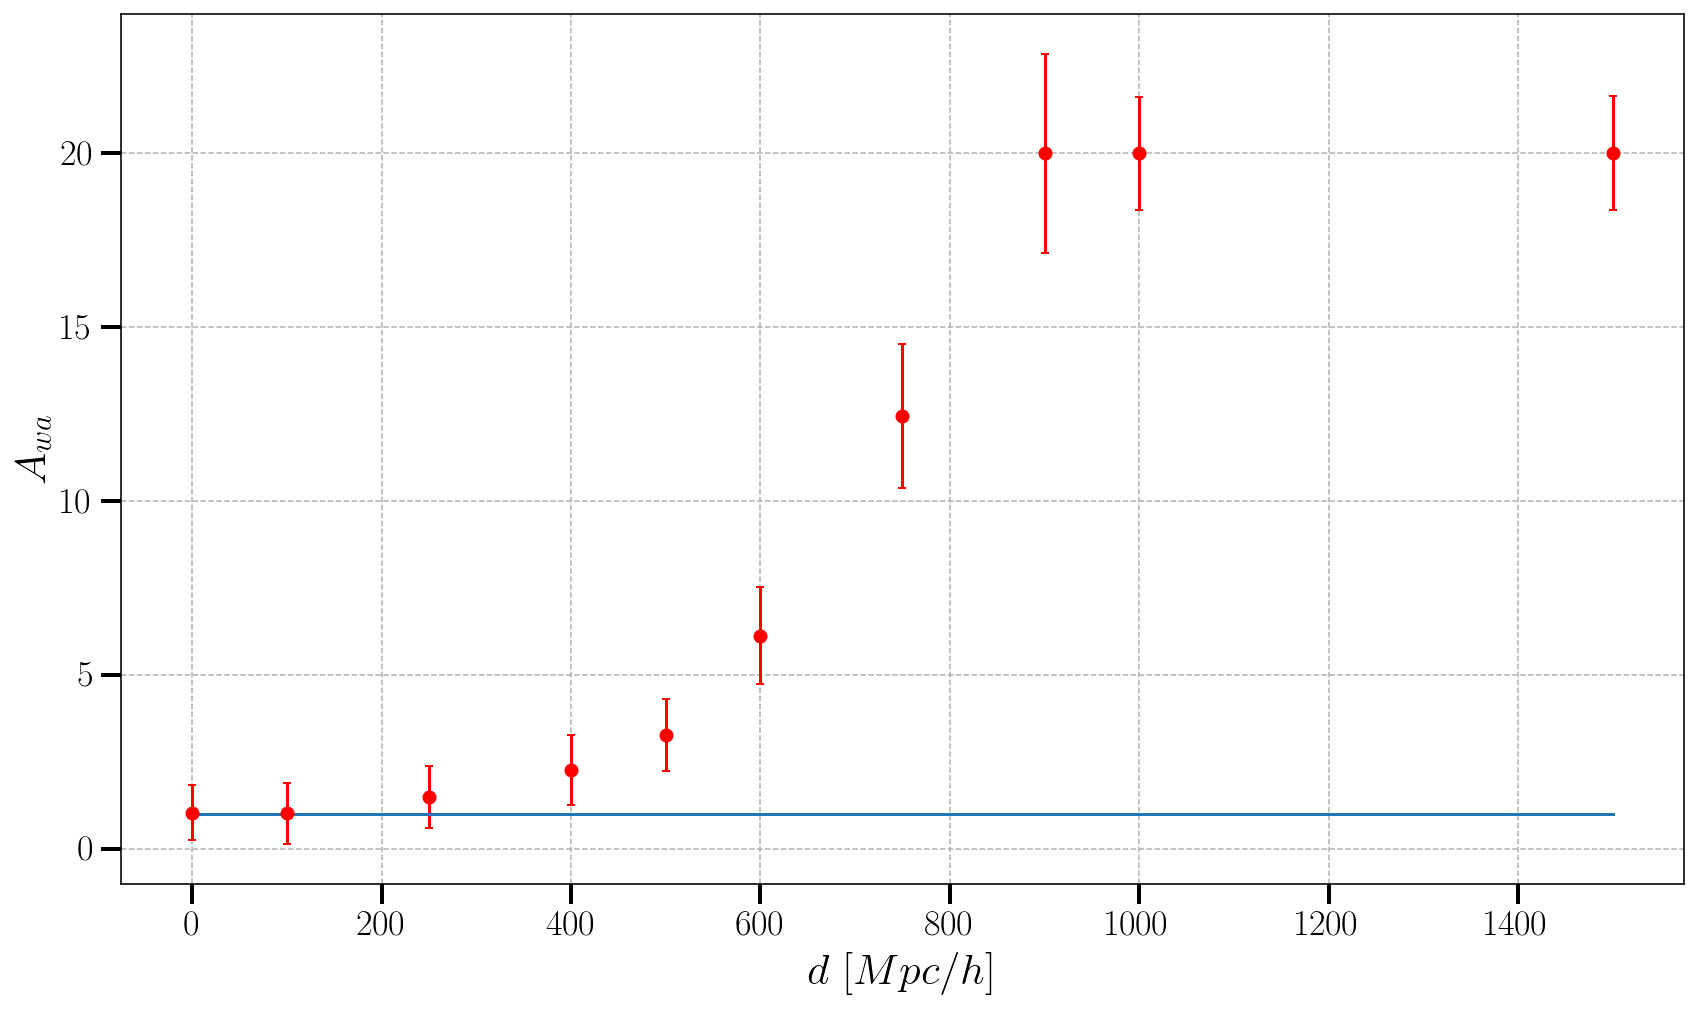

In [1650]:
plt.figure(figsize=(14,8))
#plt.errorbar(d_z_list,A_arr1,yerr=A_arr_err1,fmt ='o',linestyle='none',capsize=2,color='blue')
plt.errorbar(d_z_list,A_arr2,yerr=A_arr_err2,fmt ='o',linestyle='none',capsize=2,color='red')
#plt.errorbar(d_z_list,-A_arr3,yerr=A_arr_err3,fmt ='o',linestyle='none',capsize=2,color='green')
#plt.errorbar(d_z_list,A_arr4,yerr=A_arr_err4,fmt ='o',linestyle='none',capsize=2,color='orange')

#plt.errorbar(d_arr_avg,A_arr,yerr=A_arr_err,fmt ='o',linestyle='none',capsize=2,color='black')
#plt.plot(d_arr_avg[1], np.ones_like(d_arr_avg[1]),color='black',linestyle='--')
plt.plot(d_z_list, np.ones_like(d_z_list))
#plt.plot(d_arr, 1000**2/(d_arr_avg)**2 /np.pi)
#plt.yscale('log')
#plt.ylim(-0.1,1.6)
plt.grid(ls='--',lw=0.75)
plt.ylabel('$A_{wa}$')
plt.xlabel(' $d \ [Mpc/h]$')
plt.savefig('Quad_A_wa',dpi=400,bbox_inches='tight')

100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


1.1021102110211025 0.4860486048604855 1.7181718171817195


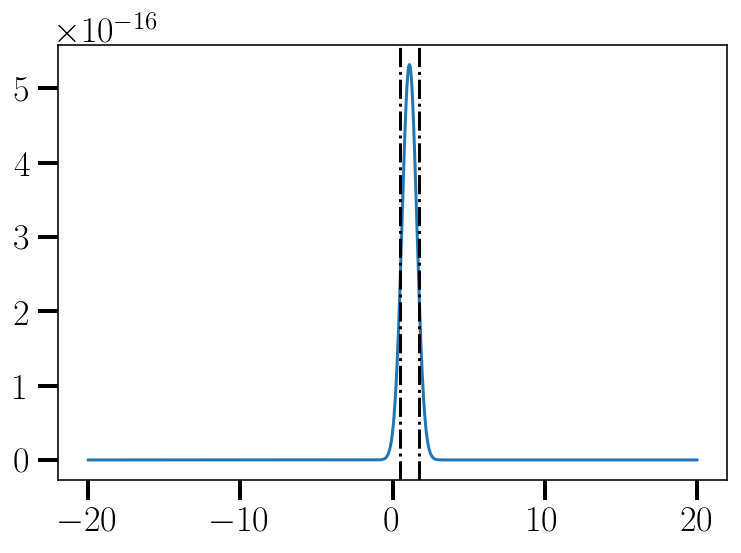

In [1573]:
l=2
obs_pos = (0,0,0)#-500 as we changed coordinates from centre of box from edge...
obs_pos_dual = (0,0,-0)#for averraging on \nu !=0
use_ks = 9
min_ks = 1
#get pp and wide angle terms...
eta_pp = (plot_convolved(k_est[min_ks:use_ks],l,obs_pos,0,[0,1])+plot_convolved(k_est[min_ks:use_ks],l,obs_pos_dual,0,[0,1]))/2
eta_wa = (plot_convolved(k_est[min_ks:use_ks],l,obs_pos,0,[1,3])+plot_convolved(k_est[min_ks:use_ks],l,obs_pos_dual,0,[1,3]))/2
keyl= f'l={l},t=0'
key = 'Cen'

likelihood = get_likelihood(A_wa,eta_pp.real,eta_wa.real,f_sky*Pk_avg1[key][keyl].real[min_ks:use_ks],f_sky*Pk_err1[key][keyl][min_ks:use_ks])
low,high = likelihood_confidence(likelihood,0.90)
plt.plot(A_wa,likelihood)
plt.axvline(x = A_wa[low], linestyle='-.', color = 'black')
plt.axvline(x = A_wa[high], linestyle='-.', color = 'black')
plt.xlim(-5,5)
print(A_wa[np.argmax(likelihood)],A_wa[low],A_wa[high])

In [1321]:
k_plot = np.linspace(0.006,0.4,100)
sigma = 5.3
#mono_1 = (plot_convolved(k_plot,0,(0,0,0),t=0,eta_range=[0,1]))#+plot_convolved(k_plot,0,(0,0,-0),t=0,eta_range=[0,1]))/2
#mono_2 = (plot_convolved(k_plot,0,(0,0,0),t=0,eta_range=[1,2]))#+plot_convolved(k_plot,0,(0,0,-0),t=0,eta_range=[1,2]))/2
#mono_3 = (plot_convolved(k_plot,0,(0,0,0),t=0,eta_range=[2,3]))

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


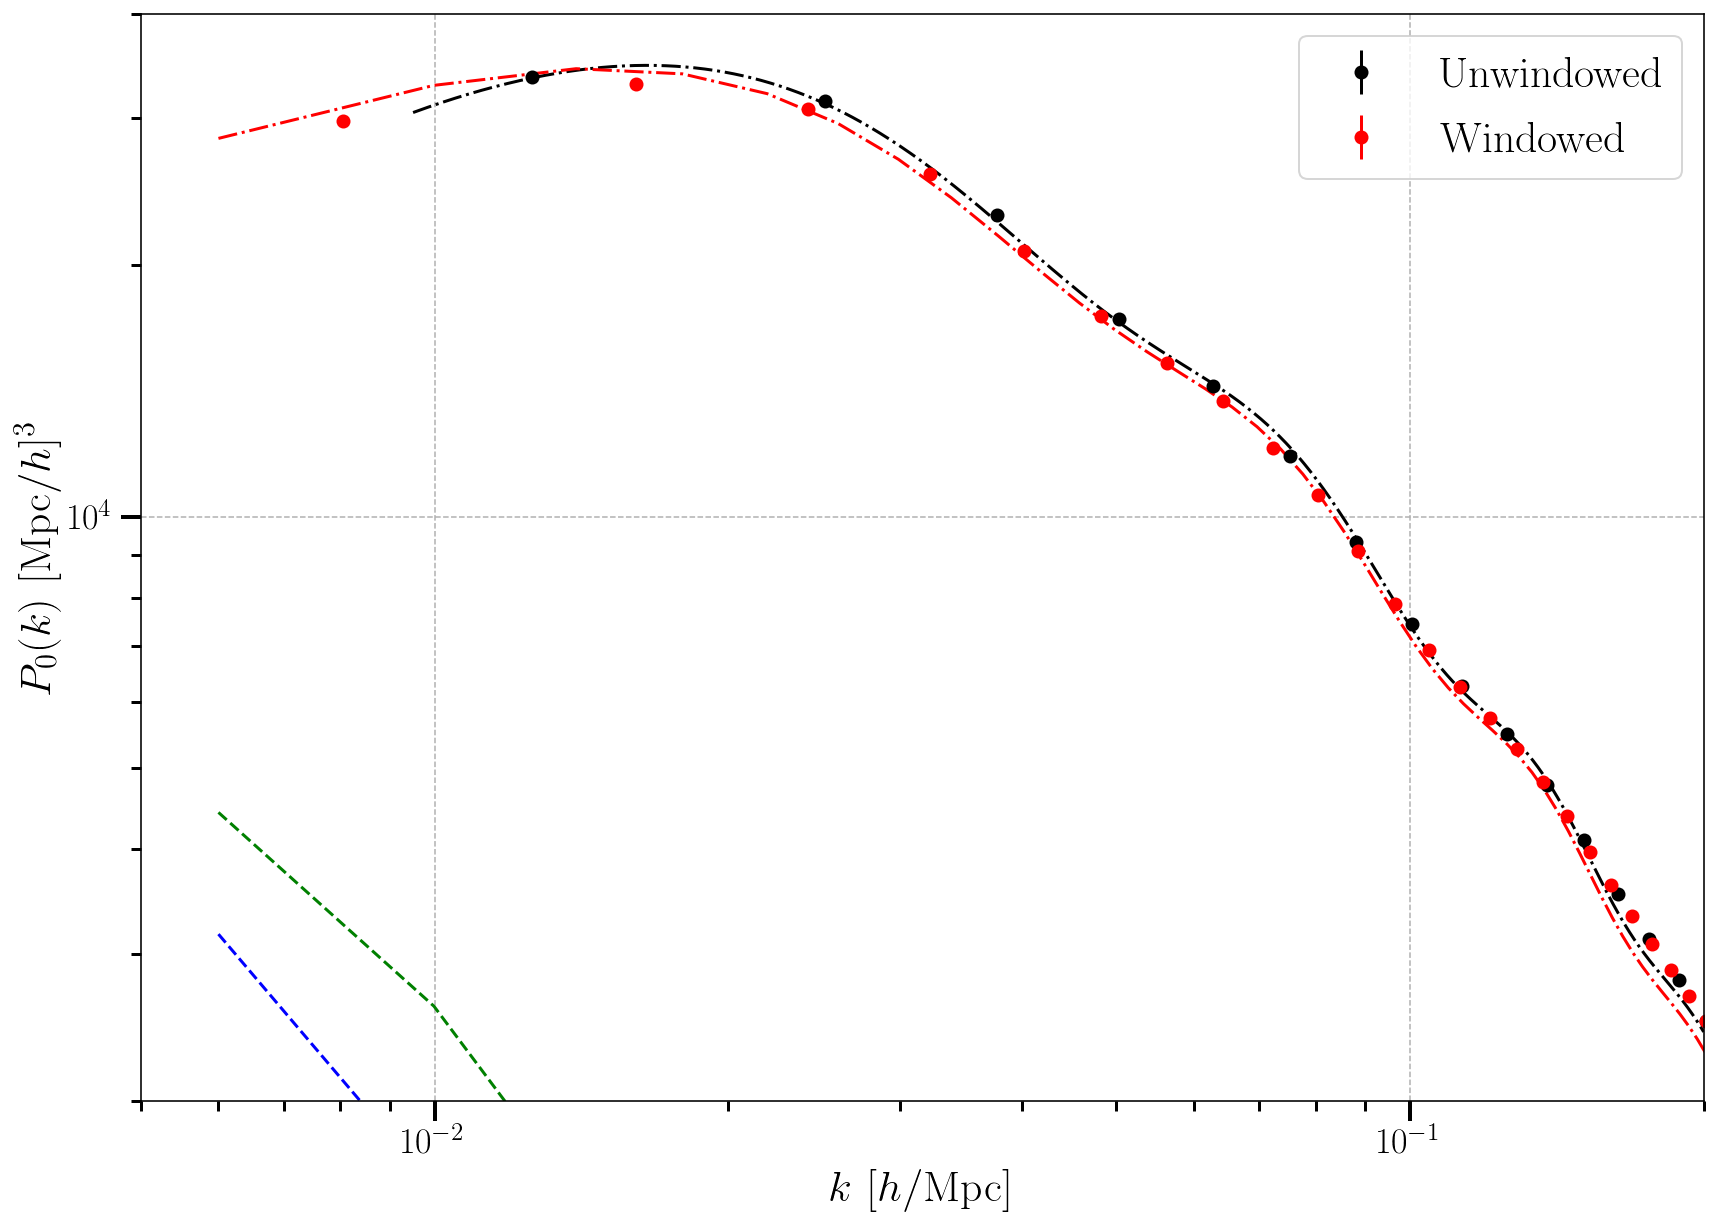

In [1635]:
#monopole!!!
plt.figure(figsize=(14,10))
key = 'Cen'
plt.errorbar(k_est_up,(Pk_avg[key]['l=0'].real),yerr=Pk_err[key]['l=0'],fmt ='o',color='black',label='Unwindowed')
plt.errorbar(k_est, (200/128)**3 *(Pk_avg1[key]['l=0']).real,yerr=Pk_err1['PP']['l=0'],fmt ='o',color='red',label='Windowed')

#plt.loglog(ks,Pl0_pp,'-',color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa,'--',color='blue')
ks=temp_k
plt.plot(ks,pk_mono_dfog(ks,5)+pk_mono_dfog_wa(ks,5.3,8030,0),'-.',color='black')

#convolved theory
plt.plot(k_plot,(1+0.06*np.sqrt(k_plot))*(mono_1.real+mono_2.real+mono_3.real),'-.',color = 'red')

plt.plot(k_plot,(1+0.1*k_plot)*mono_2.real,'--',color = 'green')
plt.plot(k_plot,-(1+0.1*k_plot)*mono_3.real,'--',color = 'blue')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(5e-3,0.2e0)
plt.ylim(2e+3,4e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{0}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
#plt.plot(ks,5*np.gradient(np.gradient(pk_mono_dfog(ks,5.3))))
plt.grid(ls='--',lw=0.75)
plt.savefig("P_0.png",bbox_inches='tight')#

In [139]:
print(k_est[0:6])

[0.00804248 0.01608495 0.02412743 0.03216991 0.04021239 0.04825486]


In [1310]:
k_plot = np.linspace(0.006,0.4,100)
sigma=5.3
plot_tmp_l1 = plot_convolved(k_plot,1,(0,0,1000),0,[0,2])
plot_tmp1_l1 = plot_convolved(k_plot,1,(0,0,-1000),0,[0,2])

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


In [1901]:
dipo_64['0'] = (plot_convolved(k_plot,1,(0,0,0),0,[0,3]))#+plot_convolved(k_plot,1,(0,0,-0),0,[0,2]))/2
#dipo_641 = (plot_convolved(k_plot[2:-18],1,(0,0,1000),0,[0,2])+plot_convolved(k_plot[2:-18],1,(0,0,-1000),0,[0,2]))/2

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [1540]:
print(dipo_64.keys())

dict_keys(['1000'])


In [2209]:
print(Pk_avg3[key]['l=1,t=0'].imag.shape)

(75,)


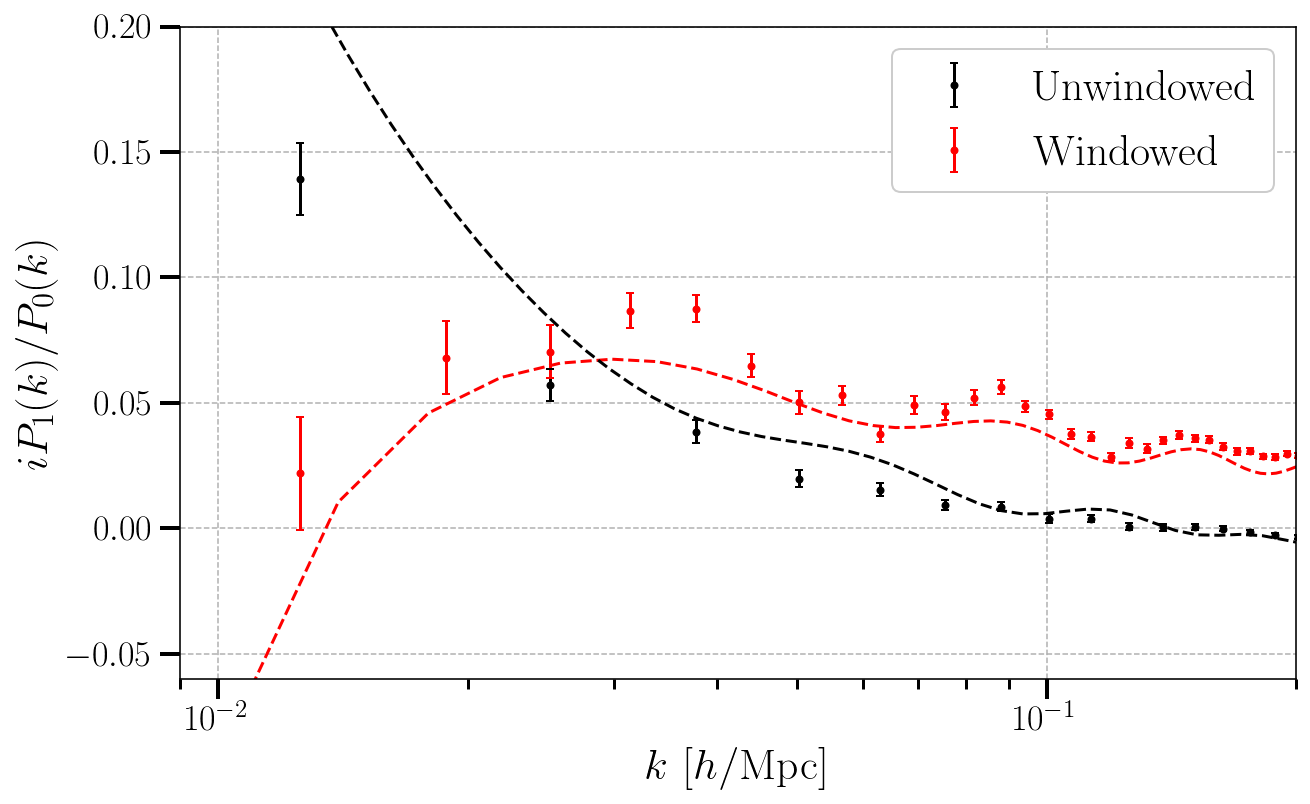

In [2284]:
#dipole!!!
plt.figure(figsize=(10,6))
key ='Cen'
k_pow = 0
plt.errorbar(k_est_up, -(Pk_avg[key]['l=1,t=0'].imag)/(Pk_avg['PP']['l=0'].real),yerr= Pk_err[key]['l=1,t=0']/(Pk_avg['PP']['l=0'].real),fmt ='.',linestyle='none',capsize =2,color='black',label='Unwindowed')
#plt.errorbar(k_est,-(Pk_avg1[key]['l=1,t=0'].imag)/(Pk_avg1['PP']['l=0']).real,yerr= Pk_err1[key]['l=1,t=0']/(Pk_avg1['PP']['l=0']).real,fmt ='o',linestyle='none',color='green',label='Windowed')
#plt.errorbar(k_est3,-(Pk_avg3[key]['l=1,t=0'].imag)/(Pk_avg3['PP']['l=0']).real,yerr= Pk_err3[key]['l=1,t=0']/(Pk_avg3['PP']['l=0']).real,fmt ='o',linestyle='none',color='orange',label='Windowed')
#plt.errorbar(k_est5,-(Pk_avg4[key]['l=1,t=0'].imag)/(Pk_avg4['PP']['l=0']).real,yerr= Pk_err4[key]['l=1,t=0']/(Pk_avg4['PP']['l=0']).real,fmt ='.',linestyle='none',color='red',capsize =2,label='Windowed')
plt.errorbar(k_est256,-(Pk_avg256[key]['l=1,t=0'].imag)/(Pk_avg256['PP']['l=0']).real,yerr= 1.2*Pk_err256[key]['l=1,t=0']/(Pk_avg256['PP']['l=0']).real,fmt ='.',linestyle='none',color='red',capsize =2,label='Windowed')

for i in range(400):
    1#plt.plot(k_est,-(pk['0']['l=1,t=0'][i].imag),'.',alpha=0.6,color='grey')

#plt.plot(k_plot ,k_plot**k_pow * plot_tmp.imag,'--',color='green')
#plt.plot(k_plot ,k_plot**k_pow * plot_tmp_l1.imag,'--',color='blue')
#plt.plot(k_plot ,k_plot**k_pow * 1.05*plot_tmp_l1_128.imag,'--',color='red')
#plt.plot(k_plot ,k_plot**k_pow *plot_tmp1.imag,'--',color='orange')

#plt.plot(k_plot ,k_plot**k_pow *(1+0.2*k_plot)*(plot_tmp_l1.imag+plot_tmp1_l1.imag)/2,'--',color='red')
#plt.plot(k_plot ,k_plot**k_pow *(plot_tmp_.imag+plot_tmp1_.imag)/2,'--',color='black')
plt.plot(k_plot,(1+0.06*np.sqrt(k_plot))*dipo_64['0'].imag/mono_1.real,'--',color='red')
#plt.plot(k_plot[2:-18],dipo_641.imag,'--',color='green')

#plt.plot(k_plot ,k_plot**k_pow *plot_tmp_.imag,'--',color='green')
#plt.plot(k_plot ,k_plot**k_pow *plot_tmp1_.imag,'--',color='orange')
#plt.plot(k_plot ,k_plot**k_pow *(plot_tmp_.imag+plot_tmp1_.imag)/2-(pk_dipo(k_plot,420,0)),'-.',color='green')

plt.plot(ks, -(pk_dipo_dfog_wa(ks,4,420,0).imag)/pk_mono_dfog(ks,5),color='black',linestyle='--')

#plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
#plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
#plt.xlim(3e-3,0.6e0)
plt.xlim(9e-3,0.2)
plt.ylim(-0.06,0.2)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)/P_{0}(k)$')
#plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right',framealpha=1)
plt.grid(ls='--',lw=0.75)
plt.savefig("P_1P_0.png",bbox_inches='tight',dpi=400)#
plt.show()

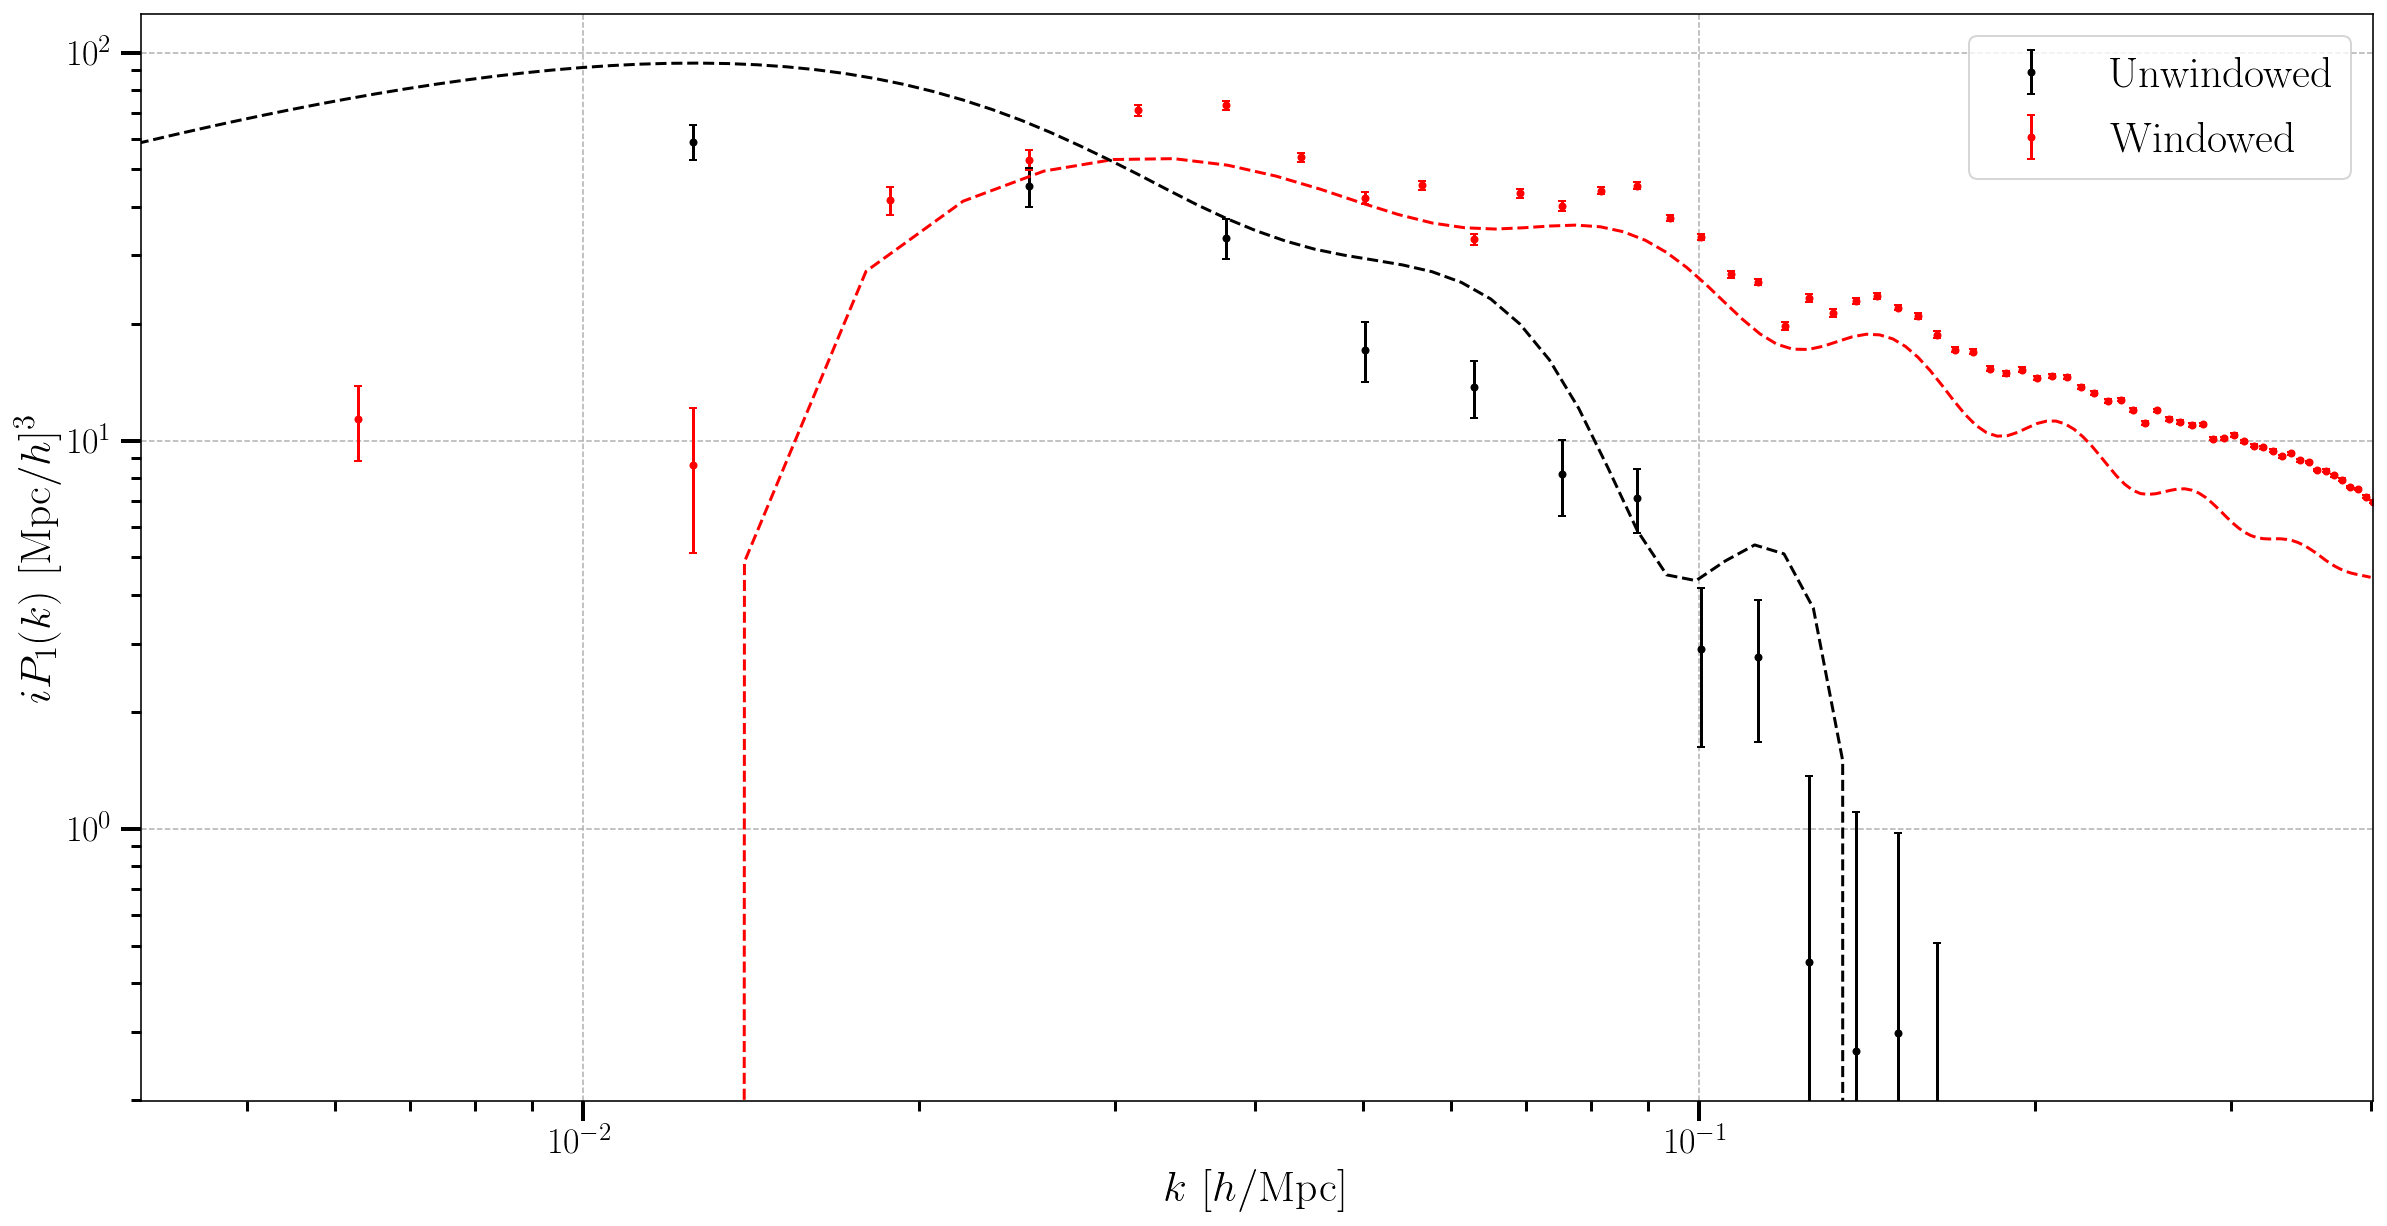

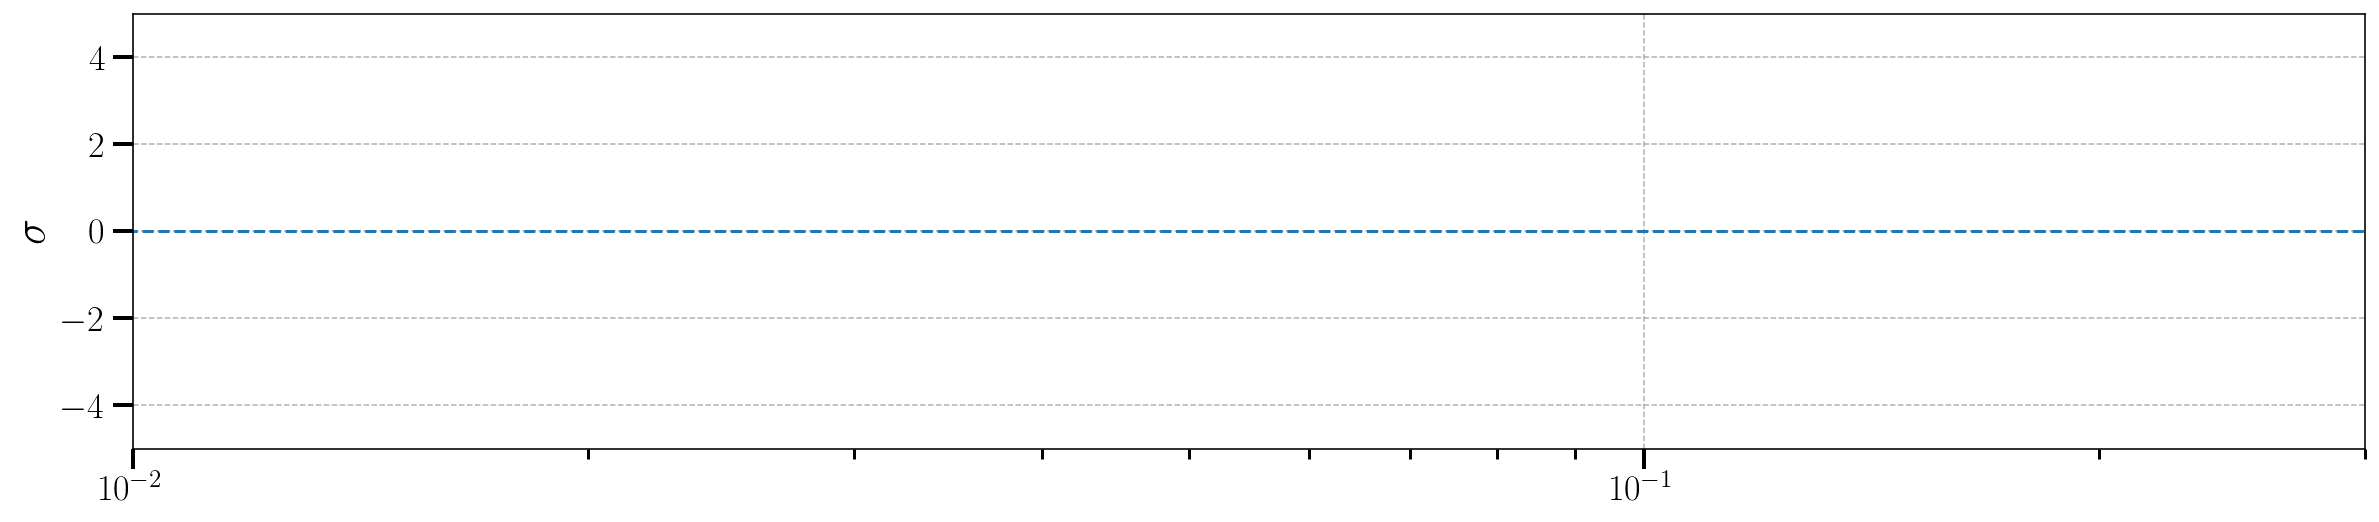

In [2266]:
#dipole!!!
plt.figure(figsize=(20,10))
key ='Cen'
k_pow = 1
plt.errorbar(k_est_up,-k_est_up**k_pow *(Pk_avg[key]['l=1,t=0'].imag),yerr=k_est_up**k_pow *Pk_err[key]['l=1,t=0'],fmt ='.',linestyle='none',capsize=2,color='black',label='Unwindowed')
#plt.errorbar(k_est,(Pk_avg1[key]['l=1,t=5'].imag),yerr=Pk_err1[key]['l=1,t=5'],fmt ='o',linestyle='none',color='red',alpha=1)
#plt.errorbar(k_est,-k_est**k_pow *(200/128)**3 *(Pk_avg1[key]['l=1,t=0'].imag),yerr=(200/128)**3 *k_est**k_pow *Pk_err1[key]['l=1,t=0'],fmt ='.',linestyle='none',capsize=2,color='blue',label='Windowed')


plt.errorbar(k_est256,-k_est256**k_pow *(256/128)**3 *(Pk_avg256[key]['l=1,t=0'].imag),yerr=(200/128)**3 *k_est256**k_pow *Pk_err256[key]['l=1,t=0'],fmt ='.',linestyle='none',capsize=2,color='red',label='Windowed')
#plt.errorbar(k_est,-k_est**k_pow *(200/128)**3 *(Pk_avg2[key]['l=1,t=5'].imag),yerr=(200/128)**3 *k_est**k_pow *Pk_err2[key]['l=1,t=5'],fmt ='.',linestyle='none',capsize=2,color='green',label='Windowed')


#plt.errorbar(k_est5,-k_est5**k_pow *(500/128)**3 *(Pk_avg4[key]['l=1,t=0'].imag),yerr=(500/128)**3 *k_est5**k_pow *Pk_err4[key]['l=1,t=0'],fmt ='.',linestyle='none',capsize=2,color='red',label='Windowed')


for i in range(400):
    1#plt.plot(k_est,-(pk['0']['l=1,t=0'][i].imag),'.',alpha=0.6,color='grey')

plt.plot(k_plot,k_plot*k_pow *(1+0.06*np.sqrt(k_plot))*dipo_64['0'].imag,'--',color='red')

plt.plot(ks, -ks**k_pow *(pk_dipo_dfog_wa(ks,4,420,0).imag),color='black',linestyle='--')

#plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
#plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
#plt.xlim(9e-3,0.6e0)
plt.xlim(grid_info[5],grid_info[6])
#plt.ylim(1e+1,1e+5)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(ls='--',lw=0.75)
plt.savefig("P_1.png",bbox_inches='tight')
plt.show()
plt.figure(figsize=(20,4))
#plt.plot(k_est,((np.abs(Pk_avg[key]['l=1,t=0'])-np.abs(Pk_avg2[key]['l=1,t=1']))/Pk_err[key]['l=1,t=0']),'o')
plt.xscale('log')
plt.grid(ls='--',lw=0.75)
plt.ylabel('$\sigma$')
plt.xlim(1e-2,0.3e0)
plt.ylim(-5,5)
plt.plot(k_est,np.zeros_like(k_est),'--')

In [1614]:
k_plot = np.linspace(0.006,0.4,100)
sigma = 5.3
octo_1 = (plot_convolved(k_plot,3,(0,0,750),t=0,eta_range=[0,1])+plot_convolved(k_plot,3,(0,0,-750),t=0,eta_range=[0,1]))/2
octo_2 = (plot_convolved(k_plot,3,(0,0,750),t=0,eta_range=[1,2])+plot_convolved(k_plot,3,(0,0,-750),t=0,eta_range=[1,2]))/2
octo_3 = (plot_convolved(k_plot,3,(0,0,750),t=0,eta_range=[2,3])+plot_convolved(k_plot,3,(0,0,-750),t=0,eta_range=[2,3]))/2
octo_4 = (plot_convolved(k_plot,3,(0,0,750),t=0,eta_range=[3,4])+plot_convolved(k_plot,3,(0,0,-750),t=0,eta_range=[3,4]))/2


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


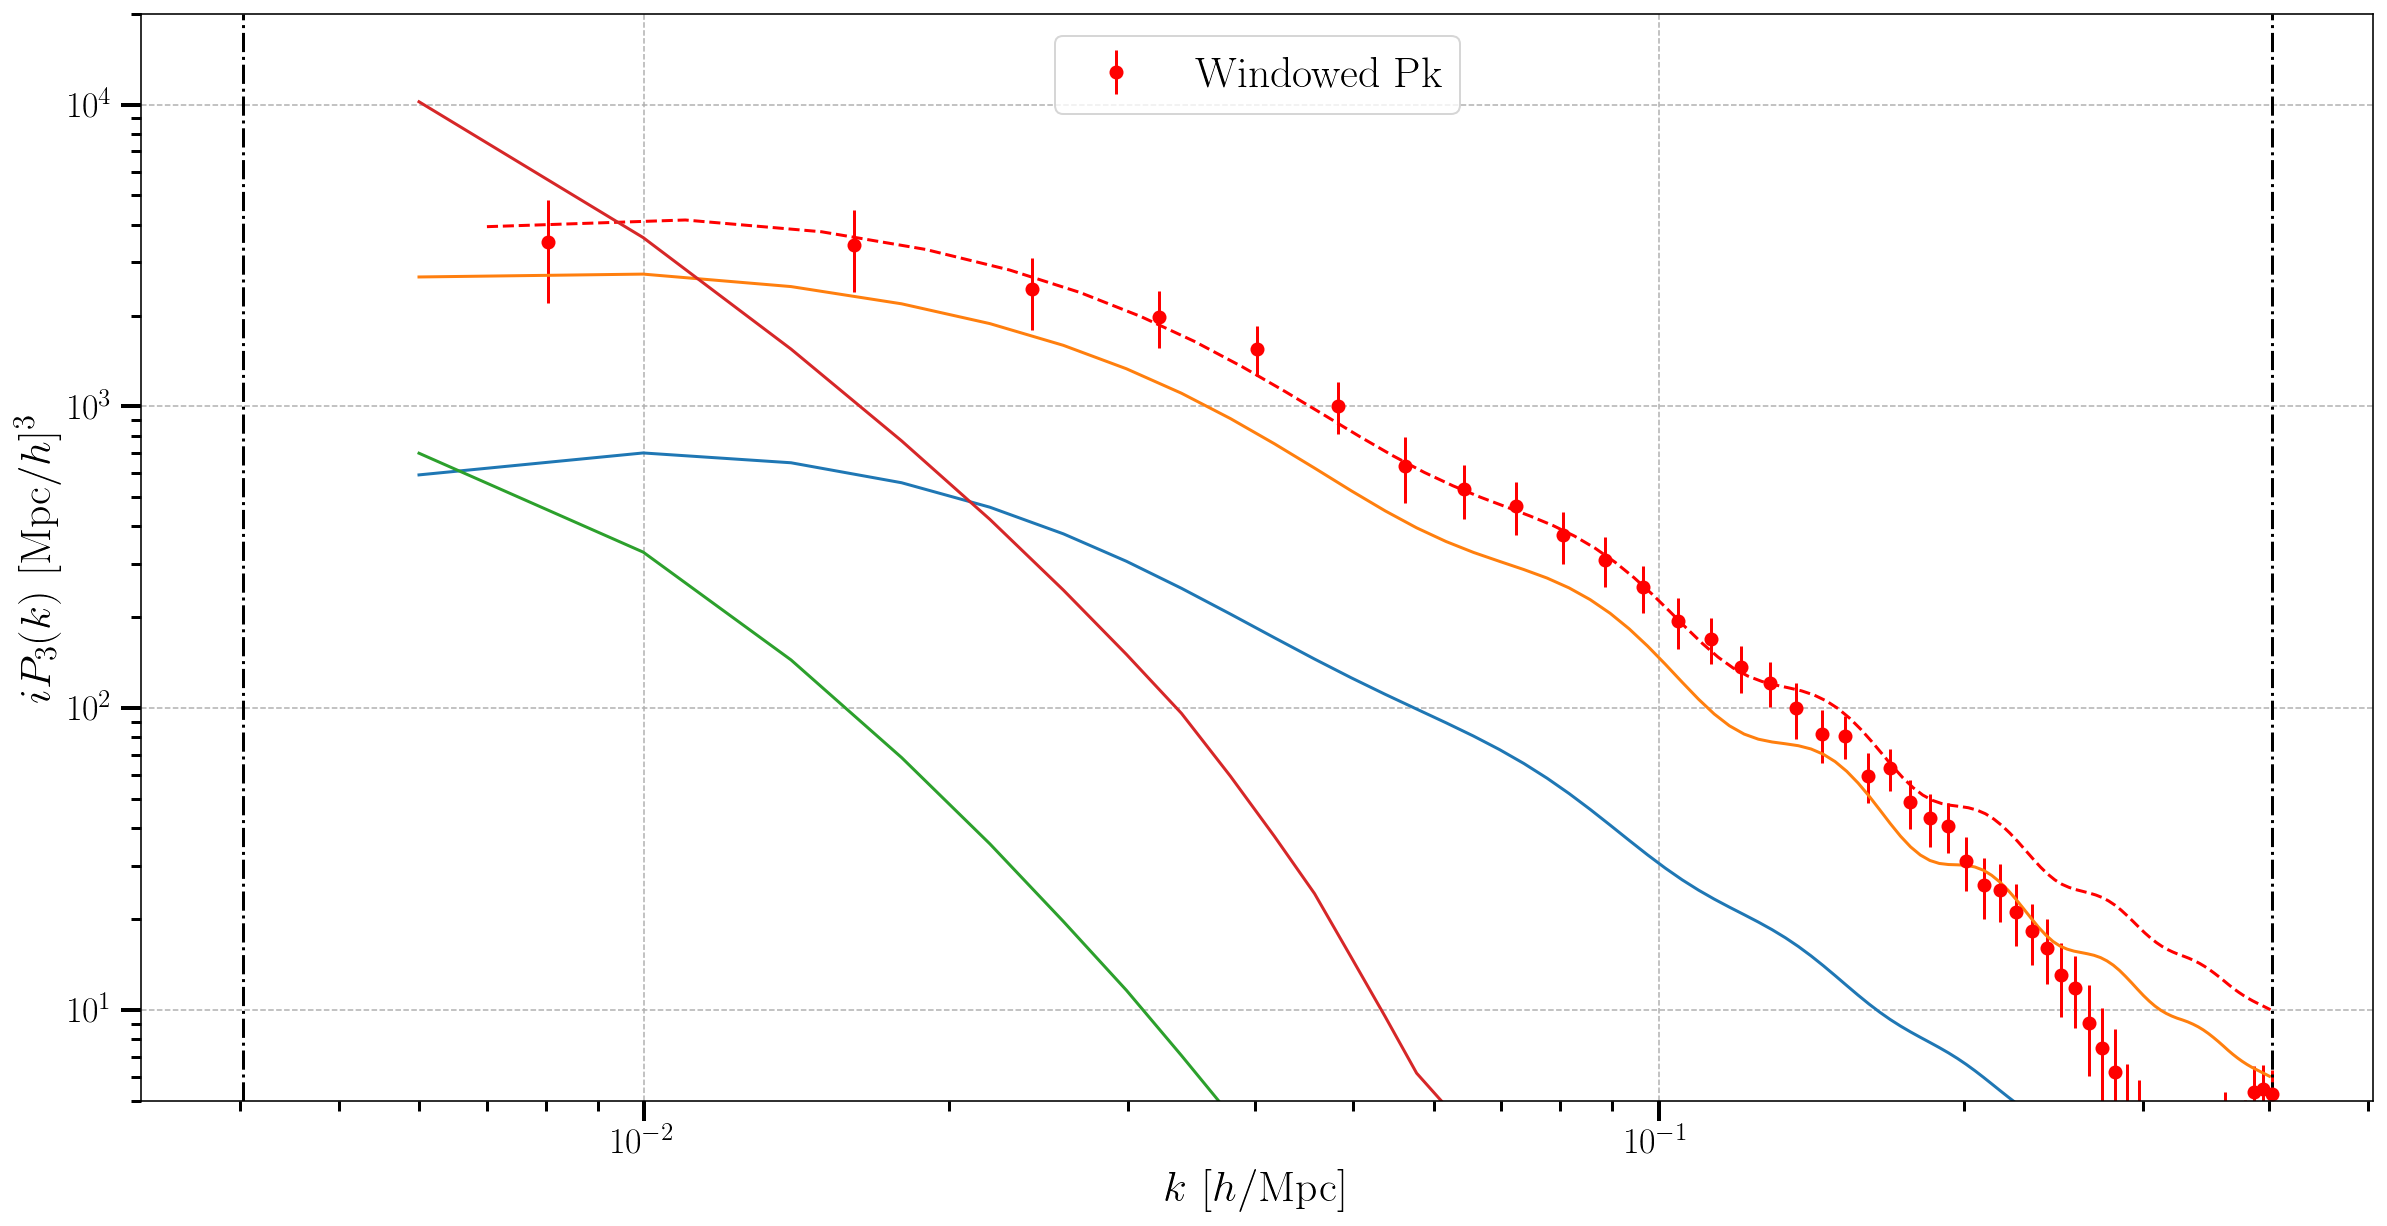

In [1615]:
#octupole!!!
plt.figure(figsize=(20,10))

key1 = '-250'
#plt.errorbar(k_est_up,-(Pk_avg[key1]['l=3,t=0']).imag,yerr=Pk_err[key1]['l=3,t=0'],fmt ='o',linestyle='none',color='black',alpha=0.8)
plt.errorbar(k_est,np.abs((200/128)**3 *k_est**0 *(Pk_avg1[key1]['l=3,t=0']).imag),yerr=(200/128)**3 *k_est**0*Pk_err1[key1]['l=3,t=0'],fmt ='o',linestyle='none',color='red',label='Windowed Pk')

for i in range(100):
    1#plt.plot(k_est,-(200/128)**3 * (pk1[key1]['l=3,t=0'][i].imag),'.',alpha=0.6,color='grey')

plt.plot(k_plot+0.001,k_plot**0 *1.2*(1.0+0.3*k_plot)*(octo_1-octo_2).imag,color='red',linestyle='--')
#plt.plot(k_plot+0.001,k_plot**0 *(1.0+0.3*k_plot)*(octo_1-octo_2+octo_3-octo_4).imag,color='red',linestyle='--')
plt.plot(k_plot,k_plot**0 *(octo_1).imag)
plt.plot(k_plot,k_plot**0 *-(octo_2).imag)
plt.plot(k_plot,k_plot**0 *-(octo_3).imag)
plt.plot(k_plot,k_plot**0 *(octo_4).imag)
#plt.plot(ks,-ks**0 *(pk_oct(ks,1000,0).imag),color='black',linestyle='--')#+pk_octo_3(ks,d,0).imag
#plt.plot(ks,-(pk_octo_dfog_wa(ks,5.3,427,0).imag),color='black',linestyle='-')
#plt.plot(ks,np.abs(pk_octo_dfog_wa(ks,5.3,1000,0).imag+pk_octo_3(ks,1000,0).imag),color='black',linestyle='--')

plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
#plt.xlim(6e-3,0.3e0)
plt.ylim(0.5e+1,2e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{3}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(ls='--',lw=0.75)
plt.savefig("P_3.png",bbox_inches='tight')#

In [1051]:
def slice_realisations(key,key1,low,high):
    temp_arr = 1*pk[key][key1]
    pk1[key][key1] = temp_arr[low:high]#this the way to change without chopping og
    print(pk1[key][key1].shape)
    return avg_err(pk1)

Pk_avg1,Pk_err1,Pk_std1 = slice_realisations('PP','l=2,t=0',0,400)
Pk_avg2,Pk_err2,Pk_std2 = slice_realisations('0','l=2,t=0',350,400)
print(pk['PP']['l=2,t=0'].shape)


(400, 32)
(50, 32)
(500, 32)


In [1557]:
k_plot = np.linspace(0.006,0.4,100)
sigma = 5.3
#quad_1 = (plot_convolved(k_plot,2,(0,0,0),t=0,eta_range=[0,1]))#+plot_convolved(k_plot,2,(0,0,-0),t=0,eta_range=[0,1]))/2
#quad_2 = (plot_convolved(k_plot,2,(0,0,0),t=0,eta_range=[1,2]))#+plot_convolved(k_plot,2,(0,0,-0),t=0,eta_range=[1,2]))/2
#quad_3 = (plot_convolved(k_plot,2,(0,0,0),t=0,eta_range=[2,3]))#+plot_convolved(k_plot,2,(0,0,-0),t=0,eta_range=[2,3]))/2

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


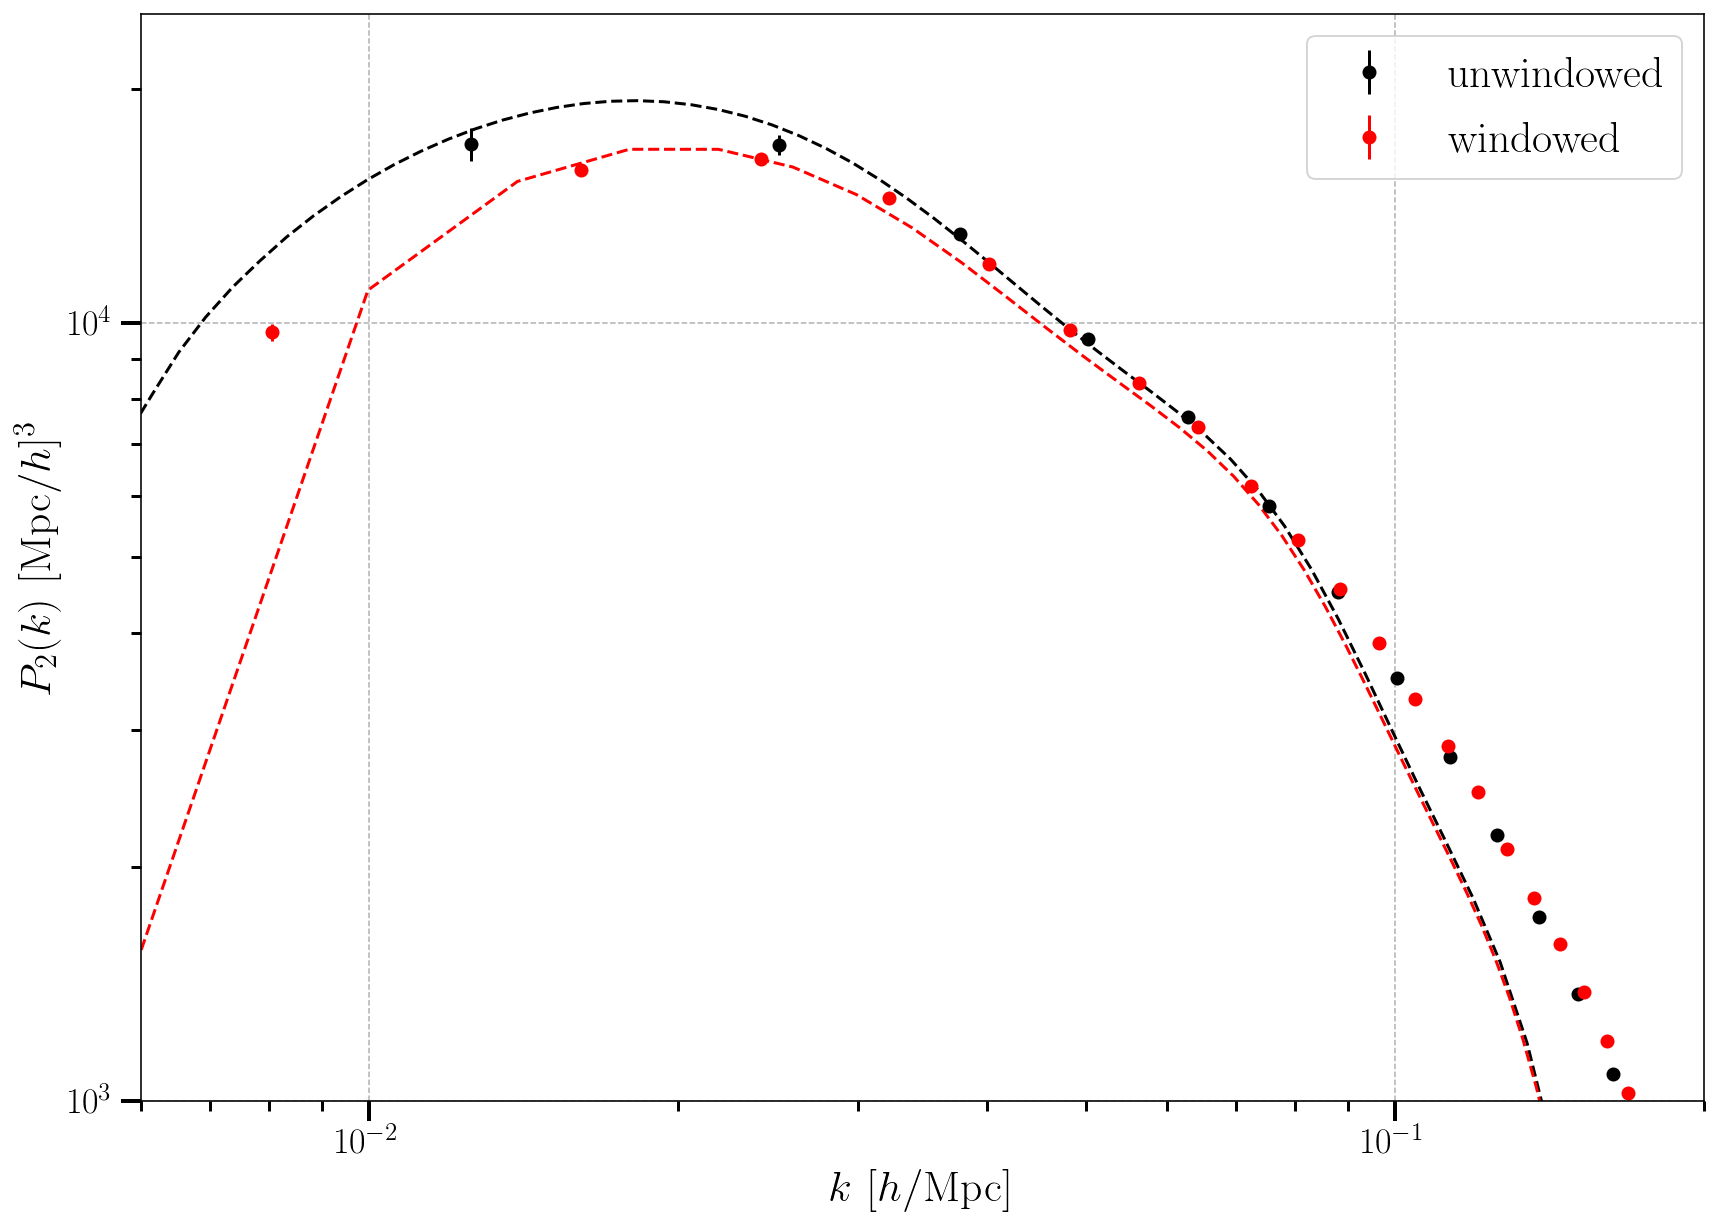

In [2102]:
#quadrupole
plt.figure(figsize=(14,10))
key = 'Cen'
plt.errorbar(k_est_up,(Pk_avg[key]['l=2,t=0'].real),yerr=Pk_err[key]['l=2,t=0'],fmt ='o',color='black',label='unwindowed')
#plt.errorbar(k_est_up,(Pk_avg['PP']['l=2,t=0'].real),yerr=Pk_err[key]['l=2,t=0'],fmt ='o',color='black',label='unwindowed')

#plt.errorbar(k_est,(200/128)**3 *(Pk_avg1['PP']['l=2,t=0'].real),yerr=Pk_err1[key]['l=2,t=0'],fmt ='o',color='red')
plt.errorbar(k_est,(200/128)**3 *(Pk_avg1[key]['l=2,t=0'].real),yerr=Pk_err1[key]['l=2,t=0'],fmt ='o',color='red',label='windowed')

#plt.plot(ks, pk_quad_dfog(ks,4),label='4')
#plt.plot(ks, pk_quad_dfog(ks,5),label='5')
#plt.plot(ks, pk_quad_dfog(ks,6),label='6')
#plt.plot(ks, pk_quad_dfog(ks,7),label='7')
plt.plot(ks, pk_quad_dfog(ks,5.3)+pk_quad_dfog_wa(ks,5.3,500,0),color='black',linestyle='--')


#convolved theory
#plt.plot(k_plot,(1+0.3*k_plot)*quad_1.real,'-',color = 'blue')
plt.plot(k_plot,(1+0.06*np.sqrt(k_plot))*(quad_1.real+quad_2.real+quad_3.real),'--',color = 'red')
#plt.plot(k_plot,(1+0.0*np.sqrt(k_plot))*(quad_1.real+quad_2.real+quad_3.real),'--',color = 'blue')
#plt.plot(k_plot,(1+0.3*k_plot)*(quad_2.real),'--')
#plt.plot(k_plot,(1+0.3*k_plot)*(quad_3.real),'--')

#plt.loglog(ks,Pl2_pp,'--',color='black')
for i in range(100):
    1#plt.plot(k_est,(np.abs((200/128)**3 *pk1[key]['l=2,t=0'][i].real)),'.',alpha=0.2,color='blue')
    1#plt.plot(k_est_up,(np.abs(pk[key]['l=2,t=0'][i].real)),'.',alpha=0.2,color='blue')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(6e-3,0.2e0)
plt.ylim(1e+3,2.5e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$P_{2}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.xscale('log')
plt.yscale('log')
#plt.plot(ks,5*np.gradient(np.gradient(pk_quad_dfog(ks,5.3))))
plt.legend()
#plt.plot(k_plot,5*np.gradient(np.gradient(quad_1.real)))
plt.grid(ls='--',lw=0.75)
plt.savefig("P_2.png",bbox_inches='tight')

In [1425]:
#hexadecapole
plt.figure(figsize=(14,10))

plt.errorbar(k_est_up,np.abs(Pk_avg['PP']['l=4,t=0'].real),yerr=Pk_err['PP']['l=4,t=0'],fmt ='o',color='blue')
plt.errorbar(k_est,(200/128)**3 *np.abs(Pk_avg1['PP']['l=4,t=0'].real),yerr=Pk_err1['PP']['l=4,t=0'],fmt ='o',color='red')

sigma=4
#plt.plot(ks, Pl4_pp,color='black')
plt.plot(ks, np.abs(pk_hexa_dfog(ks,sigma)),linestyle='--',color='black')
#plt.plot(ks, np.abs(pk_hexa_dfog(ks,sigma)+pk_quad_dfog_wa(ks,sigma,430,0)),linestyle='--',color='blue')
#plt.loglog(ks,Pl2_pp,'--',color='black')
for i in range(100):
    1#plt.plot(k_est,-(pk['PP']['l=4,t=0'][i].real),'.',alpha=0.2,color='blue')
    1#plt.plot(k_est,(np.abs(pk_500['l=2,t=0'][i].real)),'.',alpha=0.2,color='red')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(6e-3,0.1e0)
plt.ylim(1e+1,2e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{4}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
#plt.yscale('log')

plt.grid(ls='--',lw=0.75)
plt.savefig("P_0_pp_comp.png",bbox_inches='tight')

KeyError: 'l=4,t=0'

<Figure size 1008x720 with 0 Axes>

In [1829]:
def realconv(ks,q_vec):
    #kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2 + 2*ks*np.sqrt(q_vec[0]**2+q_vec[1]**2+q_vec[2]**2))
    kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2)
    kk = np.where(kk<1e-4,1e-4,kk)
    pk_temp = FFTW_ifft(Pk_(kk)*wq)
    pk_conv = np.sum((np.fft.fftshift(pk_temp))[In_window])
    return pk_conv/np.sum(In_window)

#k_plot= np.linspace(0.006,0.4,100)
mono_real1 = np.zeros(len(k_cen),dtype=np.complex64)
for i,kk in enumerate(k_cen):
    mono_real1[i] = realconv(kk,qs)

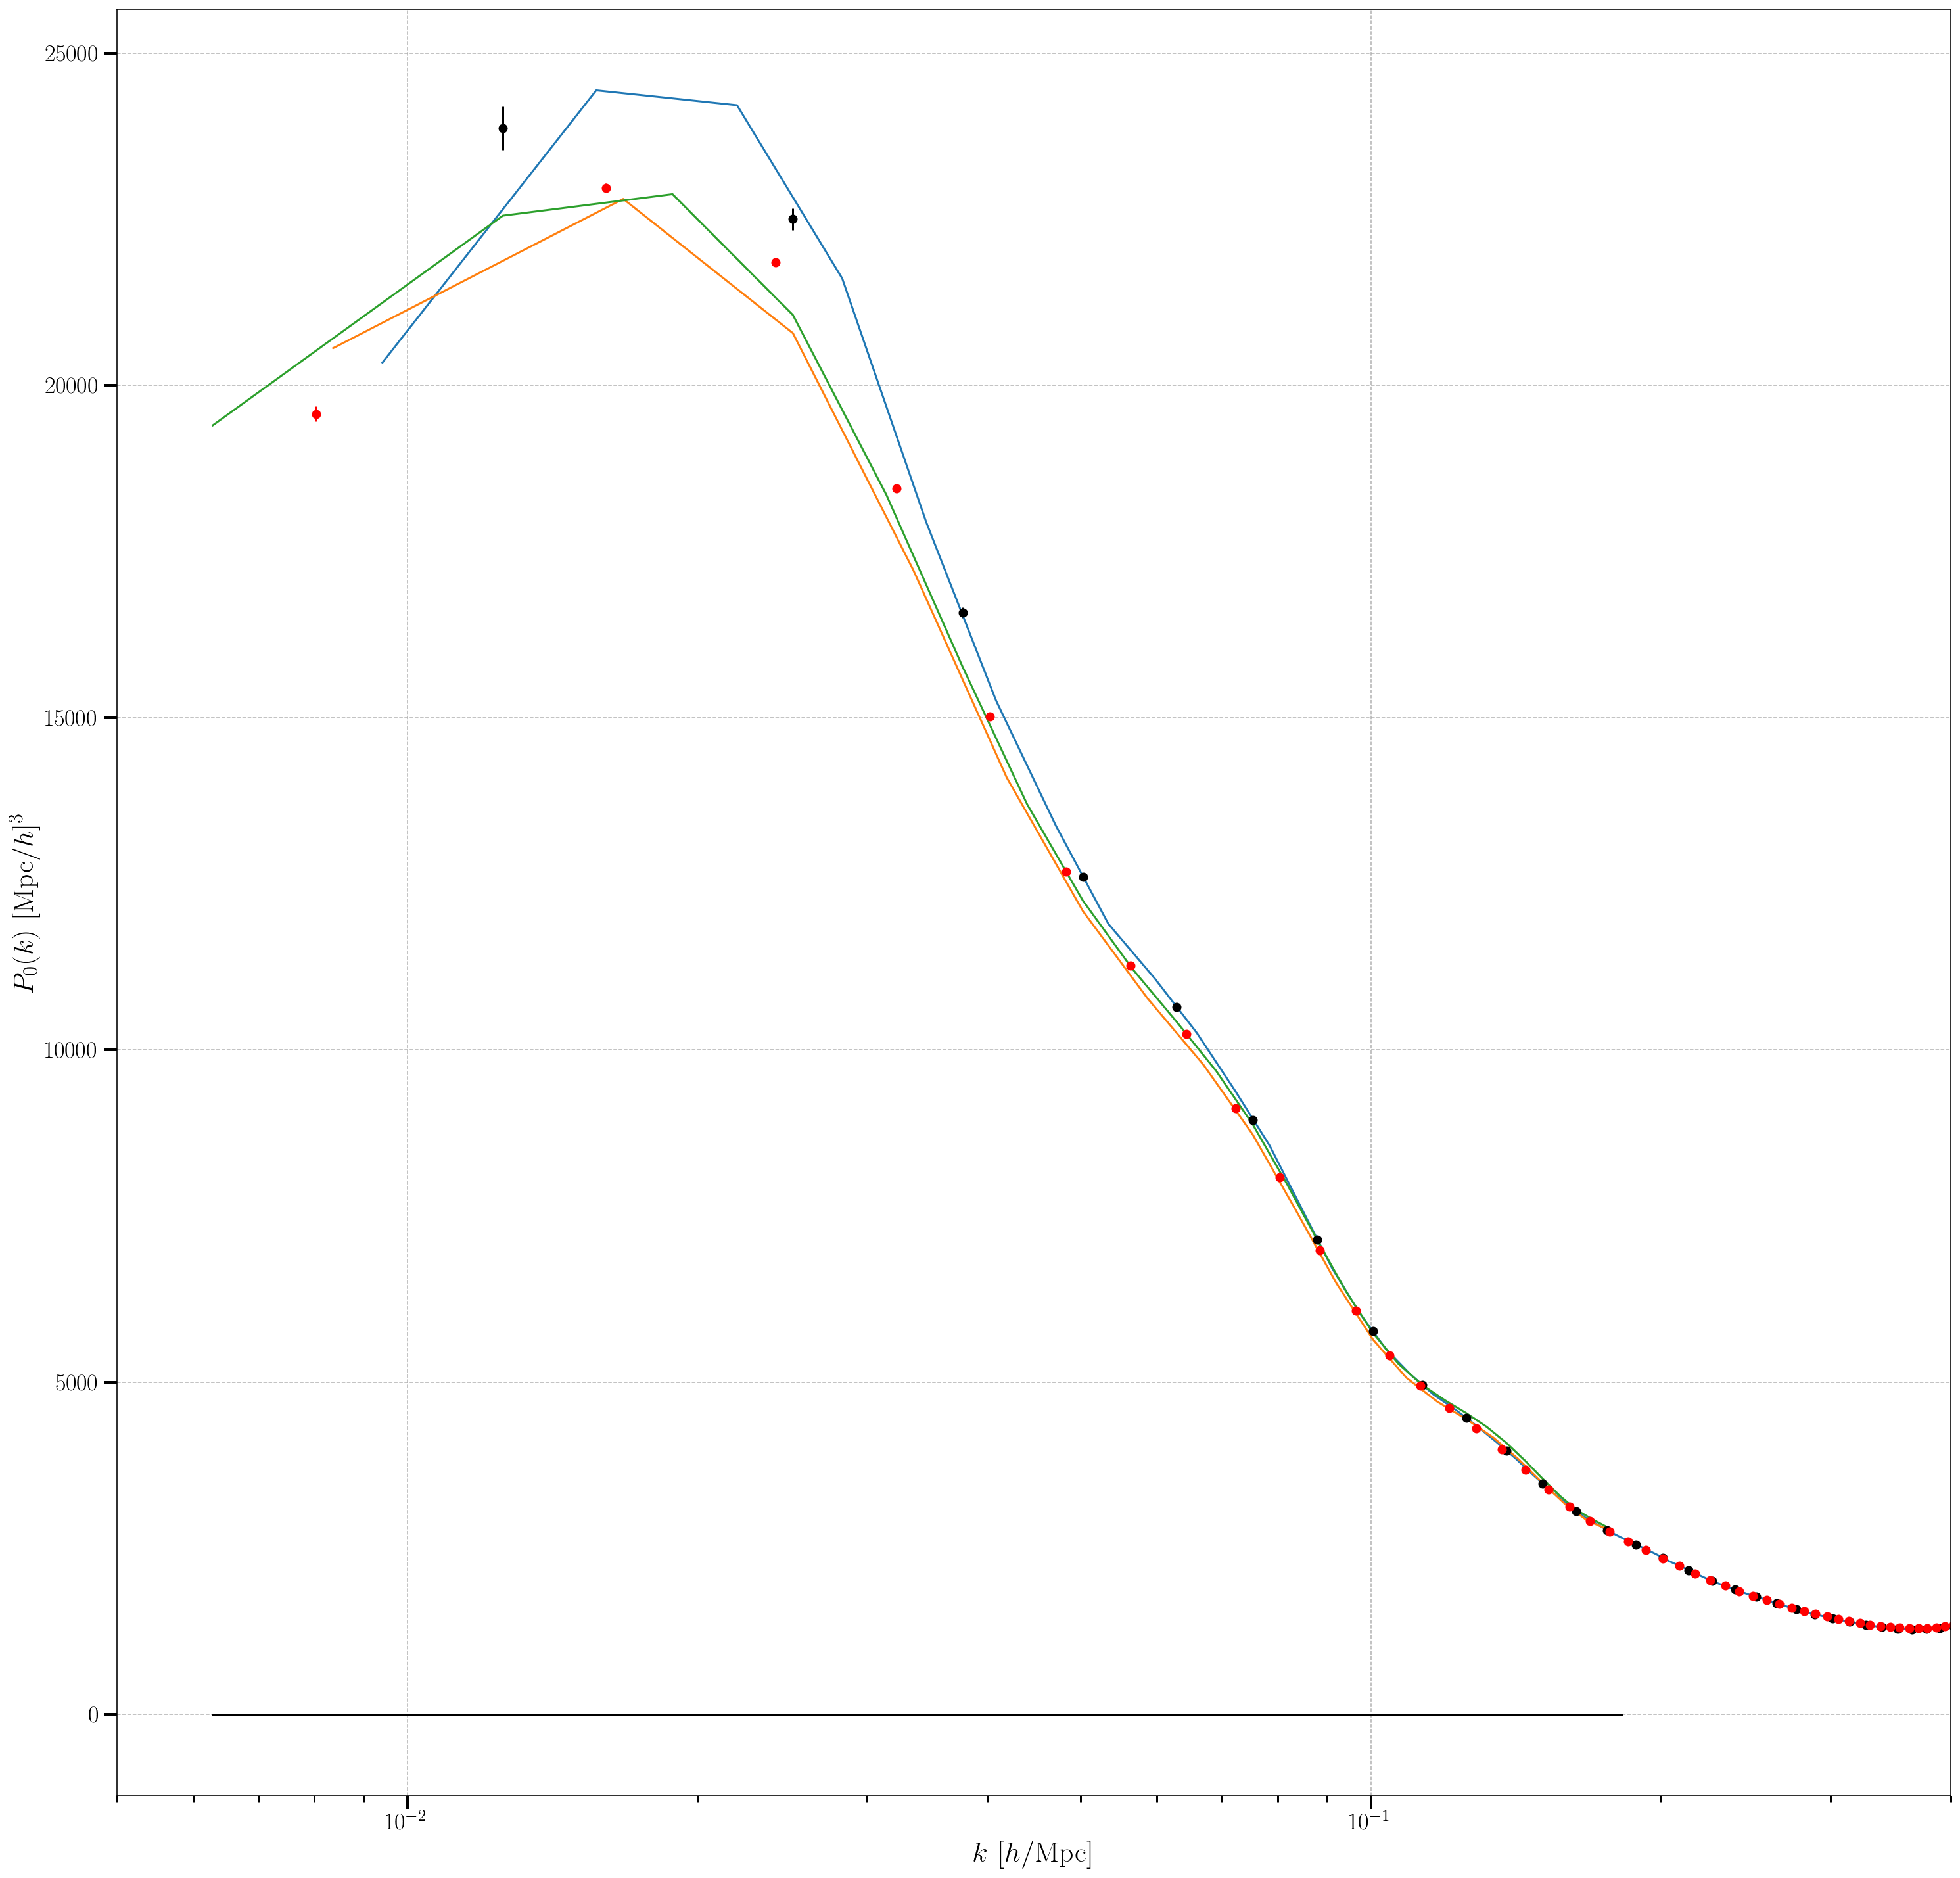

In [2148]:
#real space 
plt.figure(figsize=(25,25))
key = 'real'
plt.errorbar(k_est_up,(Pk_avg[key]['l=0'].real),yerr=Pk_err[key]['l=0'],fmt ='o',color='black')
plt.errorbar(k_est, (200/128)**3 *(Pk_avg1[key]['l=0']).real,yerr=Pk_err1[key]['l=0'],fmt ='o',color='red')
plt.plot(k_est3,Pk_avg3['real']['l=0'].real)


#plt.plot(k_cen1,pk_test.real,'--')
plt.plot(k_cen48,pk_test_48.real)
plt.plot(k_cen,(1+0.06*np.sqrt(k_cen))*pk_test_64.real)
plt.plot(k_cen,pk_real_32.real,'k')

#plt.errorbar(k_est2, (Pk_avg2[key]['l=0']).real,yerr=Pk_err2[key]['l=0'],fmt ='o',color='blue')
#plt.errorbar(k_est3, (Pk_avg3[key]['l=0']).real,yerr=Pk_err3[key]['l=0'],fmt ='o',color='blue')
#plt.plot(k_plot,temps,'--',color='black')
#plt.plot(k_plot,Pk_(k_plot),'--',color='black')#
#plt.plot(k_est3[1:],Pk_sim(k_est3[1:]),'-.',color='blue')
#plt.plot(k_plot,mono_real.real,'--',color='red')

#plt.plot(ks,100000*np.gradient(np.gradient(Pk_(ks))))

plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(5e-3,0.4e0)
#plt.ylim(1e+3,3e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{0}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
#plt.yscale('log')

plt.grid(ls='--',lw=0.75)
plt.savefig("real_space_cov.png",bbox_inches='tight')

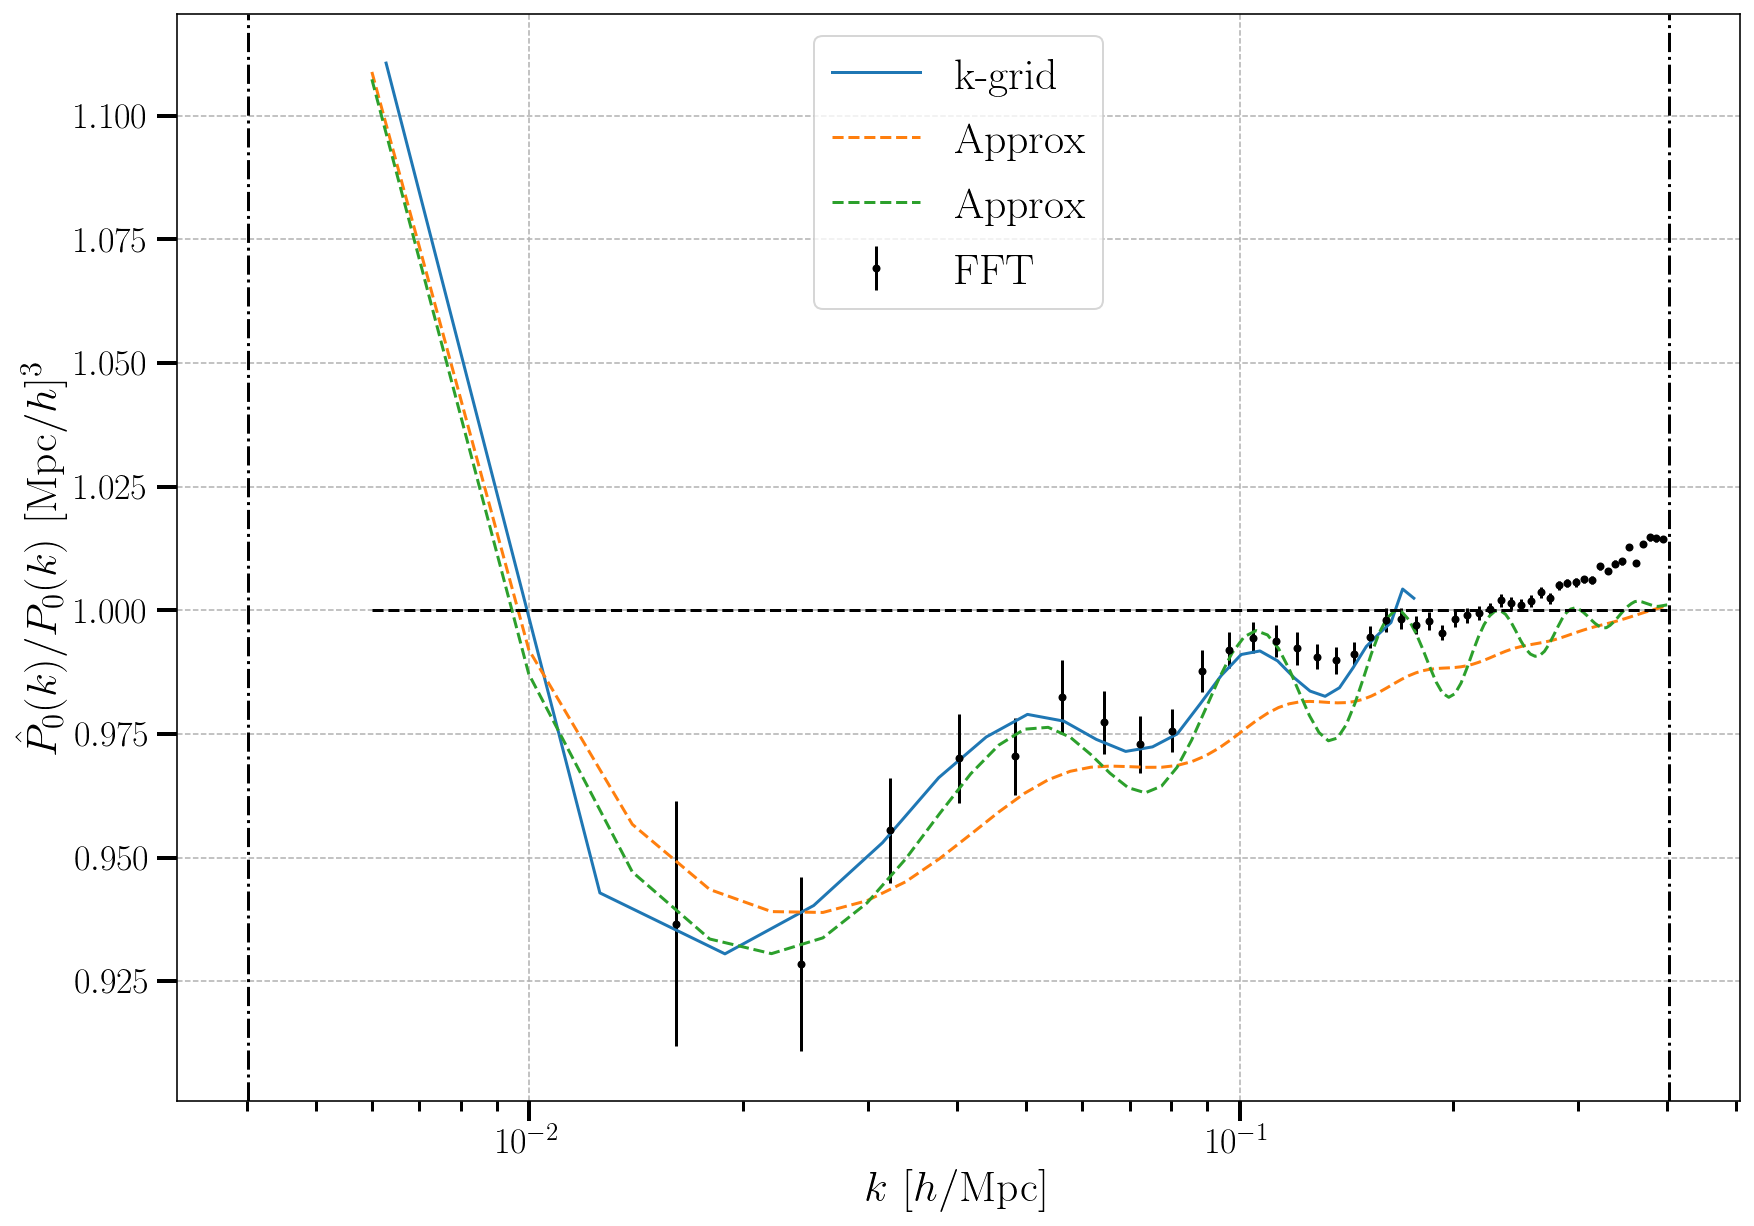

In [2283]:
plt.figure(figsize=(14,10))
plt.plot(k_cen,(1+0.06*np.sqrt(k_cen))*pk_test_64.real/Pk_(k_cen),'-',label='k-grid')
plt.plot(k_plot,(1+0.06*np.sqrt(k_plot))*mono_real.real/Pk_(k_plot),'--',label='Approx')

plt.plot(k_plot,(1+4e-7*k_plot**(2)*np.gradient(np.gradient(Pk_(k_plot),k_plot),k_plot))*(1+0.06*np.sqrt(k_plot))*mono_real.real/Pk_(k_plot),'--',label='Approx')


#plt.plot(k_cen,1+1e-9*np.gradient(np.gradient(Pk_(k_cen),k_cen),k_cen))
#plt.plot(k_est,(200/128)**3 *(Pk_avg1[key]['l=0']).real/Pk_(k_est),'.')
#plt.plot(k_est[1:-1],(200/128)**3 *(Pk_avg1[key]['l=0']).real[1:-1]/Pk_sim(k_est[1:-1]),'+')
plt.errorbar(k_est[1:-1],(200/128)**3 *(Pk_avg1['real']['l=0']).real[1:-1]/Pk_sim(k_est[1:-1]),yerr=(200/128)**3 *1.5*(Pk_err1[key]['l=0']).real[1:-1]/Pk_sim(k_est[1:-1]),fmt ='.',color='black',label='FFT')
#plt.plot(k_est_up,(Pk_avg[key]['l=0']).real/Pk_(k_est_up),'-.',color='black')
plt.plot(k_plot,np.ones(len(k_plot)),'k',linestyle='--')

plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
#plt.xlim(5e-3,0.4e0)
#plt.ylim(1e+3,3e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ \hat{P}_{0}(k)/P_{0}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
#plt.yscale('log')

plt.grid(ls='--',lw=0.75)
plt.legend()
plt.savefig("real_space_cov.png",bbox_inches='tight')

In [1834]:
np.polyfit(k_cen,((1+0.06*np.sqrt(k_cen))*pk_test_64.real-(1+0.06*np.sqrt(k_cen))*mono_real1.real),deg=2)

array([nan, nan, nan])

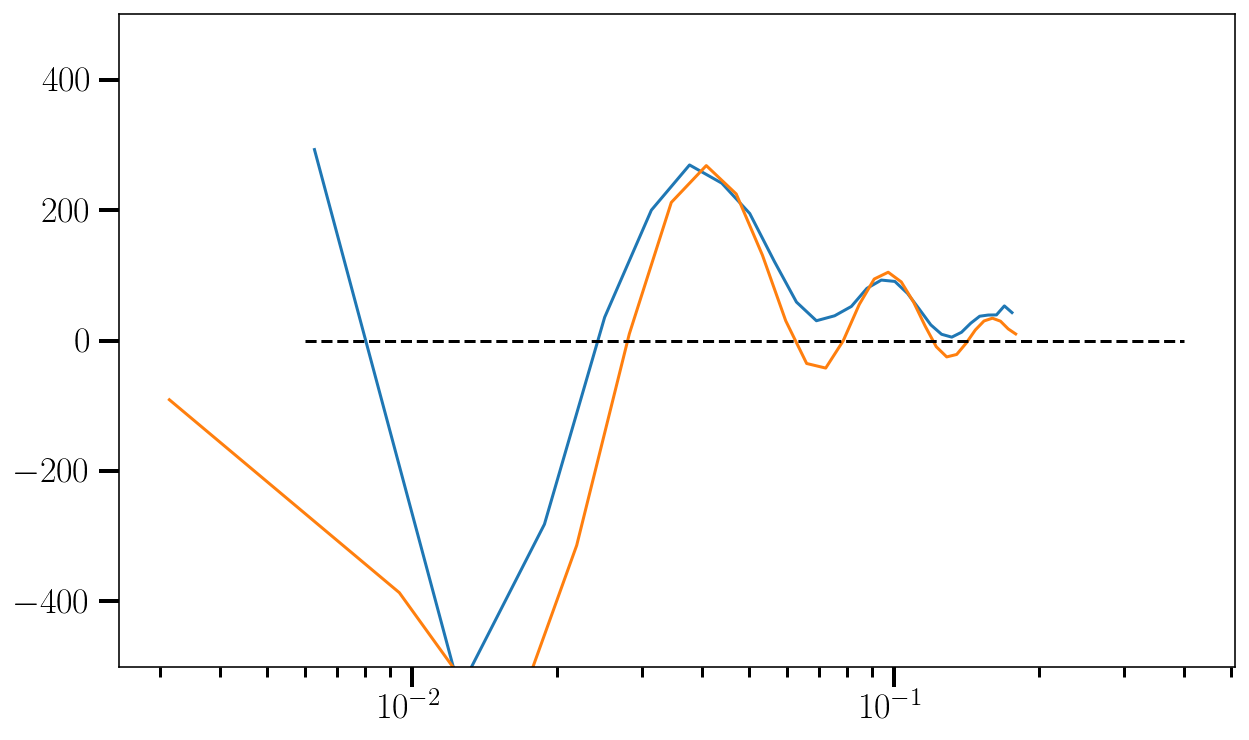

In [1898]:
plt.figure(figsize=(10,6))
plt.plot(k_cen,((1+0.06*np.sqrt(k_cen))*pk_test_64.real-(1+0.06*np.sqrt(k_cen))*mono_real1.real))
plt.plot(k_cen-k_f,1.3e-7*k_cen**(1.5)*(1+0.06*np.sqrt(k_cen))*mono_real1.real*np.gradient(np.gradient(Pk_(k_cen),k_cen),k_cen))

plt.ylim(-500,500)
plt.plot(k_plot,np.zeros(len(k_plot)),'k',linestyle='--')
#plt.plot(k_cen,2e-4*k_cen*np.gradient(np.gradient(Pk_(k_cen),k_cen),k_cen))
#print(((1+0.06*np.sqrt(k_cen))*mono_real1.real))
plt.xscale('log')

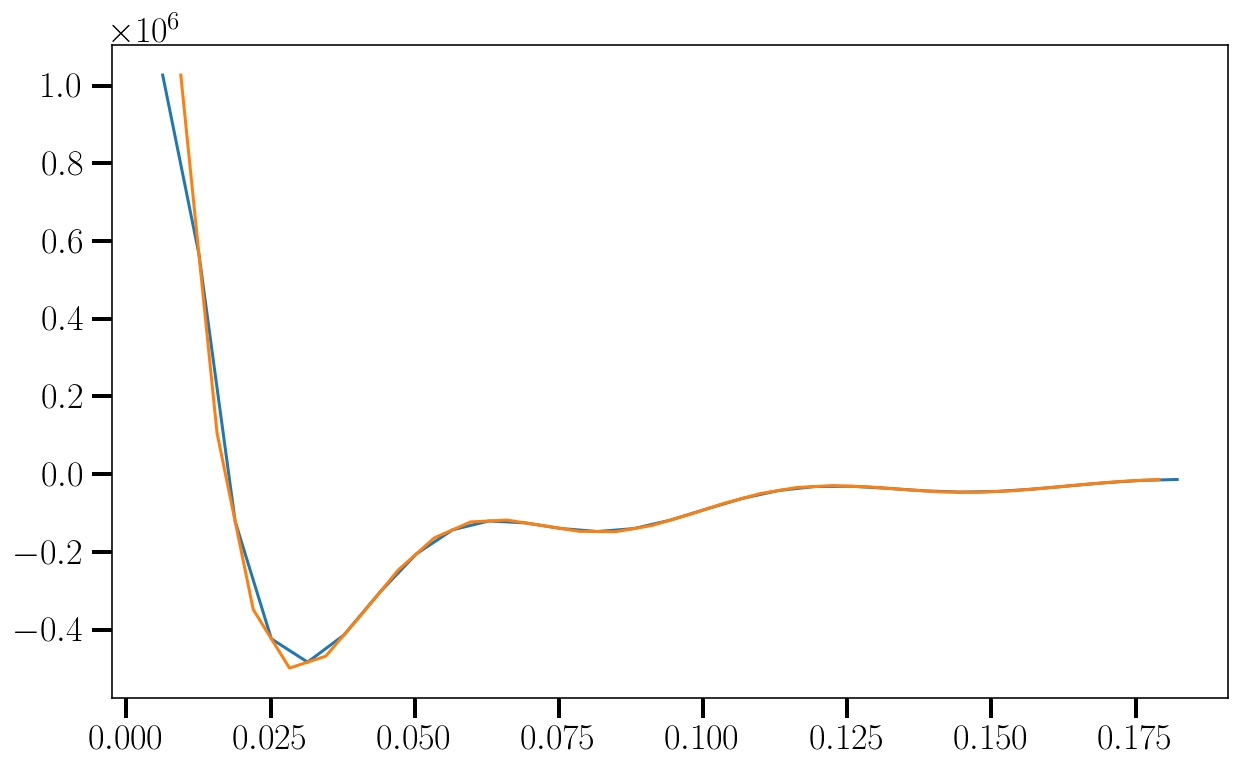

In [1894]:
plt.figure(figsize=(10,6))
plt.plot(k_cen,np.gradient(Pk_(k_cen),k_cen))

plt.plot((k_cen[1:]+k_cen[:-1])/2,(Pk_(k_cen)[1:]-Pk_(k_cen)[:-1])/(np.diff(k_cen)[1]))

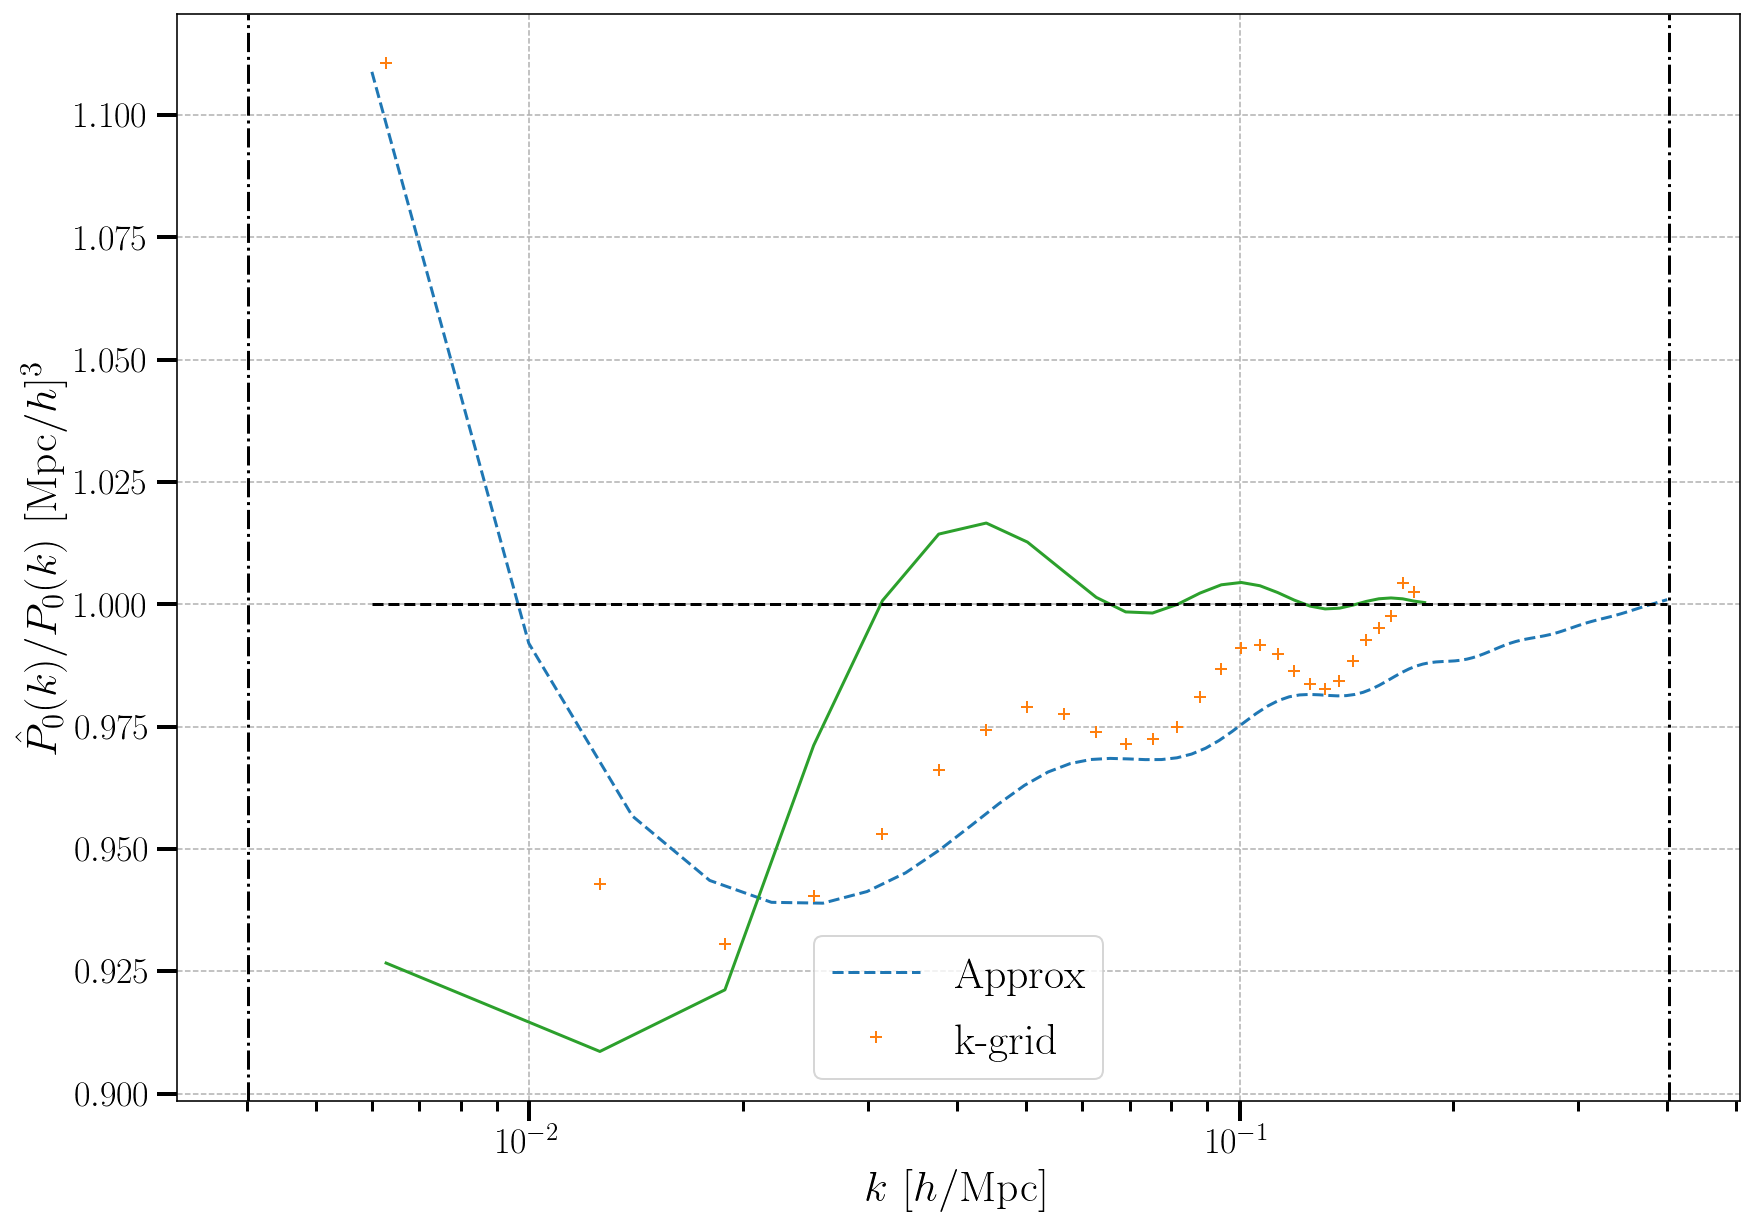

In [1828]:
plt.figure(figsize=(14,10))
plt.plot(k_plot,(1+0.06*np.sqrt(k_plot))*mono_real.real/Pk_(k_plot),'--',label='Approx')
plt.plot(k_cen,(1+0.06*np.sqrt(k_cen))*pk_test_64.real/Pk_(k_cen),'+',label='k-grid')
plt.plot(k_cen,1+1e-9*np.gradient(np.gradient(Pk_(k_cen),k_cen),k_cen))

plt.plot(k_plot,np.ones(len(k_plot)),'k',linestyle='--')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
#plt.xlim(5e-3,0.4e0)
#plt.ylim(1e+3,3e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ \hat{P}_{0}(k)/P_{0}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
#plt.yscale('log')

plt.grid(ls='--',lw=0.75)
plt.legend()

In [1954]:
#quad comparison
quad_approx = plot_convolved(k_plot,2,(0,0,-1e+10),t=0,eta_range=[0,1])

100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


No handles with labels found to put in legend.


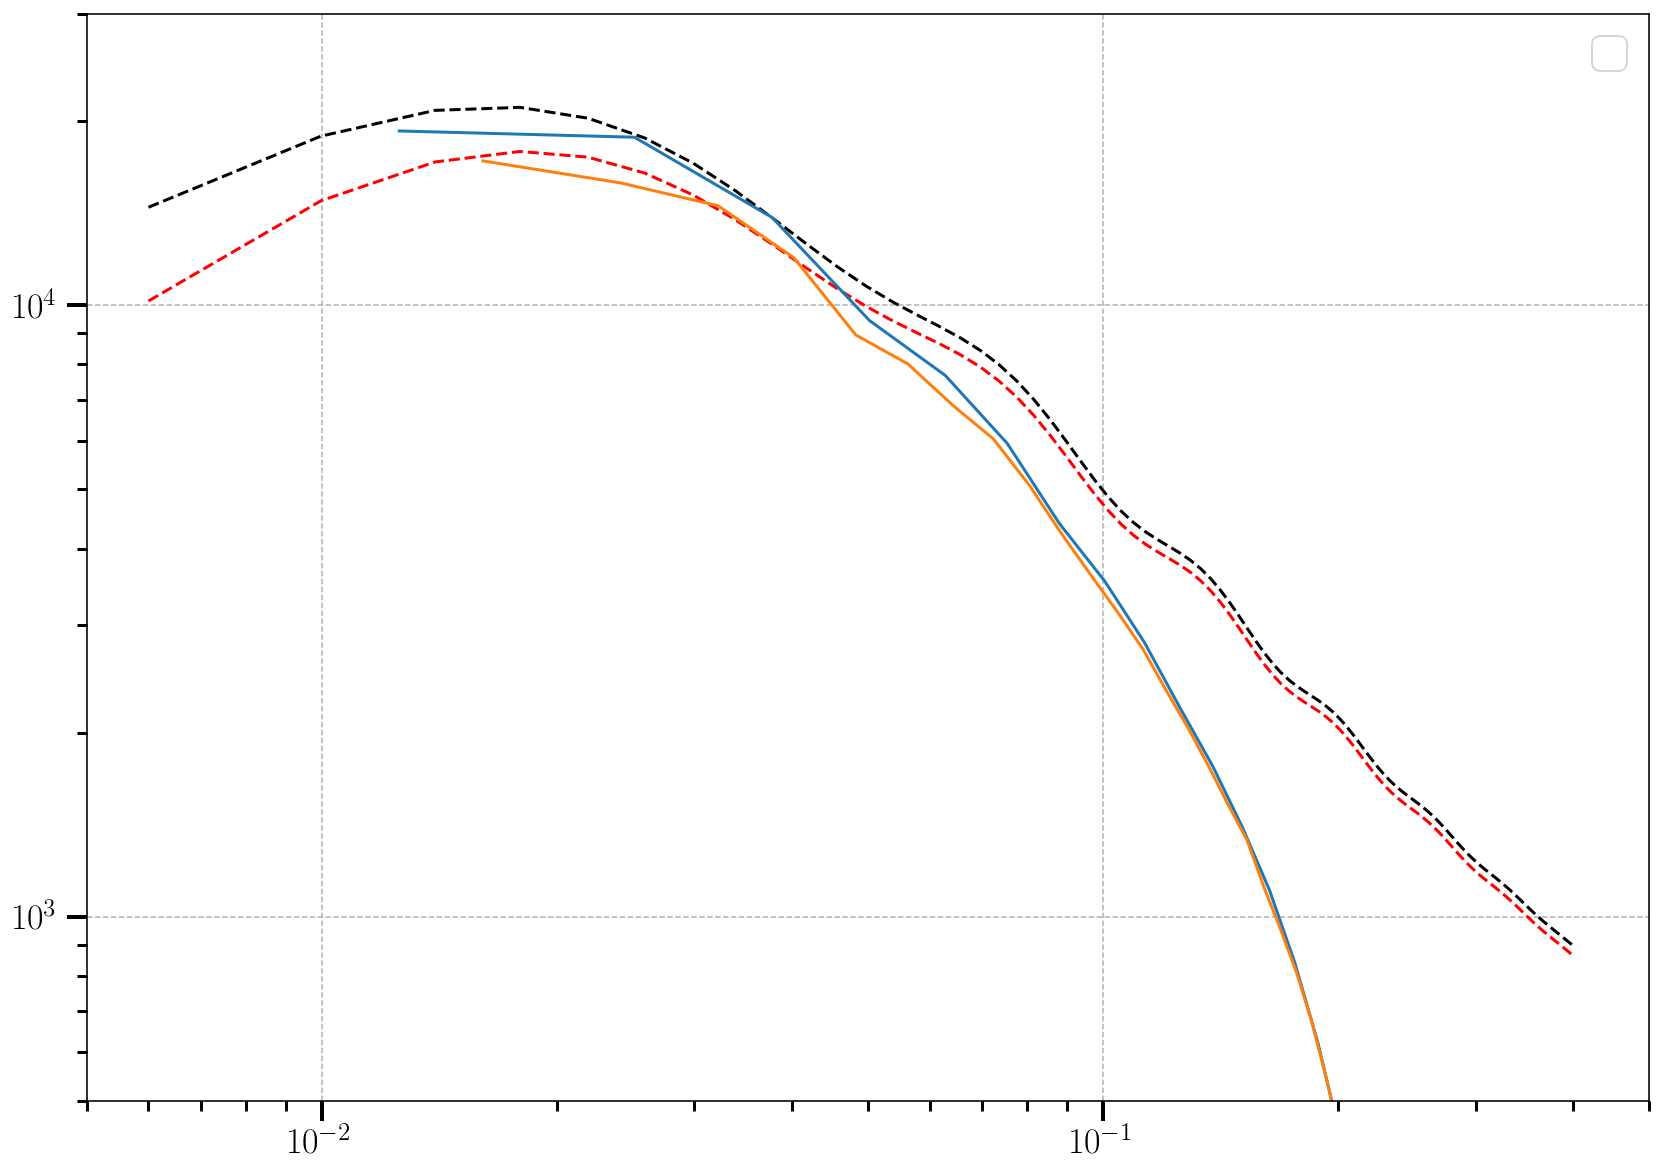

In [2167]:
plt.figure(figsize=(14,10))
plt.plot(k_plot,quad_approx.real,'--',color='red')
plt.plot(k_plot,pk_quad(k_plot,0),'--',color='black')
plt.plot(k_est_up,Pk_quad_sim(k_est_up))
plt.errorbar(k_est[1:-1],(200/128)**3 *(Pk_avg1['PP']['l=2,t=0']).real[1:-1])
#plt.plot(k_cen,pk_quad_8.real)
#plt.plot(k_cen,(1+0.2*np.sqrt(k_cen))*pk_quad_16.real)
#plt.plot(k_cen,pk_quad_32.real)
#plt.plot(k_cen,pk_quad_64.real)
#plt.plot(k_cen,pk_quad_641.real)
plt.xscale('log')
plt.yscale('log')

plt.xlim(5e-3,0.5e0)
plt.ylim(5e+2,3e+4)

plt.grid(ls='--',lw=0.75)
plt.legend()

<ErrorbarContainer object of 3 artists>

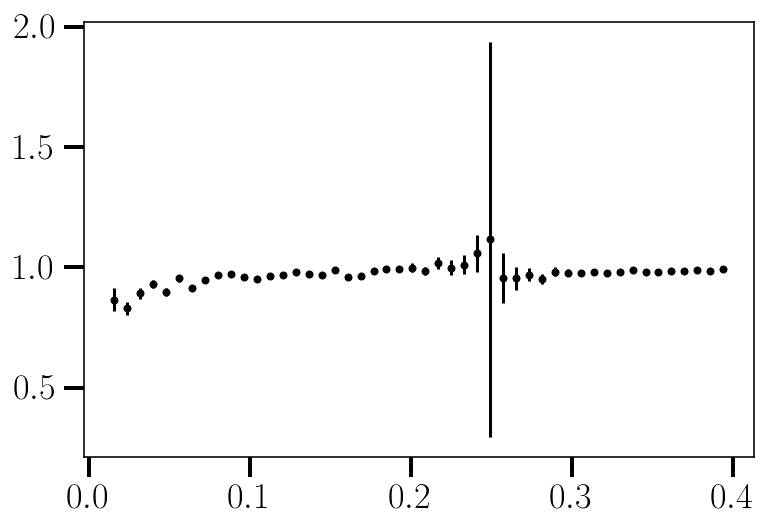

In [2164]:
plt.errorbar(k_est[1:-1],(200/128)**3 *(Pk_avg1['PP']['l=2,t=0']).real[1:-1]/Pk_quad_sim(k_est[1:-1]),yerr=(200/128)**3 *1.5*(Pk_err1[key]['l=2,t=0']).real[1:-1]/Pk_quad_sim(k_est[1:-1]),fmt ='.',color='black',label='FFT')


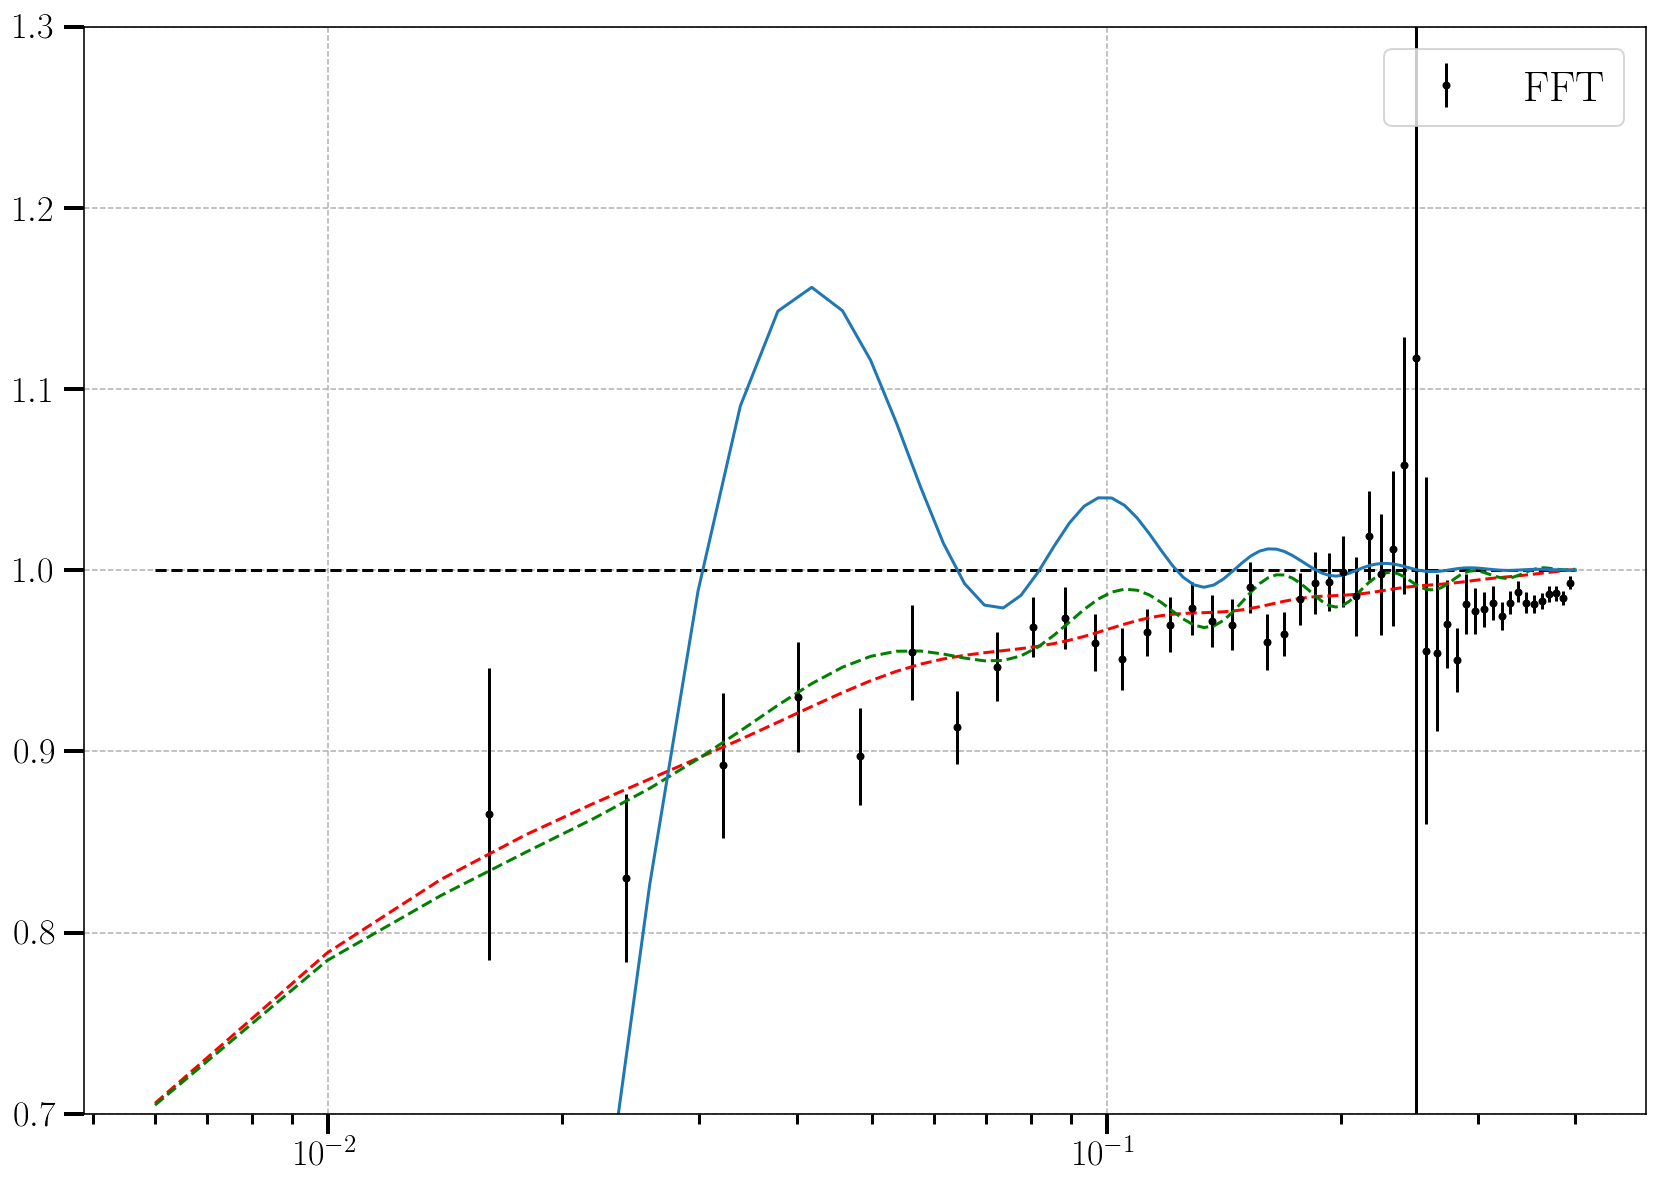

In [2168]:
plt.figure(figsize=(14,10))
plt.plot(k_plot,np.ones_like(k_plot),'--',color='k')
plt.plot(k_plot,(1+0.06*np.sqrt(k_plot))*quad_approx.real/pk_quad(k_plot,0),'--',color='red')
plt.plot(k_plot,(1+5e-7*k_plot**2*np.gradient(np.gradient(pk_quad(k_plot,0),k_plot),k_plot))*(1+0.06*np.sqrt(k_plot))*quad_approx.real/pk_quad(k_plot,0),'--',color='green')
plt.errorbar(k_est[1:-1],(200/128)**3 *(Pk_avg1['PP']['l=2,t=0']).real[1:-1]/Pk_quad_sim(k_est[1:-1]),yerr=(200/128)**3 *1.5*(Pk_err1['PP']['l=2,t=0']).real[1:-1]/Pk_quad_sim(k_est[1:-1]),fmt ='.',color='black',label='FFT')
plt.plot(k_plot,1+1e-8*np.gradient(np.gradient(pk_quad(k_plot,0),k_plot),k_plot))

#plt.plot(k_cen,pk_quad_8.real)
#plt.plot(k_cen,(1+0.2*np.sqrt(k_cen))*pk_quad_16.real/pk_quad(k_cen,0))

plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.7,1.3)
plt.grid(ls='--',lw=0.75)
plt.legend()

In [2141]:
N_side1 = 16
#lets define our grid - similar to quijote grid
k_sample = 2*np.pi*np.fft.fftfreq(N_side1,d=(2000/N_side1))
k_f = k_sample[1]

kx,ky,kz = np.meshgrid(k_sample,k_sample,k_sample,indexing='ij')
k_mag = np.sqrt(kx**2 + ky**2 + kz**2)

#k_cen1 = np.arange(k_f,0.18,2*k_f) + k_f
k_cen = np.arange(k_f,0.18,2*k_f) + k_f #create k bins centers - from k_f to k_ny with steps of 2*k_f

In_bin = np.zeros((len(k_cen),*k_mag.shape),dtype=np.bool_)
for i in range(len(k_cen)): 
    In_bin[i] = np.abs(k_cen[i] - k_mag)<1*k_f

In [2027]:
print(k_sample)

[ 0.00628319  0.01256637  0.01884956  0.02513274  0.03141593  0.03769911
  0.0439823   0.05026548 -0.05026548 -0.0439823  -0.03769911 -0.03141593
 -0.02513274 -0.01884956 -0.01256637 -0.00628319]


In [1702]:
print(k_f)

0.0041887902047863905


In [1691]:
def real_ccc(qs,k_vec):
    qxx = qs[0]+k_vec[0]
    qyy = qs[1]+k_vec[1]
    qzz = qs[2]+k_vec[2]
    kk = np.sqrt(qxx**2 + qyy**2 + qzz**2)
    kk = np.where(kk<1e-4,1e-4,kk)
    return Pk_(kk)
    

In [2041]:
def get_conv_pk():
    #get convolved p(k) from p(k-q)w(q) for a grid of k values
    pk_conv_grid = np.zeros((N_side1,N_side1,N_side1),dtype=np.complex64)
    for ix in tqdm(range(len(k_sample))):
        for iy in range(len(k_sample)):
            for iz in range(len(k_sample)):
                pk_temp = real_ccc(qs,[k_sample[ix],k_sample[iy],k_sample[iz]])
                ifft_field = FFTW_ifft(pk_temp*wq)
                total_pk = np.sum(np.fft.fftshift(ifft_field)[In_window])
                pk_conv_grid[ix,iy,iz] = total_pk
                
    return pk_conv_grid/np.sum(In_window)

test_full64 = get_conv_pk()

100%|██████████| 16/16 [02:07<00:00,  7.94s/it]


In [1988]:
quad_func(Pk_(0.01),qs[2],0.01,0.01,b1=1).max()
#print(qs[2].max())

2467047.9262451795

In [2056]:
@jit(nopython=True)
def quad_func(Pks,nu,kk,ks,b1=1):
    return 4*Pks*f*ks**2*(7*b1*kk**2 + 3*f*(ks**2 + 7*nu**2))/(21*kk**4)

def quad_ccc(qs,k_vec):
    qxx = qs[0]+k_vec[0]
    qyy = qs[1]+k_vec[1]
    qzz = qs[2]+k_vec[2]
    kk = np.sqrt(qxx**2 + qyy**2 + qzz**2)
    ks = np.sqrt(k_vec[0]**2+k_vec[1]**2+k_vec[2]**2)
    kk = np.where(kk<1e-4,1e-4,kk)
    Pks = Pk_(kk)
    return quad_func(Pks,qs[2],ks,ks)

def get_conv_pk_quad():
    #get convolved p(k) from p(k-q)w(q) for a grid of k values
    pk_conv_grid = np.zeros((N_side1,N_side1,N_side1),dtype=np.complex64)
    for ix in tqdm(range(len(k_sample))):
        for iy in range(len(k_sample)):
            for iz in range(len(k_sample)):
                pk_temp = quad_ccc(qs,[k_sample[ix],k_sample[iy],k_sample[iz]])
                ifft_field = FFTW_ifft(pk_temp*wq)
                total_pk = np.sum(np.fft.fftshift(ifft_field)[In_window])
                pk_conv_grid[ix,iy,iz] = total_pk
                
    return pk_conv_grid/np.sum(In_window)
test_quad16 = get_conv_pk_quad()

100%|██████████| 16/16 [02:11<00:00,  8.23s/it]


In [2047]:
print(test_quad16.shape)

(16, 16, 16)


In [2057]:
pk_quad_16= np.zeros((len(k_cen)),dtype=np.complex64)
#pk_real_32= np.zeros((len(k_cen)),dtype=np.complex64)
for i in tqdm(range(len(k_cen))):
    #pk_real_32[i] = np.mean(test_full64[In_bin[i]])
    pk_quad_16[i] = np.mean(test_quad16[In_bin[i]])

100%|██████████| 7/7 [00:00<00:00, 7404.82it/s]


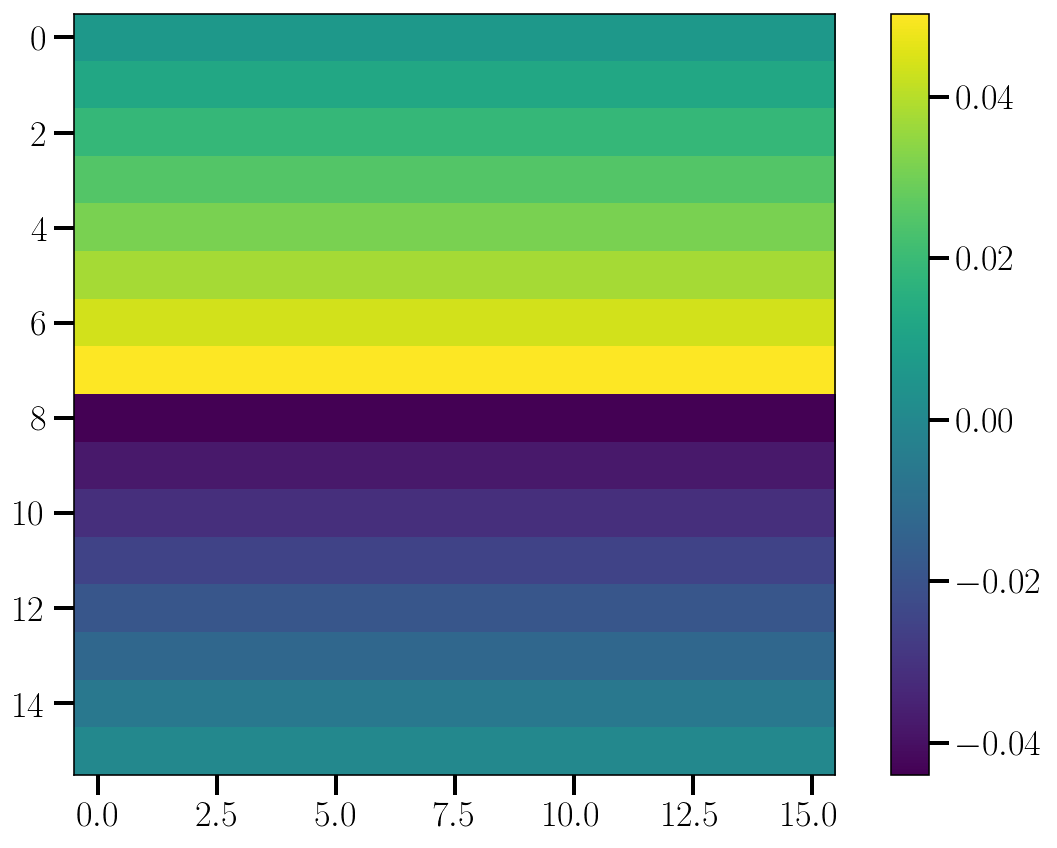

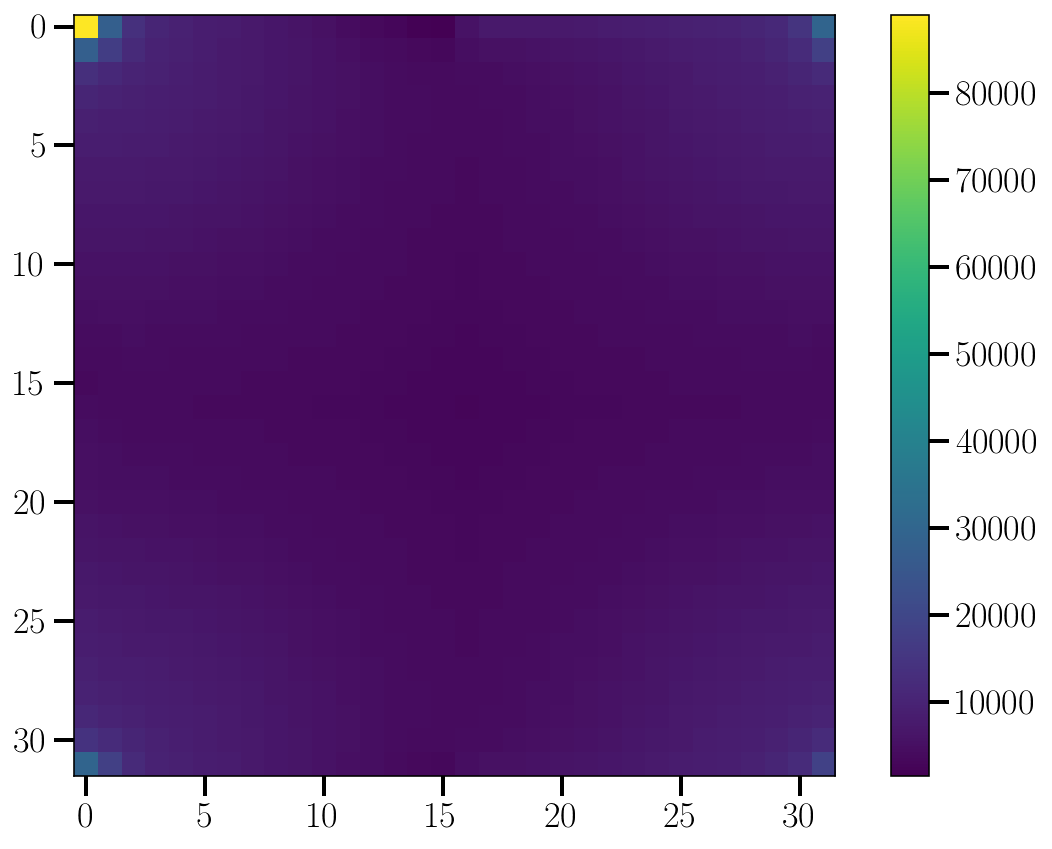

In [2022]:
plt.figure(figsize=(10,7)) 
plt.imshow(kx[:,10,:].real)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,7)) 
plt.imshow(test_quad32[10,:,:].real)
plt.colorbar()
plt.show()

In [2159]:
#lets have a a power spectrum from sim
Pk_sim = interpolate.interp1d(k_est3,(Pk_avg3['real']['l=0'].real),kind='cubic')

#for quad
Pk_quad_sim = interpolate.interp1d(k_est_up,(Pk_avg['PP']['l=2,t=0'].real),kind='cubic')

In [1532]:
#ok overwrite to add some fog do eta=1 only for l=1
#@jit(nopython=True)
def dipo14(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -1j*np.exp(-ks**2*sigma**2)*f*ks*nu**4*(2*t - 1)*(2*Pkd*b1*kk**5*ks**2*sigma**6 - 5*Pkd*b1*kk**5*sigma**4 - 2*Pkd*b1*kk**3*ks**4*sigma**6 + 11*Pkd*b1*kk**3*ks**2*sigma**4 - 10*Pkd*b1*kk**3*sigma**2 + 2*Pkd*f*kk**3*ks**4*sigma**6 - 11*Pkd*f*kk**3*ks**2*sigma**4 + 10*Pkd*f*kk**3*sigma**2 - 2*Pkd*f*kk*ks**6*sigma**6 + 17*Pkd*f*kk*ks**4*sigma**4 - 32*Pkd*f*kk*ks**2*sigma**2 + 10*Pkd*f*kk + 4*Pks*b1*kk**2*ks**4*sigma**6 - 22*Pks*b1*kk**2*ks**2*sigma**4 + 20*Pks*b1*kk**2*sigma**2 - 4*Pks*f*kk**2*ks**4*sigma**6 + 22*Pks*f*kk**2*ks**2*sigma**4 - 20*Pks*f*kk**2*sigma**2 + 8*Pks*f*ks**6*sigma**6 - 68*Pks*f*ks**4*sigma**4 + 128*Pks*f*ks**2*sigma**2 - 40*Pks*f)/(d*kk**6)
#@jit(nopython=True)
def dipo12(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -6*1j*np.exp(-ks**2*sigma**2)*f*ks*nu**2*(2*t - 1)*(Pkd*b1*kk**5*sigma**2 - Pkd*b1*kk**3*ks**2*sigma**2 + Pkd*b1*kk**3 + Pkd*f*kk**3*ks**2*sigma**2 - Pkd*f*kk**3 - Pkd*f*kk*ks**4*sigma**2 + 2*Pkd*f*kk*ks**2 + 2*Pks*b1*kk**2*ks**2*sigma**2 - 2*Pks*b1*kk**2 - 2*Pks*f*kk**2*ks**2*sigma**2 + 2*Pks*f*kk**2 + 4*Pks*f*ks**4*sigma**2 - 8*Pks*f*ks**2)/(d*kk**6)
#@jit(nopython=True)
def dipo10(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 3*1j*np.exp(-ks**2*sigma**2)*f*(2*t - 1)*(4*np.sqrt(np.pi)*Pkd*b1*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*kk**5*sigma**4 - 6*np.sqrt(np.pi)*Pkd*b1*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*kk**3*sigma**2 - 8*Pkd*b1*kk**5*ks*sigma**5 + 8*Pkd*b1*kk**3*ks**3*sigma**5 + 12*Pkd*b1*kk**3*ks*sigma**3 + 6*np.sqrt(np.pi)*Pkd*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*f*kk**3*sigma**2 - 15*np.sqrt(np.pi)*Pkd*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*f*kk - 8*Pkd*f*kk**3*ks**3*sigma**5 - 12*Pkd*f*kk**3*ks*sigma**3 + 8*Pkd*f*kk*ks**5*sigma**5 + 20*Pkd*f*kk*ks**3*sigma**3 + 30*Pkd*f*kk*ks*sigma + 12*np.sqrt(np.pi)*Pks*b1*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*kk**2*sigma**2 - 16*Pks*b1*kk**2*ks**3*sigma**5 - 24*Pks*b1*kk**2*ks*sigma**3 - 12*np.sqrt(np.pi)*Pks*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*f*kk**2*sigma**2 + 60*np.sqrt(np.pi)*Pks*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*f + 16*Pks*f*kk**2*ks**3*sigma**5 + 24*Pks*f*kk**2*ks*sigma**3 - 32*Pks*f*ks**5*sigma**5 - 80*Pks*f*ks**3*sigma**3 - 120*Pks*f*ks*sigma)/(8*d*kk**6*ks**2*sigma**7)

In [1066]:
#quadrupole but dfog (no k+q in exponential)-------------------------------------------------------------------------------------------------------
#@jit(nopython=True)
def quad00(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return -5*Pks*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(8*b1**2*kk**4*ks**2*sigma**6 - 45*f**2 + 6*f*sigma**2*(-6*b1*kk**2 + f*ks**2) - sigma**4*(12*b1**2*kk**4 - 8*b1*f*kk**2*ks**2)) + np.exp(-ks**2*sigma**2)*(90*f**2*ks*sigma + 24*f*ks*sigma**3*(3*b1*kk**2 + 2*f*ks**2) + 8*ks*sigma**5*(3*b1**2*kk**4 + 4*b1*f*kk**2*ks**2 + 2*f**2*ks**4)))/(32*kk**4*ks**3*sigma**7)
#@jit(nopython=True)
def quad02(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return -5*Pks*nu**2*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(16*b1*f*kk**2*ks**2*sigma**6 - 108*f**2*sigma**2 - sigma**4*(24*b1*f*kk**2 - 24*f**2*ks**2)) + 24*np.exp(-ks**2*sigma**2)*f*ks*sigma**3*(2*b1*kk**2*sigma**2 + 4*f*ks**2*sigma**2 + 9*f))/(32*kk**4*ks**3*sigma**7)

#monopole but dfog (no k+q in exponential)-------------------------------------------------------------------------------------------------------
#@jit(nopython=True)
def mono00(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return Pks*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(4*b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 + 3*f**2)/ks + 2*np.exp(-ks**2*sigma**2)*f*sigma*(-3*f - sigma**2*(4*b1*kk**2 + 2*f*ks**2)))/(8*kk**4*sigma**5)
#@jit(nopython=True)
def mono02(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return Pks*nu**2*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(8*b1*f*kk**2*sigma**4 + 12*f**2*sigma**2)/ks - 24*np.exp(-ks**2*sigma**2)*f**2*sigma**3)/(8*kk**4*sigma**5)
#@jit(nopython=True)
def mono04(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return np.sqrt(np.pi)*Pks*scipy.special.erf(sigma*ks)*f**2*nu**4/(2*kk**4*ks*sigma)

In [1413]:
#extra 2nd order terms to monopole and quadrupole (no dfog)
@jit(nopython=True)
def mono20(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return f*(-8*Pks*(7*b1*kk**2*(t*(2*t - 2) + 1)*(15*kk**4 - 25*kk**2*ks**2 + 12*ks**4) + 6*f*(t*(3*t - 3) + 1)*(35*kk**4*ks**2 - 63*kk**2*ks**4 + 30*ks**6)) - 35*kk**4*(2*Pks + kk*(4*Pkd + Pkdd*kk))*(3*b1*kk**2*(t*(2*t - 2) + 1) + f*ks**2*(t*(6*t - 6) + 1)) + 28*kk**2*(2*Pks*(5*b1*kk**2*(3*kk**2 - 2*ks**2)*(t*(2*t - 2) + 1) + 3*f*(1 - 2*t)**2*(5*kk**2*ks**2 - 4*ks**4)) + kk*(Pkd*(5*b1*kk**2*(3*kk**2 + ks**2)*(t*(2*t - 2) + 1) - 3*f*(1 - 2*t)**2*(-5*kk**2*ks**2 + ks**4)) + Pkdd*kk*(5*b1*kk**2*ks**2*(t*(2*t - 2) + 1) + 3*f*ks**4*(1 - 2*t)**2))) + 7*kk**2*(t*(2*t - 2) + 1)*(Pks*(kk + ks)*(30*kk - 30*ks)*(b1*kk**2 + 2*f*ks**2) + kk*(2*Pkd + Pkdd*kk)*(5*b1*kk**2*ks**2 + 3*f*ks**4)) - 2*kk*(2*Pkd*(35*b1*kk**2*(5*kk**2*ks**2 - 3*ks**4)*(t*(2*t - 2) + 1) + 27*f*(7*kk**2*ks**4 - 5*ks**6)*(t*(3*t - 3) + 1)) + 6*Pkdd*kk*(7*b1*kk**2*ks**4*(t*(2*t - 2) + 1) + 5*f*ks**6*(t*(3*t - 3) + 1))))/(105*d**2*kk**8)
@jit(nopython=True)
def mono22(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return f*nu**2*(-8*Pks*(7*b1*kk**2*(-75*kk**2 + 120*ks**2)*(t*(2*t - 2) + 1) + 6*f*(t*(3*t - 3) + 1)*(105*kk**4 - 630*kk**2*ks**2 + 630*ks**4)) - 105*f*kk**4*(2*Pks + kk*(4*Pkd + Pkdd*kk))*(t*(6*t - 6) + 1) + 7*kk**2*(Pks*(-600*f*ks**2 + 30*kk**2*(-3*b1 + 6*f)) + kk*(2*Pkd + Pkdd*kk)*(15*b1*kk**2 + 30*f*ks**2))*(t*(2*t - 2) + 1) + 28*kk**2*(2*Pks*(-30*b1*kk**2*(t*(2*t - 2) + 1) + 3*f*(1 - 2*t)**2*(15*kk**2 - 40*ks**2)) + kk*(Pkd*(15*b1*kk**2*(t*(2*t - 2) + 1) - 3*f*(1 - 2*t)**2*(-15*kk**2 + 10*ks**2)) + Pkdd*kk*(15*b1*kk**2*(t*(2*t - 2) + 1) + 30*f*ks**2*(1 - 2*t)**2))) - 2*kk*(2*Pkd*(35*b1*kk**2*(15*kk**2 - 30*ks**2)*(t*(2*t - 2) + 1) + 27*f*(70*kk**2*ks**2 - 105*ks**4)*(t*(3*t - 3) + 1)) + 6*Pkdd*kk*(70*b1*kk**2*ks**2*(t*(2*t - 2) + 1) + 105*f*ks**4*(t*(3*t - 3) + 1))))/(105*d**2*kk**8)
@jit(nopython=True)
def mono24(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return f*nu**4*(-8*Pks*(420*b1*kk**2*(t*(2*t - 2) + 1) + 6*f*(-315*kk**2 + 1050*ks**2)*(t*(3*t - 3) + 1)) + 7*kk**2*(-300*Pks*f + 15*f*kk*(2*Pkd + Pkdd*kk))*(t*(2*t - 2) + 1) + 28*kk**2*(-120*Pks*f*(1 - 2*t)**2 + kk*(-15*Pkd*f*(1 - 2*t)**2 + 15*Pkdd*f*kk*(1 - 2*t)**2)) - 2*kk*(2*Pkd*(-525*b1*kk**2*(t*(2*t - 2) + 1) + 27*f*(35*kk**2 - 175*ks**2)*(t*(3*t - 3) + 1)) + 6*Pkdd*kk*(35*b1*kk**2*(t*(2*t - 2) + 1) + 175*f*ks**2*(t*(3*t - 3) + 1))))/(105*d**2*kk**8)
@jit(nopython=True)
def mono26(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return f*nu**6*(-10080*Pks*f*(t*(3*t - 3) + 1) - 2*kk*(-1890*Pkd*f*(t*(3*t - 3) + 1) + 210*Pkdd*f*kk*(t*(3*t - 3) + 1)))/(105*d**2*kk**8)

#quad -------------------------------------------------------------------------------------------------- 
@jit(nopython=True)
def quad20(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*f*ks**2*(2*Pks*(-3*b1*kk**2*(21*kk**2 - 32*ks**2)*(2*t**2 - 2*t + 1) + f*(7*kk**4*(18*t**2 - 18*t + 7) - 12*kk**2*ks**2*(66*t**2 - 66*t + 23) + 240*ks**4*(3*t**2 - 3*t + 1))) + kk*(2*Pkd*(b1*kk**2*(49*kk**2 - 60*ks**2)*(2*t**2 - 2*t + 1) - 2*f*(14*kk**4*(3*t**2 - 3*t + 1) - 3*kk**2*ks**2*(60*t**2 - 60*t + 19) + 45*ks**4*(3*t**2 - 3*t + 1))) + Pkdd*kk*(b1*kk**2*(-35*kk**2 + 24*ks**2)*(2*t**2 - 2*t + 1) + f*(7*kk**4*(6*t**2 - 6*t + 1) - 6*kk**2*ks**2*(18*t**2 - 18*t + 5) + 20*ks**4*(3*t**2 - 3*t + 1)))))/(21*d**2*kk**8)
@jit(nopython=True)
def quad22(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*f*ks**2*nu**2*(2*Pks*(672*b1*kk**2*(2*t**2 - 2*t + 1) + f*(-84*kk**2*(66*t**2 - 66*t + 23) + 4320*ks**2*(3*t**2 - 3*t + 1))) + kk*(2*Pkd*(-420*b1*kk**2*(2*t**2 - 2*t + 1) - 2*f*(-21*kk**2*(60*t**2 - 60*t + 19) + 810*ks**2*(3*t**2 - 3*t + 1))) + Pkdd*kk*(168*b1*kk**2*(2*t**2 - 2*t + 1) + f*(-42*kk**2*(18*t**2 - 18*t + 5) + 360*ks**2*(3*t**2 - 3*t + 1)))))/(21*d**2*kk**8)
@jit(nopython=True)
def quad24(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*f*ks**2*nu**4*(10080*Pks*f*(3*t**2 - 3*t + 1) + kk*(-3780*Pkd*f*(3*t**2 - 3*t + 1) + 420*Pkdd*f*kk*(3*t**2 - 3*t + 1)))/(21*d**2*kk**8)

## Convolved theory

In [1981]:
N_side_th = 64
L_th =2000#size of box for the convolution
Lwin =1000#size of window
f_s = L_th/Lwin #ratio of box to window
#define q grid #change the grid so have larger freq
q_sample = 2*np.pi*np.fft.fftfreq(N_side_th,d=(L_th/N_side_th))
qx,qy,qz = np.meshgrid(q_sample,q_sample,q_sample,indexing='ij')
q_norm = np.sqrt(qx**2+qy**2+qz**2)
q_norm = np.where(q_norm==0,1,q_norm)

#define d grid
d_sample = np.linspace(0,L_th,N_side_th)
dx,dy,dz = np.meshgrid(d_sample-L_th/2,d_sample-L_th/2,d_sample-L_th/2,indexing='ij')#these will be coordinates of the box and not of the observer

#lets create bool in the real space dimensions whether the voxel in the window or not...
In_window = np.where(np.logical_and(np.logical_and(np.abs(dx)<Lwin/2,np.abs(dy)<Lwin/2),np.abs(dz)<Lwin/2),True,False)

d_vec = np.array([dx,dy,dz])
qs = np.array([qx,qy,qz])

#get the window from the analytical FT of the cubic box...
def get_Wq(q_vec):
    L =1000
    return np.sinc(L*q_vec[0]/(2*np.pi))*np.sinc(L*q_vec[1]/(2*np.pi))*np.sinc(L*q_vec[2]/(2*np.pi))#(L/2)**3
wq = get_Wq([qx,qy,qz])*(N_side_th/f_s)**3#this is the correct normalisation when you ifft back
#print(np.sum(np.fft.ifftn(wq))/(N_side_th/f_s)**3)

In [295]:
#d_vec[2]+= 1000

d_norm = np.sqrt(np.sum(d_vec**2,axis=0))
d_hat= (d_vec)/d_norm
print(np.mean(d_hat[0]))

2.42861286636753e-17


In [296]:
real1,four1 = nu_terms(1,d_hat,qs)
test = np.zeros_like(real[0])
for i in range(len(real)):
    test += real[i]*four[i]

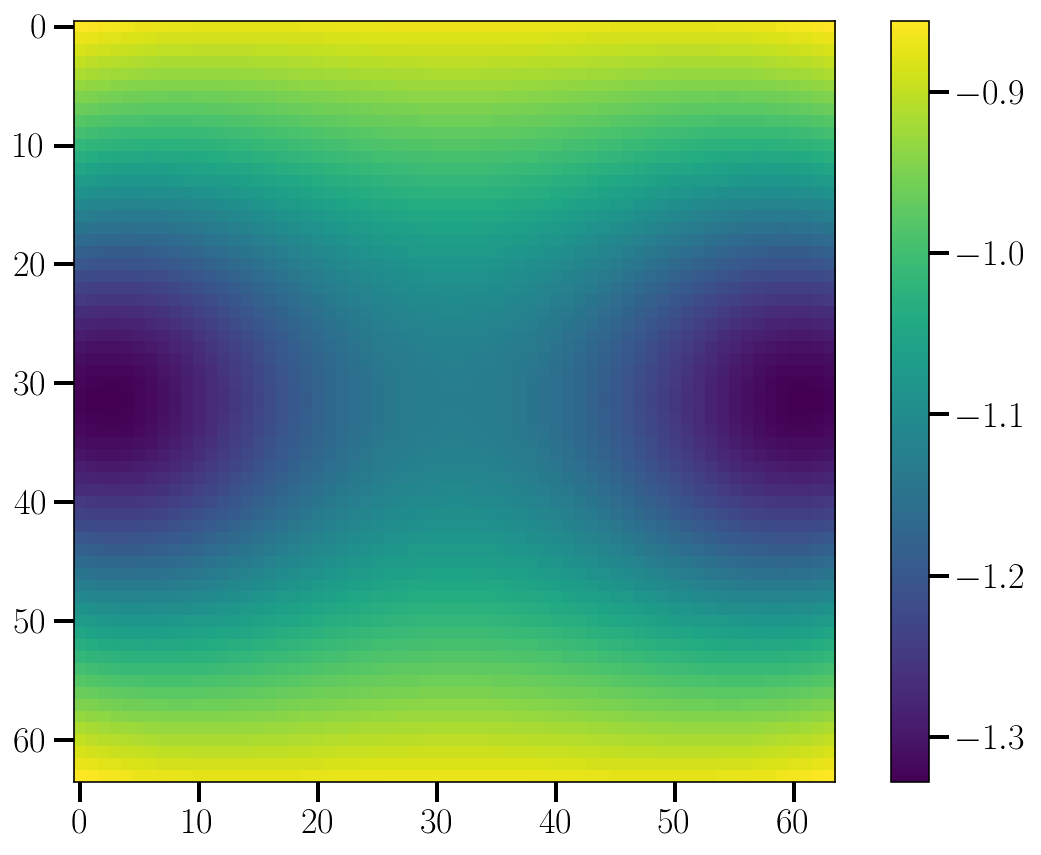

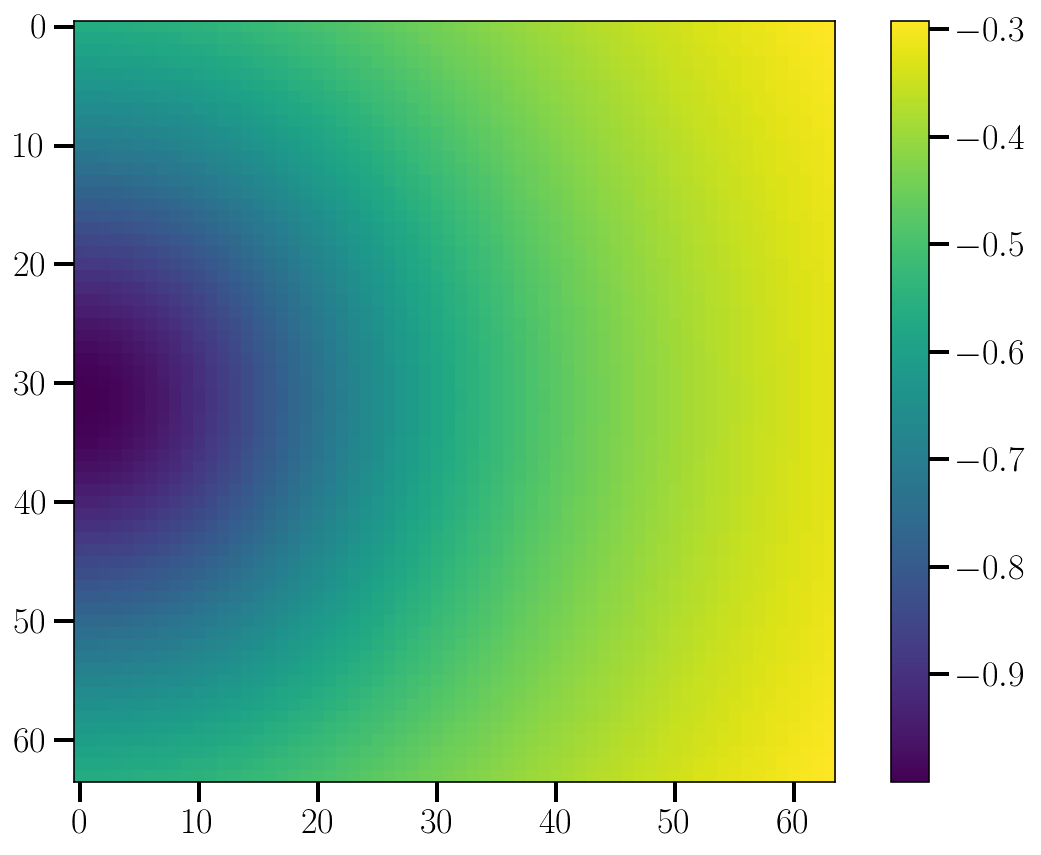

In [399]:
from matplotlib import colors
plt.figure(figsize=(10,7)) 
plt.imshow(real[0][10,:,:].real+real1[0][10,:,:].real)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,7)) 
plt.imshow(real1[0][10,:,:].real)
plt.colorbar()
plt.show()

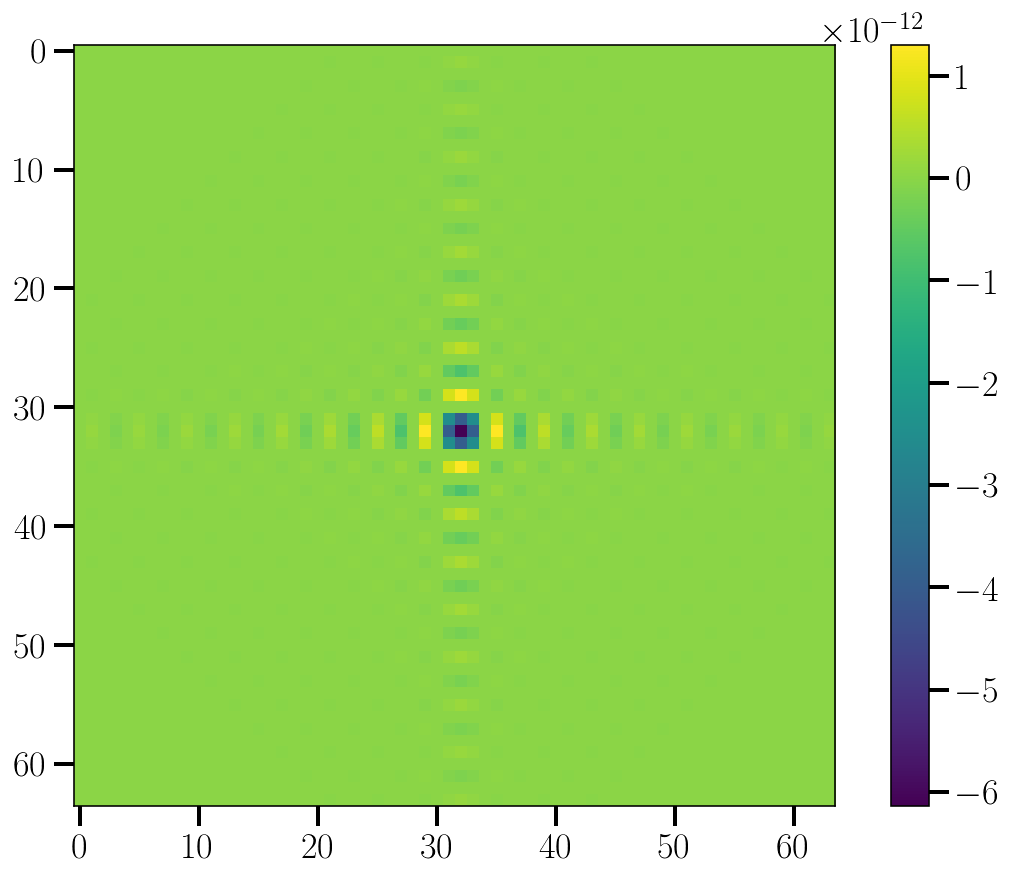

In [1663]:
plt.figure(figsize=(10,7)) 
plt.imshow(np.fft.fftshift(wq.real[10]))
plt.colorbar()
plt.show()

In [1950]:
def get_pkfunc(l,eta,nu,verbose,*args):
    """Call functions which contains parts of pk"""
    #define which multipole
    if l==0:
        base = 'mono'
    elif l==1:
        base = 'dipo'
    elif l==2:
        base = 'quad'
    elif l==3:
        base = 'octo'
        
    function_name = base + f"{eta}{nu}" #get name of required function
    func_temp = globals().get(function_name)#get function defined previously of said name
    if func_temp==None:
        if verbose==True:
            print('No function for given values-'+base +f'{eta}{nu}')
        return [0]
    else:
        return func_temp(*args)
    
def nu_terms(n,d_hat,q_vec):
    """Do the expansion of nu = q.d and return the fourier and real space components seperately.
    Expansion is implemented similar to code in estimator"""
    
    ind = np.array(list(combinations_with_replacement(np.arange(3), n)))
    
    #create arrays of coefficients that are paired together for the sum
    d_prod = np.zeros((len(ind),*d_hat[0].shape))
    q_prod = np.zeros((len(ind),*d_hat[0].shape))
    for i,inds in enumerate(ind):
        d_prod[i] = bf.count_distinct_permutations(inds)*np.prod(d_hat[inds],axis=0)
        q_prod[i] = np.prod(q_vec[inds],axis=0)

    return d_prod,q_prod

def collect_pkconv(l,q_vec,d_vec,obs_pos,ks,t=0,eta_range=[0,4],verbose=False):
    """Will collate the convolved monopole from all terms with wide-angle corrections outside of the PP
    Different sections for differents orders of the expansion and different powers of nu"""
    d_vec = np.array([d_vec[i] - obs_pos[i] for i in range(3)]) #input observer
    d_norm = np.sqrt(np.sum(d_vec**2,axis=0))
    d_norm = np.where(d_norm==0,1,d_norm) #avoid 0 errors
    d_hat = d_vec/d_norm
    
    #do set up
    #kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2 + 2*ks*np.sqrt(q_vec[0]**2+q_vec[1]**2+q_vec[2]**2))
    kk = np.sqrt(ks**2 + q_vec[0]**2+q_vec[1]**2+q_vec[2]**2)
    kk = np.where(kk<1e-4,1e-4,kk)
    #get pks
    Pks = Pk_(kk)
    Pkd = Pk_d(kk)
    Pkdd = Pk_dd(kk)
    Pkddd = Pk_ddd(kk)
    
    pk_conv = np.complex64(0)#define pk_conv
    
    #lets think about a function
    def nu_func(pk_conv,eta,nu):
        """So here we compute the addition of any arbitary nu^n term at any order in eta"""
        
        temps_args = (Pks,Pkd,Pkdd,Pkddd,kk,ks,t)
            
        pk_terms_temp = get_pkfunc(l,eta,nu,verbose,*temps_args)#call required terms of pk
        if len(pk_terms_temp)==1: #for when there be no terms
            return pk_conv
        
        if nu == 0:    #nu0 terms
            pk_temp = FFTW_ifft(pk_terms_temp*wq)
            pk_conv += np.sum((np.fft.fftshift(pk_temp)/(d_norm**eta))[In_window])
        else: #nu != 0
            real_arr,fourier_arr = nu_terms(nu,d_hat,q_vec)
            for i in range(real_arr.shape[0]):
                pk_temp = FFTW_ifft(fourier_arr[i]*pk_terms_temp*wq) #ifft
                pk_conv += np.sum((real_arr[i]*np.fft.fftshift(pk_temp)/(d_norm**(eta)))[In_window]) #sum parts in window
        return pk_conv

    for eta in range(eta_range[0],eta_range[1]):
        for nu in range(0,3):
            pk_conv = nu_func(pk_conv,eta,nu)

    return pk_conv/np.sum(In_window)
pk_temp = collect_pkconv(1,qs,d_vec,(0,0,1000),0.05,0,[0,1],True)
#pk_temp1 = collect_pkconv(1,qs,d_vec,(0,0,-1000),0.05,0,True)

No function for given values-dipo00
No function for given values-dipo02


In [751]:
print(collect_pkconv(1,qs,d_vec,(0,0,1000),0.01,0,[0,4],True))
print(collect_pkconv(1,qs,d_vec,(0,0,-1000),0.01,0,[0,4],True))

No function for given values-dipo00
No function for given values-dipo20
-1061.7631106150102j
No function for given values-dipo00
No function for given values-dipo20
-1052.7432813781475j


In [752]:
def plot_convolved(k_plot,l,obs_pos=(0,0,0),t=0,eta_range=[0,3]):
    plots = np.zeros(len(k_plot),dtype=np.complex64)
    for i in tqdm(range(len(k_plot))):
        plots[i]= (collect_pkconv(l,qs,d_vec,obs_pos,k_plot[i],t,eta_range))
    return plots


In [904]:
kk_ = np.linspace(0.006,0.15,20)
temp_pk2 = plot_convolved(kk_,1,(0,0,0),t=0,eta_range=[1,2])

100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


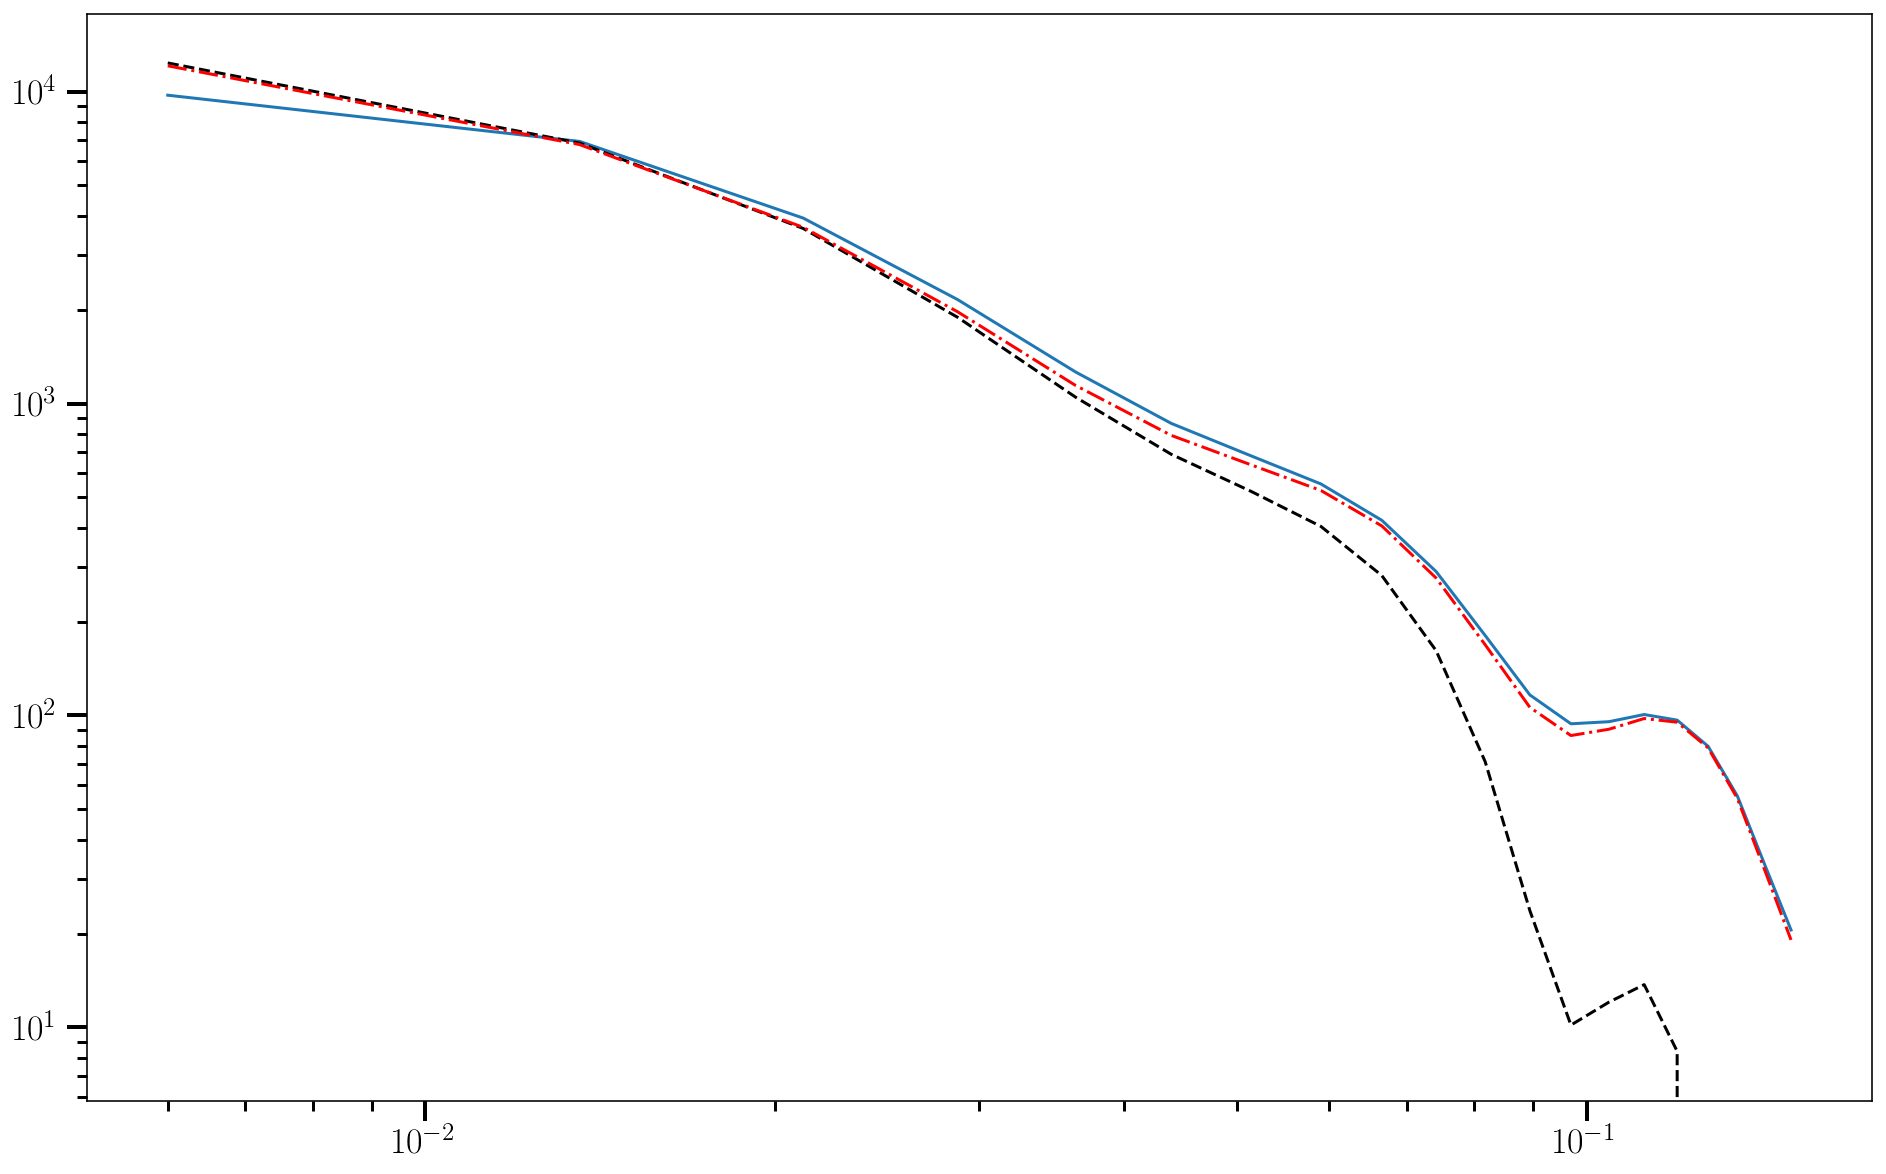

In [938]:
plt.figure(figsize=(16,10))
plt.plot(kk_,-temp_pk.imag)
#plt.plot(kk_,-temp_pk5.imag)

#plt.plot(kk_,-temp_pk1.imag)
#plt.plot(kk_,-temp_pk2.imag)
#plt.plot(kk_,-temp_pk3.imag)
#plt.plot(kk_,-temp_pk1.imag,linestyle='-.')
plt.plot(kk_, -(pk_dipo_dfog_wa(kk_,5,420,0).imag),color='black',linestyle='--')
plt.plot(kk_,pk_dipo(kk_,430,0),'-.',color= 'red')

plt.yscale('log')
plt.xscale('log')

In [562]:
kk_ = np.linspace(0.006,0.15,20)
temp_pk_256 = plot_convolved(kk_,1,(0,0,1000))
temp_pk1_256 = plot_convolved(kk_,1,(0,0,-1000))

100%|██████████| 20/20 [02:41<00:00,  8.10s/it]


No handles with labels found to put in legend.


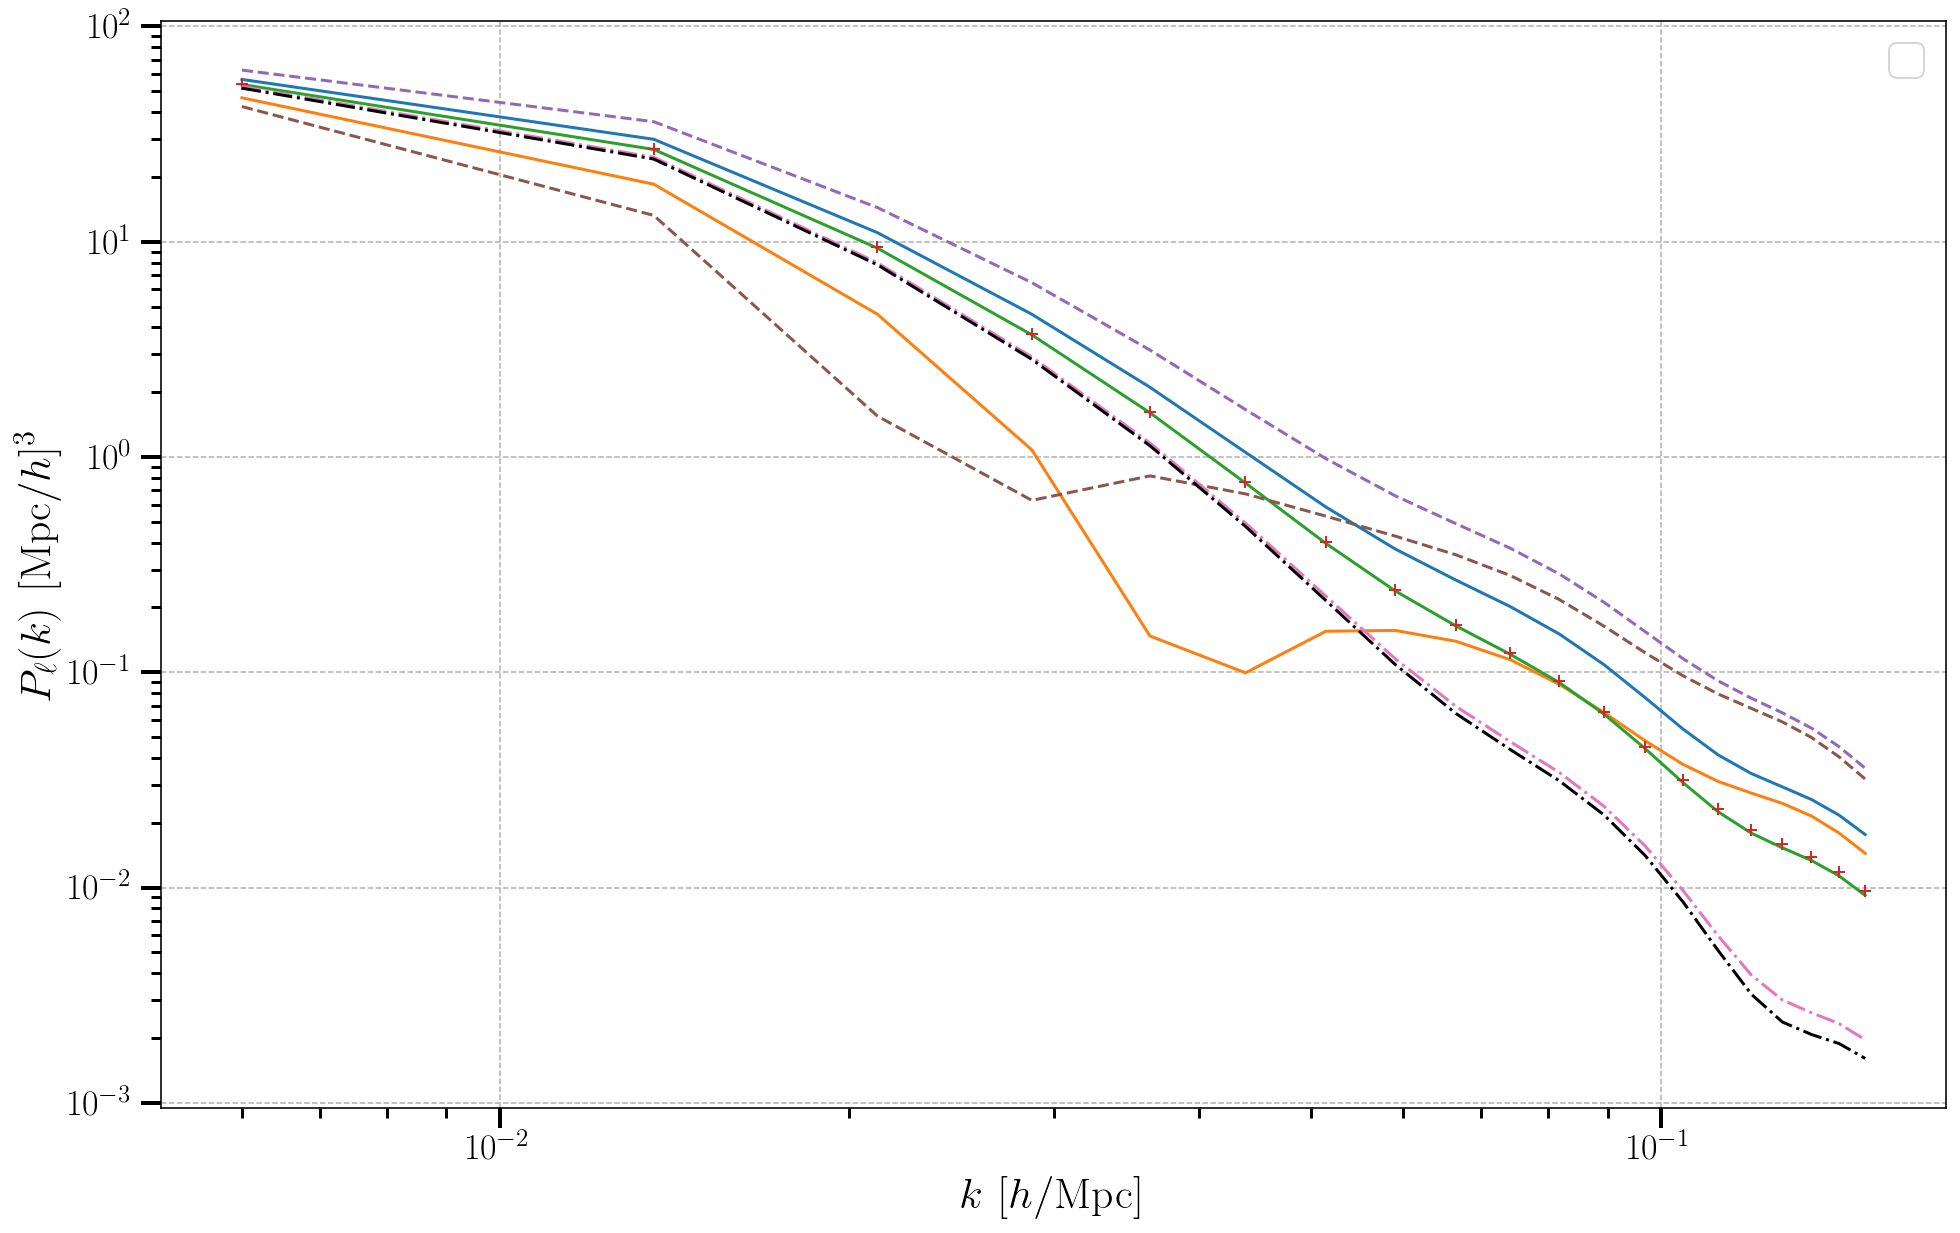

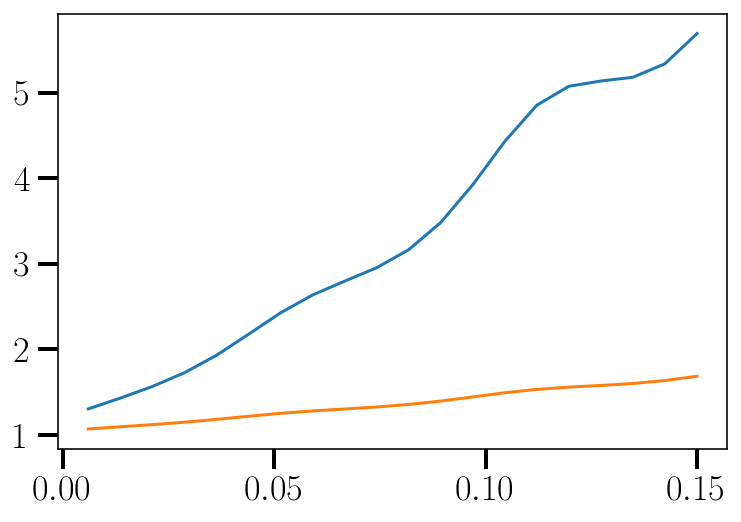

In [569]:
plt.figure(figsize=(16,10))
plt.plot(kk_,np.abs(temp_pk_128.imag))
plt.plot(kk_,np.abs(temp_pk1_128.imag))

plt.plot(kk_,np.abs(temp_pk_256.imag))
#plt.plot(kk_,np.abs(temp_pk1_256.imag))
plt.plot(kk_,(np.abs(temp_pk_128.imag)-np.abs(temp_pk1_128.imag+temp_pk_128.imag)/2)/2+np.abs(temp_pk1_128.imag+temp_pk_128.imag)/2,'+')
plt.plot(kk_,np.abs(temp_pk_64.imag),'--')
plt.plot(kk_,np.abs(temp_pk1_64.imag),'--')
plt.plot(kk_,np.abs(temp_pk1_64.imag+temp_pk_64.imag)/2,'-.')
plt.plot(kk_,np.abs(temp_pk1_128.imag+temp_pk_128.imag)/2,'-.',color='black')
#plt.plot(kk_,np.abs(temp_pk1_256.imag+temp_pk_256.imag)/2,'-.',color='red')
#plt.plot(kk_,-pk_dipo_dfog_wa(kk_,5,427,0).imag)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{\ell}(k)\,\,[\mathrm{Mpc}/h]^3$')
plt.legend()
plt.grid(ls='--',lw=0.75)
plt.show()
#A = (temp_pk.imag)/(temp_pk1.imag)
plt.plot(kk_,A)
plt.plot(kk_,(temp_pk.imag)/(temp_pk1.imag))


In [1929]:
#convolved theory - Plane parallel---------------------------------------------
@jit(nopython=True)
def mono_func(Pks,kk,ks,nu,b1=1):
    return Pks*b1**2 + 2*Pks*b1*f*(ks**2 + 3*nu**2)/(3*kk**2) + Pks*f**2*(ks**4 + 10*ks**2*nu**2 + 5*nu**4)/(5*kk**4)
def pk_mono_conv_pp1(qs,ks,t=0,b1=1):
    kk = np.sqrt(ks**2 + qs[0]**2+qs[1]**2+qs[2]**2)
    nu = qs[2]
    Pks = Pk_(kk)
    
    return  mono_func(Pks,kk,ks,nu,b1)

@jit(nopython=True)
def quad_func(Pks,nu,kk,ks,b1=1):
    return 4*Pks*f*ks**2*(7*b1*kk**2 + 3*f*(ks**2 + 7*nu**2))/(21*kk**4)
def pk_quad_conv_pp1(qs,ks,t=0,b1=1):
    kk = np.sqrt(ks**2 + qs[0]**2+qs[1]**2+qs[2]**2)
    nu = qs[2]
    Pks = Pk_(kk)
    
    return quad_func(Pks,nu,kk,ks)

In [1930]:
#PP
pk_quad= np.zeros((len(k_est)),dtype=np.complex64)
pk_mono= np.zeros((len(k_est)),dtype=np.complex64)
for i in tqdm(range(len(k_est))):
    pk1_temp = np.fft.ifftn(pk_quad_conv_pp1(qs,k_est[i])*wq)
    pk_quad[i] =np.sum(np.fft.fftshift(pk1_temp)[int(N_side_th//2-N_side_th//(f_s*2)):int(N_side_th//2+N_side_th//(f_s*2)),int(N_side_th//2-N_side_th//(f_s*2)):int(N_side_th//2+N_side_th//(f_s*2)),int(N_side_th//2-N_side_th//(f_s*2)):int(N_side_th//2+N_side_th//(f_s*2))])/(N_side_th/f_s)**3
    pk1_temp = np.fft.ifftn(pk_mono_conv_pp1(qs,k_est[i])*wq)
    pk_mono[i] =np.sum(np.fft.fftshift(pk1_temp)[int(N_side_th//2-N_side_th//(f_s*2)):int(N_side_th//2+N_side_th//(f_s*2)),int(N_side_th//2-N_side_th//(f_s*2)):int(N_side_th//2+N_side_th//(f_s*2)),int(N_side_th//2-N_side_th//(f_s*2)):int(N_side_th//2+N_side_th//(f_s*2))])/(N_side_th/f_s)**3


100%|██████████| 50/50 [00:02<00:00, 17.17it/s]


In [ ]:
#%%time
t=0.5
import cProfile
cProfile.run('Pk.Pk(field_tmp,L,Nside,l,k,grid_info,binning_info, t,iFFT,dtype,threads,rfft,verbose)')

In [1588]:
#extra octupole which has been added to conv_funcs
#second
@jit(nopython=True)
def octo21(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*f*ks**3*nu*(12*Pks*(8*b1*kk**2*(t*(2*t - 2) + 1) + f*kk**2*(-t*(66*t - 66) - 23) + 40*f*ks**2*(t*(3*t - 3) + 1)) + kk*(-6*Pkd*(10*b1*kk**2*(t*(2*t - 2) + 1) + f*kk**2*(-t*(60*t - 60) - 19) + 30*f*ks**2*(t*(3*t - 3) + 1)) + Pkdd*kk*(12*b1*kk**2*(t*(2*t - 2) + 1) - 3*f*kk**2*(t*(18*t - 18) + 5) + 20*f*ks**2*(t*(3*t - 3) + 1))))/(15*d**2*kk**8)
@jit(nopython=True)
def octo23(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*f*ks**3*nu**3*(1440*Pks*f*(t*(3*t - 3) + 1) + kk*(-540*Pkd*f*(t*(3*t - 3) + 1) + 60*Pkdd*f*kk*(t*(3*t - 3) + 1)))/(15*d**2*kk**8)
#third
@jit(nopython=True)
def octo30(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*1j*f*ks**3*(2*t - 1)*(3*Pkd*kk*(44*b1*kk**2*(48*kk**2 - 55*ks**2)*(t**2 - t + 1) - 3*f*(11*kk**4*(162*t**2 - 162*t + 79) - 110*kk**2*ks**2*(53*t**2 - 53*t + 26) + 2030*ks**4*(2*t**2 - 2*t + 1))) - 264*Pks*b1*kk**2*(33*kk**2 - 40*ks**2)*(t**2 - t + 1) + 72*Pks*f*(44*kk**4*(9*t**2 - 9*t + 5) - 55*kk**2*ks**2*(27*t**2 - 27*t + 14) + 560*ks**4*(2*t**2 - 2*t + 1)) + kk**2*(-3*Pkdd*(660*b1*kk**2*(kk**2 - ks**2)*(t**2 - t + 1) - 33*f*kk**4*(38*t**2 - 38*t + 15) + 110*f*kk**2*ks**2*(31*t**2 - 31*t + 14) - 1050*f*ks**4*(2*t**2 - 2*t + 1)) + Pkddd*kk*(11*b1*kk**2*(27*kk**2 - 20*ks**2)*(t**2 - t + 1) - 3*f*(33*kk**4*(1 - 2*t)**2 - 55*kk**2*ks**2*(5*t**2 - 5*t + 2) + 70*ks**4*(2*t**2 - 2*t + 1)))))/(495*d**3*kk**10)
@jit(nopython=True)
def octo32(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*1j*f*ks**3*nu**2*(2*t - 1)*(3*Pkd*kk*(-21780*b1*kk**2*(t**2 - t + 1) - 3*f*(-990*kk**2*(53*t**2 - 53*t + 26) + 44660*ks**2*(2*t**2 - 2*t + 1))) + 95040*Pks*b1*kk**2*(t**2 - t + 1) + 72*Pks*f*(-495*kk**2*(27*t**2 - 27*t + 14) + 12320*ks**2*(2*t**2 - 2*t + 1)) + kk**2*(-3*Pkdd*(-5940*b1*kk**2*(t**2 - t + 1) + 990*f*kk**2*(31*t**2 - 31*t + 14) - 23100*f*ks**2*(2*t**2 - 2*t + 1)) + Pkddd*kk*(-1980*b1*kk**2*(t**2 - t + 1) - 3*f*(-495*kk**2*(5*t**2 - 5*t + 2) + 1540*ks**2*(2*t**2 - 2*t + 1)))))/(495*d**3*kk**10)
@jit(nopython=True)
def octo34(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -8*1j*f*ks**3*nu**4*(2*t - 1)*(-602910*Pkd*f*kk*(2*t**2 - 2*t + 1) + 1330560*Pks*f*(2*t**2 - 2*t + 1) + kk**2*(103950*Pkdd*f*(2*t**2 - 2*t + 1) - 6930*Pkddd*f*kk*(2*t**2 - 2*t + 1)))/(495*d**3*kk**10)


In [1547]:
#dipole -------------------------------------------------------------------------------------------------------
@jit(nopython=True)
def dipo01(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return 4*Pks*f*ks*(5*b1*kk**2 + 3*f*ks**2)/(5*kk**4)
@jit(nopython=True)
def dipo03(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1):
    return 4*Pks*f**2*ks*nu**3/kk**4
#1st order ----------------------------------
@jit(nopython=True)
def dipo14(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -10*1j*f**2*ks*nu**4*(2*t - 1)*(Pkd*kk - 4*Pks)/(d*kk**6)
@jit(nopython=True)
def dipo12(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 6*1j*f*ks*nu**2*(2*t - 1)*(-Pkd*b1*kk**3 + Pkd*f*kk**3 - 2*Pkd*f*kk*ks**2 + 2*Pks*b1*kk**2 - 2*Pks*f*kk**2 + 8*Pks*f*ks**2)/(d*kk**6)
@jit(nopython=True)
def dipo10(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*(2*t - 1)*(Pkd*kk*(35*b1*kk**4 - 21*b1*kk**2*ks**2 + 21*f*kk**2*ks**2 - 15*f*ks**4) + Pks*(60*f*ks**4 + kk**2*ks**2*(42*b1 - 42*f)))/(35*d*kk**6)
#2nd order --------------------------------
@jit(nopython=True)
def dipo25(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return -2*f*ks*nu**5*(-3780*Pkd*f*kk*(3*t**2 - 3*t + 1) + 420*Pkdd*f*kk**2*(3*t**2 - 3*t + 1) + 10080*Pks*f*(3*t**2 - 3*t + 1))/(35*d**2*kk**8)
@jit(nopython=True)
def dipo23(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return - 2*f*ks*nu**3*(2*Pkd*kk*(-700*b1*kk**2*(2*t**2 - 2*t + 1) - 2*f*(-35*kk**2*(60*t**2 - 60*t + 19) + 1890*ks**2*(3*t**2 - 3*t + 1))) + Pkdd*kk**2*(280*b1*kk**2*(2*t**2 - 2*t + 1) + f*(-70*kk**2*(18*t**2 - 18*t + 5) + 840*ks**2*(3*t**2 - 3*t + 1))) + 2240*Pks*b1*kk**2*(2*t**2 - 2*t + 1) + 2*Pks*f*(-140*kk**2*(66*t**2 - 66*t + 23) + 10080*ks**2*(3*t**2 - 3*t + 1)))/(35*d**2*kk**8)
@jit(nopython=True)
def dipo21(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return - 2*f*ks*nu*(2*Pkd*kk*(35*b1*kk**2*(7*kk**2 - 12*ks**2)*(2*t**2 - 2*t + 1) - 2*f*(70*kk**4*(3*t**2 - 3*t + 1) - 21*kk**2*ks**2*(60*t**2 - 60*t + 19) + 405*ks**4*(3*t**2 - 3*t + 1))) + Pkdd*kk**2*(-7*b1*kk**2*(25*kk**2 - 24*ks**2)*(2*t**2 - 2*t + 1) + f*(35*kk**4*(6*t**2 - 6*t + 1) - 42*kk**2*ks**2*(18*t**2 - 18*t + 5) + 180*ks**4*(3*t**2 - 3*t + 1))) - 14*Pks*b1*kk**2*(45*kk**2 - 96*ks**2)*(2*t**2 - 2*t + 1) + 2*Pks*f*(35*kk**4*(18*t**2 - 18*t + 7) - 84*kk**2*ks**2*(66*t**2 - 66*t + 23) + 2160*ks**4*(3*t**2 - 3*t + 1)))/(35*d**2*kk**8)
#third order -------------------------------
@jit(nopython=True)
def dipo30(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*(2*t - 1)*(-24*Pks*(3*b1*kk**2*(35*kk**4 - 154*kk**2*ks**2 + 120*ks**4)*(t**2 - t + 1) + f*(-35*kk**6*(3*t**2 - 3*t + 2) + 168*kk**4*ks**2*(9*t**2 - 9*t + 5) - 135*kk**2*ks**4*(27*t**2 - 27*t + 14) + 1120*ks**6*(2*t**2 - 2*t + 1))) + kk*(6*Pkd*(2*b1*kk**2*(175*kk**4 - 672*kk**2*ks**2 + 495*ks**4)*(t**2 - t + 1) + f*(-35*kk**6*(6*t**2 - 6*t + 5) + 21*kk**4*ks**2*(162*t**2 - 162*t + 79) - 135*kk**2*ks**4*(53*t**2 - 53*t + 26) + 2030*ks**6*(2*t**2 - 2*t + 1))) + kk*(-6*Pkdd*(10*b1*kk**2*(14*kk**4 - 42*kk**2*ks**2 + 27*ks**4)*(t**2 - t + 1) + f*(-35*kk**6*(6*t**2 - 6*t + 1) + 21*kk**4*ks**2*(38*t**2 - 38*t + 15) - 45*kk**2*ks**4*(31*t**2 - 31*t + 14) + 350*ks**6*(2*t**2 - 2*t + 1))) + Pkddd*kk*(6*b1*kk**2*(35*kk**4 - 63*kk**2*ks**2 + 30*ks**4)*(t**2 - t + 1) + f*(126*kk**4*ks**2*(1 - 2*t)**2 - 135*kk**2*ks**4*(5*t**2 - 5*t + 2) + 140*ks**6*(2*t**2 - 2*t + 1))))))/(105*d**3*kk**10)
@jit(nopython=True)
def dipo32(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*nu**2*(2*t - 1)*(-24*Pks*(3*b1*kk**2*(-770*kk**2 + 1680*ks**2)*(t**2 - t + 1) + f*(840*kk**4*(9*t**2 - 9*t + 5) - 1890*kk**2*ks**2*(27*t**2 - 27*t + 14) + 30240*ks**4*(2*t**2 - 2*t + 1))) + kk*(6*Pkd*(2*b1*kk**2*(-3360*kk**2 + 6930*ks**2)*(t**2 - t + 1) + f*(105*kk**4*(162*t**2 - 162*t + 79) - 1890*kk**2*ks**2*(53*t**2 - 53*t + 26) + 54810*ks**4*(2*t**2 - 2*t + 1))) + kk*(-6*Pkdd*(10*b1*kk**2*(-210*kk**2 + 378*ks**2)*(t**2 - t + 1) + f*(105*kk**4*(38*t**2 - 38*t + 15) - 630*kk**2*ks**2*(31*t**2 - 31*t + 14) + 9450*ks**4*(2*t**2 - 2*t + 1))) + Pkddd*kk*(6*b1*kk**2*(-315*kk**2 + 420*ks**2)*(t**2 - t + 1) + f*(630*kk**4*(1 - 2*t)**2 - 1890*kk**2*ks**2*(5*t**2 - 5*t + 2) + 3780*ks**4*(2*t**2 - 2*t + 1))))))/(105*d**3*kk**10)
@jit(nopython=True)
def dipo34(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*nu**4*(2*t - 1)*(-24*Pks*(4200*b1*kk**2*(t**2 - t + 1) + f*(-1575*kk**2*(27*t**2 - 27*t + 14) + 70560*ks**2*(2*t**2 - 2*t + 1))) + kk*(6*Pkd*(11550*b1*kk**2*(t**2 - t + 1) + f*(-1575*kk**2*(53*t**2 - 53*t + 26) + 127890*ks**2*(2*t**2 - 2*t + 1))) + kk*(-6*Pkdd*(3150*b1*kk**2*(t**2 - t + 1) + f*(-525*kk**2*(31*t**2 - 31*t + 14) + 22050*ks**2*(2*t**2 - 2*t + 1))) + Pkddd*kk*(2100*b1*kk**2*(t**2 - t + 1) + f*(-1575*kk**2*(5*t**2 - 5*t + 2) + 8820*ks**2*(2*t**2 - 2*t + 1))))))/(105*d**3*kk**10)
@jit(nopython=True)
def dipo36(Pks,Pkd,Pkdd,Pkddd,kk,ks,t,b1=1,nu=1,d=1):
    return 2*1j*f*ks*nu**6*(2*t - 1)*(-564480*Pks*f*(2*t**2 - 2*t + 1) + kk*(255780*Pkd*f*(2*t**2 - 2*t + 1) + kk*(-44100*Pkdd*f*(2*t**2 - 2*t + 1) + 2940*Pkddd*f*kk*(2*t**2 - 2*t + 1))))/(105*d**3*kk**10)


In [19]:
#this just changes things from mathematica form to python
from sympy.parsing.mathematica import mathematica  
from sympy import var

In [904]:
with open('../../mathematica_output.txt') as file:
    string1 = file.read()
    string1 = string1.replace('\n','').replace('  ','')#.replace('Sqrt[pi]','(np.pi)**(1/2)')
#print(string1.replace(". ", "").replace("\n", "").replace("\\", "").replace("x", "d").replace("kd^2", "(k*d**2)"))#.replace("k", "k[i]"))

#change multiplication and 
python_mathematica = mathematica(string1)
ppp = str(python_mathematica).replace('*I*','*1j*').replace('-I*','-1j*').replace('sqrt(','np.sqrt(').replace('pi','np.pi').replace('e**(','np.exp(').replace('erfunccc','scipy.special.erf((sigma*kk)/np.sqrt(2))').replace('erfunc','scipy.special.erf(sigma*kk)').replace('e**(','np.exp(').replace('atan','np.arctan')
print(ppp)

-7*1j*np.exp(-kk**2*sigma**2)*f*(2*t - 1)*(-8*Pks*(8*b1*kk**3*sigma**3*(t**2 - t + 1)*(20*kk**6*sigma**6 + 173*kk**4*sigma**4 + 735*kk**2*sigma**2 + 3150) - 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-4*b1*kk**2*sigma**2*(t**2 - t + 1)*(6*kk**6*sigma**6 - 81*kk**4*sigma**4 + 455*kk**2*sigma**2 - 1050) + f*(16*kk**8*sigma**8 - 520*kk**6*sigma**6 + 5780*kk**4*sigma**4 - 32130*kk**2*sigma**2 + t**2*(24*kk**8*sigma**8 - 924*kk**6*sigma**6 + 10890*kk**4*sigma**4 - 62685*kk**2*sigma**2 + 151200) - t*(24*kk**8*sigma**8 - 924*kk**6*sigma**6 + 10890*kk**4*sigma**4 - 62685*kk**2*sigma**2 + 151200) + 75600)) + 2*f*kk*sigma*(128*kk**8*sigma**8 + 1576*kk**6*sigma**6 + 13560*kk**4*sigma**4 + 54810*kk**2*sigma**2 + t**2*(288*kk**8*sigma**8 + 3420*kk**6*sigma**6 + 28260*kk**4*sigma**4 + 114345*kk**2*sigma**2 + 453600) - t*(288*kk**8*sigma**8 + 3420*kk**6*sigma**6 + 28260*kk**4*sigma**4 + 114345*kk**2*sigma**2 + 453600) + 226800)) + kk*(2*Pkd*(4*b1*kk**3*sigma**3*(t**2 - t + 1

In [1298]:
from classy import Class
from scipy import interpolate
z= 0
#Start by specifying the cosmology - fiducial quijote...
Omega_b = 0.049#0.05
Omega_m = 0.3175
Omega_l = 0.682
Omega_cdm = Omega_m - Omega_b
h = 0.6711#0.7 #H0/100
A_s = 2.1e-9
n_s = 0.9624
a = 1/(1+z)
H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc

params = {   'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'sigma8': 0.834,#'A_s':A_s,#
             'h':h,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}
#Initialize the cosmology and compute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=100000) #Mpc^-1
#z already specififedplt.yscale('log')

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [1676]:
z= 0.0
print(z)
#ok so set a comoving distance of observation
#d = comoving_dist(z)
#set z ...
def get_class_powerspectrum(kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
     
    return np.array([cosmo.pk(ki, zz) for ki in kk*h])*h**3 ###!!!! changed to non-linear!!

def get_pkinfo_z(k,z):
    Plin = get_class_powerspectrum(k,z)#Pk_sim(k)#
    Pk = interpolate.interp1d(k,Plin)#Plin
    Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))#(k[1:]+k[:-1])/2,np.diff(Plin)/np.diff(k)
    Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
    Pk_ddd = interpolate.interp1d(k,np.gradient(Pk_dd(k),k))
    return Pk,Pk_d,Pk_dd,Pk_ddd

temp_k = np.linspace(0.0095,0.38,10000)
#so set parameters...
Pk_,Pk_d,Pk_dd,Pk_ddd = get_pkinfo_z(k,z)


0.0


In [33]:
# Lambda CDM
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy import interpolate
LCDM = Class()
LCDM.compute()
print(LCDM.get_current_derived_parameters)
baLCDM = LCDM.get_background()
print(baLCDM.keys())
f_cl = baLCDM['gr.fac. f']
z_cl = baLCDM['z']
H_cl = baLCDM['H [1/Mpc]'];H = interp1d(z_cl,H_cl*(1/(1+z_cl))/h,kind='cubic') # now in h/Mpc!
xi_cl = baLCDM['comov. dist.']; comoving_dist = interp1d(z_cl,xi_cl*h,kind='cubic') # just use class background as quick
f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)

<built-in method get_current_derived_parameters of classy.Class object at 0x55fc892c0330>
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [2065]:


ks = np.geomspace(1e-3,4e-1,100)
f = f_intp(z)

Pks = Pk_(ks)
Pkd= Pk_d(ks)
Pkdd= Pk_dd(ks)

d=1000
b1 = 1
t=0

In [2066]:
Pk_l0_wa = f*(Pks*(7*b1*(-25*s - t*(12*t - 12) + 4) + f*(175*s - t*(36*t - 36) - 68)) + ks*(Pkd*(-35*b1*(5*s + t*(4*t - 4)) + f*(175*s - t*(60*t - 60) - 48)) - 2*Pkdd*ks*(7*b1*(t*(2*t - 2) + 1) + f*(t*(6*t - 6) - 5))))/(105*d**2*ks**2)
Pk_l1_wa = -4*f*(3*Pks+ Pkd*ks)*(7*b1 + 3*f)*(2*t - 1)/(35*d*ks)
Pk_l2_wa = 2*f*(-Pks*(2*b1*(70*s + t*(66*t - 66) + 5) + f*(-35*s + t*(108*t - 108) + 40)) + ks*(Pkd*(b1*(70*s + t*(44*t - 44) - 6) + f*(35*s - t*(12*t - 12) - 6)) + Pkdd*ks*(11*b1 + 3*f)*(t*(2*t - 2) + 1)))/(21*d**2*ks**2)
Pk_l3_wa = -4*1j*f*(2*t - 1)*(Pkd*ks*(9*b1 + f) - Pks*(18*b1 + 22*f))/(45*d*ks)

def pk_oct(ks,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -4*1j*f*(2*t - 1)*(Pkd*ks*(9*b1 + f) - Pks*(18*b1 + 22*f))/(45*d*ks)

Pl0_pp = b1**2 *Pks+ (2*b1*f*Pks)/3 + (f**2 *Pks)/5
Pl2_pp = (4*b1*f*Pks)/3 + (4*f**2 *Pks)/7
Pl4_pp = (8*f**2 *Pks)/35

In [36]:
#these are some multipoles without inverse distance terms
Pk_l0_wa1 = 2*f*(Pks*(-21*b1*(t*(2*t - 2) + 1) - 18*f*t*(t - 1) + f) + ks*(Pkd*(-35*b1*(t*(2*t - 2) + 1) + f*(-t*(30*t - 30) + 11)) + Pkdd*ks*(-7*b1*(t*(2*t - 2) + 1) + f*(-t*(6*t - 6) + 5))))/(105*d**2*ks**2)
Pk_l2_wa1 = 2*f*(-2*Pks*(33*b1*(t*(2*t - 2) + 1) + f*(t*(54*t - 54) + 13)) + ks*(2*Pkd*(22*b1*t*(t - 1) + 11*b1 - 6*f*t*(t - 1) + 4*f) + Pkdd*ks*(11*b1 + 3*f)*(t*(2*t - 2) + 1)))/(21*d**2*ks**2)


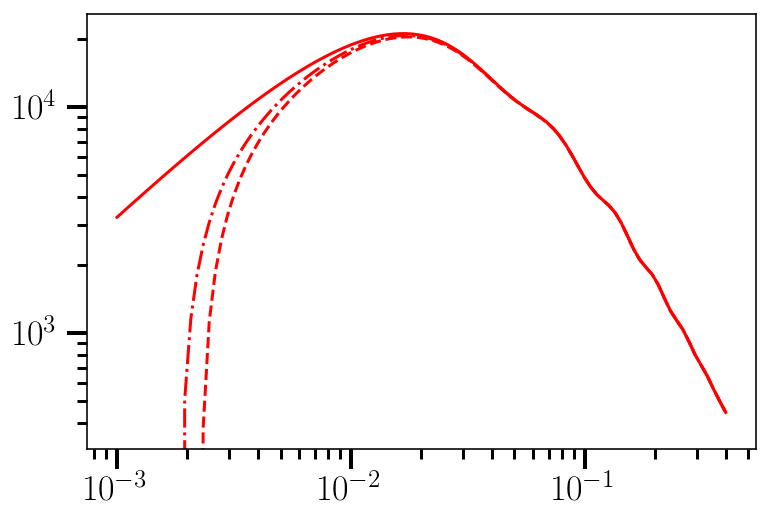

In [37]:
#plt.loglog(ks,Pl0_pp,color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa,'--',color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa1,'-.',color='blue')
plt.loglog(ks,Pl2_pp,color='red')
plt.loglog(ks,Pl2_pp+Pk_l2_wa,'--',color='red')
plt.loglog(ks,Pl2_pp+Pk_l2_wa1,'-.',color='red')
#plt.loglog(ks,Pk_l1_wa)

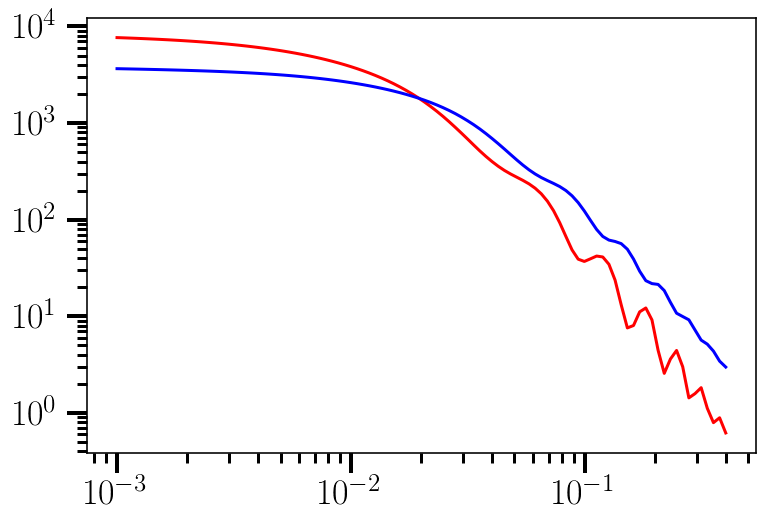

In [38]:
plt.plot(ks,Pk_l1_wa,color='red')
plt.plot(ks,-Pk_l3_wa.imag,color='blue')
plt.xscale('log')
plt.yscale('log')

In [39]:
import scipy 

In [40]:
#all quadrupole
#PP with dfog
def pk_dfog(ks,sigma):
    Pks= Pk_(ks)
    return 5*Pks*np.exp(-ks**2*sigma**2)*(-np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(8*b1**2*ks**6*sigma**6 + 4*b1*ks**4*sigma**4*(-3*b1 + 2*f) - 45*f**2 + 6*f*ks**2*sigma**2*(-6*b1 + f)) - 90*f**2*ks*sigma - 24*f*ks**3*sigma**3*(3*b1 + 2*f) - ks**5*sigma**5*(24*b1**2 + 32*b1*f + 16*f**2))/(32*ks**7*sigma**7)

#include all terms!!
def full_dfog_inv(ks,sigma,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return -5*np.exp(-ks**2*sigma**2)*(-8*Pks*(-8*b1**2*ks**9*sigma**7*(6*d**2 + sigma**2*(4*ks**2*sigma**2 - t**2*(16*ks**2*sigma**2 + 24) + t*(16*ks**2*sigma**2 + 24) + 15)) + 4*b1*f*ks**3*sigma**3*(-16*ks**8*sigma**8 - 16*ks**6*sigma**4*(d**2 + sigma**2*(7 - 5*s)) - 4*ks**4*(9*d**2*sigma**2 + sigma**4*(73 - 70*s)) + 15*ks**2*sigma**2*(24*s - 35) + t**2*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) - t*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) - 450) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**8*sigma**6*(d**2*(-4*ks**2*sigma**2 + 6) + 3*sigma**2*(-2*ks**2*sigma**2 - 8*t**2 + 8*t + 5)) - 2*b1*f*ks**2*sigma**2*(8*d**2*ks**6*sigma**4 + ks**4*(-36*d**2*sigma**2 + sigma**4*(40*s - 22)) + 45*ks**2*sigma**2*(8*s - 5) - t**2*(792*ks**2*sigma**2 - 5400) + t*(792*ks**2*sigma**2 - 5400) - 450) + f**2*(-2*ks**6*(6*d**2*sigma**4 + sigma**6*(100*s**2 - 120*s + 39)) + 9*ks**4*(10*d**2*sigma**2 + sigma**4*(100*s**2 - 160*s + 81)) - 2385*ks**2*sigma**2 - t**2*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + t*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + 12285)) - 2*f**2*ks*sigma*(16*ks**10*sigma**10 + 16*ks**8*sigma**6*(d**2 + sigma**2*(11 - 10*s)) + ks**6*(48*d**2*sigma**4 + sigma**6*(400*s**2 - 720*s + 708)) + 15*ks**4*(6*d**2*sigma**2 + sigma**4*(60*s**2 - 96*s + 161)) + 5805*ks**2*sigma**2 - t**2*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + t*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + 12285)) + ks*(Pkd*(8*b1**2*ks**5*sigma**5*(-24*ks**4*sigma**4 - 138*ks**2*sigma**2 + t**2*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - t*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - 45) + 8*b1*f*ks**3*sigma**3*(-96*ks**6*sigma**6 + 40*ks**4*sigma**4*(2*s - 9) + 6*ks**2*sigma**2*(120*s - 191) + t**2*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - t*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(12*b1**2*ks**4*sigma**4*(16*ks**6*sigma**6 - 20*ks**4*sigma**4 + 36*ks**2*sigma**2 + t**2*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) - t*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) + 15) - 4*b1*f*ks**2*sigma**2*(16*ks**6*sigma**6*(10*s - 3) + 4*ks**4*sigma**4*(51 - 100*s) + 36*ks**2*sigma**2*(20*s - 11) + t**2*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - t*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - 1125) + f**2*(80*ks**6*sigma**6*(4*s - 3) - 36*ks**4*sigma**4*(40*s - 59) - 10620*ks**2*sigma**2 - t**2*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + t*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + 36855)) + 2*f**2*ks*sigma*(-192*ks**8*sigma**8 + 128*ks**6*sigma**6*(5*s - 9) + 24*ks**4*sigma**4*(60*s - 203) - 13950*ks**2*sigma**2 + t**2*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - t*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - 36855)) + Pkdd*ks*(8*b1**2*ks**5*sigma**5*(4*ks**4*sigma**4 + 12*ks**2*sigma**2 + t**2*(24*ks**2*sigma**2 - 540) + t*(-24*ks**2*sigma**2 + 540) + 45) - 8*b1*f*ks**3*sigma**3*(-28*ks**4*sigma**4 - 96*ks**2*sigma**2 + t**2*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - t*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**4*sigma**4*(8*ks**6*sigma**6 - 4*ks**4*sigma**4 + 18*ks**2*sigma**2 + t**2*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - t*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - 45) - 4*b1*f*ks**2*sigma**2*(8*ks**6*sigma**6 + 4*ks**4*sigma**4 - 54*ks**2*sigma**2 - t**2*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + t*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + 225) + f**2*(56*ks**6*sigma**6 - 492*ks**4*sigma**4 + 1950*ks**2*sigma**2 + t**2*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - t*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - 4095)) + 2*f**2*ks*sigma*(64*ks**6*sigma**6 + 284*ks**4*sigma**4 + 780*ks**2*sigma**2 - t**2*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + t*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + 4095))))/(512*d**2*ks**11*sigma**9)

#include no inverse dist stuff
def wa_dfog(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return -5*np.exp(-ks**2*sigma**2)*(-8*Pks*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**8*sigma**6*(d**2*(-4*ks**2*sigma**2 + 6) + 3*sigma**2*(-2*ks**2*sigma**2 - 8*t**2 + 8*t + 5)) - 2*b1*f*ks**2*sigma**2*(8*d**2*ks**6*sigma**4 - 6*ks**4*(6*d**2*sigma**2 + sigma**4) - 81*ks**2*sigma**2 - t**2*(792*ks**2*sigma**2 - 5400) + t*(792*ks**2*sigma**2 - 5400) - 450) + f**2*(-2*ks**6*(6*d**2*sigma**4 + 7*sigma**6) + 9*ks**4*(10*d**2*sigma**2 + 33*sigma**4) - 2385*ks**2*sigma**2 - t**2*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + t*(264*ks**4*sigma**4 - 9720*ks**2*sigma**2 + 56700) + 12285)) - 2*ks*sigma*(4*b1**2*ks**8*sigma**6*(6*d**2 + sigma**2*(4*ks**2*sigma**2 - t**2*(16*ks**2*sigma**2 + 24) + t*(16*ks**2*sigma**2 + 24) + 15)) + 2*b1*f*ks**2*sigma**2*(16*ks**8*sigma**8 + 16*ks**6*sigma**4*(d**2 + 5*sigma**2) + 36*ks**4*sigma**2*(d**2 + 5*sigma**2) + 381*ks**2*sigma**2 - t**2*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) + t*(64*ks**8*sigma**8 + 160*ks**6*sigma**6 + 912*ks**4*sigma**4 + 2808*ks**2*sigma**2 + 5400) + 450) + f**2*(16*ks**10*sigma**10 + 16*ks**8*sigma**6*(d**2 + 7*sigma**2) + ks**6*(48*d**2*sigma**4 + 484*sigma**6) + 3*ks**4*(30*d**2*sigma**2 + 661*sigma**4) + 5805*ks**2*sigma**2 - t**2*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + t*(64*ks**10*sigma**10 + 224*ks**8*sigma**8 + 1904*ks**6*sigma**6 + 8904*ks**4*sigma**4 + 28080*ks**2*sigma**2 + 56700) + 12285))) + ks*(Pkd*(8*b1**2*ks**5*sigma**5*(-24*ks**4*sigma**4 - 138*ks**2*sigma**2 + t**2*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - t*(128*ks**4*sigma**4 + 984*ks**2*sigma**2 + 540) - 45) + 8*b1*f*ks**3*sigma**3*(-96*ks**6*sigma**6 - 328*ks**4*sigma**4 - 858*ks**2*sigma**2 + t**2*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - t*(256*ks**6*sigma**6 + 1792*ks**4*sigma**4 + 6264*ks**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(12*b1**2*ks**4*sigma**4*(16*ks**6*sigma**6 - 20*ks**4*sigma**4 + 36*ks**2*sigma**2 + t**2*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) - t*(144*ks**4*sigma**4 - 208*ks**2*sigma**2 - 180) + 15) - 4*b1*f*ks**2*sigma**2*(16*ks**6*sigma**6 + 44*ks**4*sigma**4 - 108*ks**2*sigma**2 + t**2*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - t*(16*ks**4*sigma**4 - 2736*ks**2*sigma**2 + 13500) - 1125) + f**2*(-112*ks**6*sigma**6 + 1548*ks**4*sigma**4 - 10620*ks**2*sigma**2 - t**2*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + t*(1392*ks**4*sigma**4 - 36720*ks**2*sigma**2 + 170100) + 36855)) + 2*f**2*ks*sigma*(-192*ks**8*sigma**8 - 896*ks**6*sigma**6 - 4296*ks**4*sigma**4 - 13950*ks**2*sigma**2 + t**2*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - t*(512*ks**8*sigma**8 + 4096*ks**6*sigma**6 + 22272*ks**4*sigma**4 + 76680*ks**2*sigma**2 + 170100) - 36855)) + Pkdd*ks*(8*b1**2*ks**5*sigma**5*(4*ks**4*sigma**4 + 12*ks**2*sigma**2 + t**2*(24*ks**2*sigma**2 - 540) + t*(-24*ks**2*sigma**2 + 540) + 45) - 8*b1*f*ks**3*sigma**3*(-28*ks**4*sigma**4 - 96*ks**2*sigma**2 + t**2*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - t*(64*ks**4*sigma**4 + 648*ks**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*ks**4*sigma**4*(8*ks**6*sigma**6 - 4*ks**4*sigma**4 + 18*ks**2*sigma**2 + t**2*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - t*(112*ks**4*sigma**4 - 384*ks**2*sigma**2 + 540) - 45) - 4*b1*f*ks**2*sigma**2*(8*ks**6*sigma**6 + 4*ks**4*sigma**4 - 54*ks**2*sigma**2 - t**2*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + t*(112*ks**4*sigma**4 - 1152*ks**2*sigma**2 + 2700) + 225) + f**2*(56*ks**6*sigma**6 - 492*ks**4*sigma**4 + 1950*ks**2*sigma**2 + t**2*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - t*(336*ks**4*sigma**4 - 5760*ks**2*sigma**2 + 18900) - 4095)) + 2*f**2*ks*sigma*(64*ks**6*sigma**6 + 284*ks**4*sigma**4 + 780*ks**2*sigma**2 - t**2*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + t*(128*ks**6*sigma**6 + 1536*ks**4*sigma**4 + 6840*ks**2*sigma**2 + 18900) + 4095))))/(512*d**2*ks**11*sigma**9)

#fake fog with no wide ange mixing
def wa_dfog_fake(ks,sigma,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    Pkdd= Pk_dd(ks)
    return 5*np.exp(-ks**2*sigma**2)*(Pks*(-24*b1**2*d**2*ks**9*sigma**7 - 8*b1*f*ks**3*sigma**3*(4*d**2*ks**6*sigma**4 + ks**4*(9*d**2*sigma**2 - 28*sigma**4) - 111*ks**2*sigma**2 - t**2*(56*ks**4*sigma**4 + 222*ks**2*sigma**2 + 720) + t*(56*ks**4*sigma**4 + 222*ks**2*sigma**2 + 720) - 360) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(4*b1**2*d**2*ks**8*sigma**6*(-2*ks**2*sigma**2 + 3) - 4*b1*f*ks**2*sigma**2*(2*d**2*ks**6*sigma**4 - 9*ks**4*sigma**2*(d**2 - 2*sigma**2) - 129*ks**2*sigma**2 + t**2*(36*ks**4*sigma**4 - 258*ks**2*sigma**2 + 720) - t*(36*ks**4*sigma**4 - 258*ks**2*sigma**2 + 720) + 360) + f**2*(ks**6*(-6*d**2*sigma**4 + 56*sigma**6) + ks**4*(45*d**2*sigma**2 - 804*sigma**4) + 5580*ks**2*sigma**2 + t**2*(144*ks**6*sigma**6 - 2232*ks**4*sigma**4 + 16200*ks**2*sigma**2 - 45360) - t*(144*ks**6*sigma**6 - 2232*ks**4*sigma**4 + 16200*ks**2*sigma**2 - 45360) - 15120)) + 2*f**2*ks*sigma*(-8*d**2*ks**8*sigma**6 - 24*ks**6*sigma**4*(d**2 - 6*sigma**2) - 9*ks**4*(5*d**2*sigma**2 - 124*sigma**4) + 4500*ks**2*sigma**2 + t**2*(480*ks**6*sigma**6 + 3528*ks**4*sigma**4 + 14040*ks**2*sigma**2 + 45360) - t*(480*ks**6*sigma**6 + 3528*ks**4*sigma**4 + 14040*ks**2*sigma**2 + 45360) + 15120)) + f*ks*(-2*Pkd*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(-2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(14*ks**4*sigma**4 - 93*ks**2*sigma**2 + 225) + f*(16*ks**6*sigma**6 - 186*ks**4*sigma**4 + 1125*ks**2*sigma**2 + t**2*(48*ks**6*sigma**6 - 576*ks**4*sigma**4 + 3510*ks**2*sigma**2 - 8505) + t*(-48*ks**6*sigma**6 + 576*ks**4*sigma**4 - 3510*ks**2*sigma**2 + 8505) - 2835)) + 6*ks*sigma*(2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(4*ks**4*sigma**4 + 19*ks**2*sigma**2 + 75) + f*(8*ks**6*sigma**6 + 64*ks**4*sigma**4 + 255*ks**2*sigma**2 + t**2*(16*ks**6*sigma**6 + 168*ks**4*sigma**4 + 720*ks**2*sigma**2 + 2835) - t*(16*ks**6*sigma**6 + 168*ks**4*sigma**4 + 720*ks**2*sigma**2 + 2835) + 945))) + Pkdd*ks*(4*b1*ks**3*sigma**3*(2*t**2 - 2*t + 1)*(2*ks**4*sigma**4 + 3*ks**2*sigma**2 + 90) + np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(2*b1*ks**2*sigma**2*(2*t**2 - 2*t + 1)*(4*ks**6*sigma**6 - 16*ks**4*sigma**4 + 57*ks**2*sigma**2 - 90) + f*(4*ks**6*sigma**6 - 48*ks**4*sigma**4 + 285*ks**2*sigma**2 + t**2*(24*ks**6*sigma**6 - 216*ks**4*sigma**4 + 990*ks**2*sigma**2 - 1890) - t*(24*ks**6*sigma**6 - 216*ks**4*sigma**4 + 990*ks**2*sigma**2 - 1890) - 630)) + 2*f*ks*sigma*(26*ks**4*sigma**4 + 135*ks**2*sigma**2 + t**2*(60*ks**4*sigma**4 + 270*ks**2*sigma**2 + 1890) - t*(60*ks**4*sigma**4 + 270*ks**2*sigma**2 + 1890) + 630))))/(32*d**2*ks**11*sigma**9)


#not sure what these two are...
def wainv_dfog(ks,sigma):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -5*f*(5*s - 2)*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(4*Pks*(9*b1 + 9*f + ks**2*sigma**2*(b1 - f)) + Pkd*ks*(-4*b1*ks**4*sigma**4 - 18*b1 - 9*f + ks**2*sigma**2*(10*b1 + 2*f))) + 2*np.exp(-ks**2*sigma**2)*ks*sigma*(-4*Pks*(9*b1 + 9*f + ks**4*sigma**4*(2*b1 + 2*f) + ks**2*sigma**2*(7*b1 + 5*f)) + Pkd*ks*(18*b1 + 9*f + ks**2*sigma**2*(2*b1 + 4*f))))/(16*d**2*ks**7*sigma**5)

def inv_dfog(ks,sigma):
    Pks= Pk_(ks)
    return 5*Pks*f**2*(2 - 5*s)**2*(np.sqrt(np.pi)*scipy.special.erf(sigma*ks)*(-2*ks**2*sigma**2 + 9) - 2*np.exp(-ks**2*sigma**2)*ks*sigma*(4*ks**2*sigma**2 + 9))/(16*d**2*ks**7*sigma**5)


In [41]:
#dipole stuff 
#include all terms!!
def dip_dfog(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return 3*1j*np.exp(-ks**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(Pkd*ks*(-8*b1**2*ks**6*sigma**6 + 4*b1*ks**4*sigma**4*(3*b1 - 2*f) + 45*f**2 - 6*f*ks**2*sigma**2*(-6*b1 + f)) - 4*Pks*(4*b1**2*ks**6*sigma**6 + 45*f**2 - 3*f*ks**2*sigma**2*(-6*b1 + f))) + 2*ks*sigma*(-Pkd*ks*(45*f**2 + 12*f*ks**2*sigma**2*(3*b1 + 2*f) + ks**4*sigma**4*(12*b1**2 + 16*b1*f + 8*f**2)) + 4*Pks*(45*f**2 + 2*f*ks**4*sigma**4*(6*b1 + 5*f) + 9*f*ks**2*sigma**2*(2*b1 + 3*f) + 4*ks**6*sigma**6*(b1 + f)**2)))/(32*d*ks**8*sigma**7)

#fake fog
def dip_dfog_fake(ks,sigma,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -3*1j*np.exp(-ks**2*sigma**2)*f*(2*t - 1)*(np.sqrt(np.pi)*np.exp(ks**2*sigma**2)*scipy.special.erf(sigma*ks)*(Pkd*ks*(-4*b1*ks**4*sigma**4 + 15*f + ks**2*sigma**2*(6*b1 - 6*f)) + 12*Pks*(-5*f + ks**2*sigma**2*(-b1 + f))) + 2*ks*sigma*(-Pkd*ks*(15*f + ks**2*sigma**2*(6*b1 + 4*f)) + 4*Pks*(15*f + ks**4*sigma**4*(2*b1 + 2*f) + ks**2*sigma**2*(3*b1 + 7*f))))/(8*d*ks**8*sigma**7)




In [42]:
#3rd order parts
def pk_dipo_3(kk,d,t):
    Pks = Pk_(kk)
    Pkd = Pk_d(kk)
    Pkdd = Pk_dd(kk)
    Pkddd = Pk_ddd(kk)
    
    return -1j*f*(2*t - 1)*(2*Pkddd*kk**3*(-12*b1*(t*(t - 1) + 1) + f*(-t*(109*t - 109) + 4)) + 48*Pks*(3*b1*(t*(t - 1) + 1) + 2*f*t*(t - 1)) + 12*kk*(Pkd*(4*b1*(t*(t - 1) + 1) + f*(-t*(97*t - 97) - 4)) + Pkdd*kk*(-10*b1*(t*(t - 1) + 1) - 107*f*t*(t - 1))))/(105*d**3*kk**3)

def pk_octo_3(kk,d,t):
    Pks = Pk_(kk)
    Pkd = Pk_d(kk)
    Pkdd = Pk_dd(kk)
    Pkddd = Pk_ddd(kk)
    return -8*1j*f*(2*t - 1)*(Pkddd*kk**3*(77*b1*(t*(t - 1) + 1) + 3*f*(t*(3*t - 3) + 7)) + 24*Pks*(77*b1*(t*(t - 1) + 1) + 93*f*t*(t - 1) + 30*f) + 3*kk*(-Pkd*(308*b1*(t*(t - 1) + 1) + 9*f*(t*(4*t - 4) + 13)) + Pkdd*f*kk*(-t*(56*t - 56) + 5)))/(495*d**3*kk**3)

def pk_octo_dfog_3(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd = Pk_d(kk)
    Pkdd = Pk_dd(kk)
    Pkddd = Pk_ddd(kk)
    return -7*1j*np.exp(-kk**2*sigma**2)*f*(2*t - 1)*(-8*Pks*(8*b1*kk**3*sigma**3*(t**2 - t + 1)*(20*kk**6*sigma**6 + 173*kk**4*sigma**4 + 735*kk**2*sigma**2 + 3150) - 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-4*b1*kk**2*sigma**2*(t**2 - t + 1)*(6*kk**6*sigma**6 - 81*kk**4*sigma**4 + 455*kk**2*sigma**2 - 1050) + f*(16*kk**8*sigma**8 - 520*kk**6*sigma**6 + 5780*kk**4*sigma**4 - 32130*kk**2*sigma**2 + t**2*(24*kk**8*sigma**8 - 924*kk**6*sigma**6 + 10890*kk**4*sigma**4 - 62685*kk**2*sigma**2 + 151200) - t*(24*kk**8*sigma**8 - 924*kk**6*sigma**6 + 10890*kk**4*sigma**4 - 62685*kk**2*sigma**2 + 151200) + 75600)) + 2*f*kk*sigma*(128*kk**8*sigma**8 + 1576*kk**6*sigma**6 + 13560*kk**4*sigma**4 + 54810*kk**2*sigma**2 + t**2*(288*kk**8*sigma**8 + 3420*kk**6*sigma**6 + 28260*kk**4*sigma**4 + 114345*kk**2*sigma**2 + 453600) - t*(288*kk**8*sigma**8 + 3420*kk**6*sigma**6 + 28260*kk**4*sigma**4 + 114345*kk**2*sigma**2 + 453600) + 226800)) + kk*(2*Pkd*(4*b1*kk**3*sigma**3*(t**2 - t + 1)*(96*kk**6*sigma**6 + 892*kk**4*sigma**4 + 3780*kk**2*sigma**2 + 17325) - 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-2*b1*kk**2*sigma**2*(t**2 - t + 1)*(40*kk**6*sigma**6 - 484*kk**4*sigma**4 + 2590*kk**2*sigma**2 - 5775) + f*(40*kk**8*sigma**8 - 1048*kk**6*sigma**6 + 10970*kk**4*sigma**4 - 59220*kk**2*sigma**2 + t**2*(48*kk**8*sigma**8 - 2064*kk**6*sigma**6 + 22410*kk**4*sigma**4 - 120015*kk**2*sigma**2 + 274050) - t*(48*kk**8*sigma**8 - 2064*kk**6*sigma**6 + 22410*kk**4*sigma**4 - 120015*kk**2*sigma**2 + 274050) + 137025)) + 2*f*kk*sigma*(224*kk**8*sigma**8 + 2740*kk**6*sigma**6 + 24090*kk**4*sigma**4 + 96390*kk**2*sigma**2 + t**2*(432*kk**8*sigma**8 + 5256*kk**6*sigma**6 + 46440*kk**4*sigma**4 + 188055*kk**2*sigma**2 + 822150) - t*(432*kk**8*sigma**8 + 5256*kk**6*sigma**6 + 46440*kk**4*sigma**4 + 188055*kk**2*sigma**2 + 822150) + 411075)) + kk*(2*Pkdd*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-2*b1*kk**2*sigma**2*(t**2 - t + 1)*(16*kk**6*sigma**6 - 160*kk**4*sigma**4 + 770*kk**2*sigma**2 - 1575) + f*(8*kk**8*sigma**8 - 200*kk**6*sigma**6 + 2010*kk**4*sigma**4 - 10500*kk**2*sigma**2 + t**2*(48*kk**8*sigma**8 - 576*kk**6*sigma**6 + 4690*kk**4*sigma**4 - 22575*kk**2*sigma**2 + 47250) + t*(-48*kk**8*sigma**8 + 576*kk**6*sigma**6 - 4690*kk**4*sigma**4 + 22575*kk**2*sigma**2 - 47250) + 23625)) - 2*kk*sigma*(2*b1*kk**2*sigma**2*(t**2 - t + 1)*(16*kk**6*sigma**6 + 200*kk**4*sigma**4 + 840*kk**2*sigma**2 + 4725) + f*(32*kk**8*sigma**8 + 420*kk**6*sigma**6 + 3930*kk**4*sigma**4 + 15750*kk**2*sigma**2 + t**2*(-16*kk**8*sigma**8 + 392*kk**6*sigma**6 + 6720*kk**4*sigma**4 + 26775*kk**2*sigma**2 + 141750) + t*(16*kk**8*sigma**8 - 392*kk**6*sigma**6 - 6720*kk**4*sigma**4 - 26775*kk**2*sigma**2 - 141750) + 70875))) + Pkddd*kk*(56*b1*kk**3*sigma**3*(t**2 - t + 1)*(2*kk**4*sigma**4 + 5*kk**2*sigma**2 + 75) + 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1*kk**2*sigma**2*(t**2 - t + 1)*(4*kk**6*sigma**6 - 28*kk**4*sigma**4 + 105*kk**2*sigma**2 - 175) + f*(24*kk**6*sigma**6 - 280*kk**4*sigma**4 + 1470*kk**2*sigma**2 + t**2*(96*kk**6*sigma**6 - 850*kk**4*sigma**4 + 3465*kk**2*sigma**2 - 6300) + t*(-96*kk**6*sigma**6 + 850*kk**4*sigma**4 - 3465*kk**2*sigma**2 + 6300) - 3150)) + 2*f*kk*sigma*(32*kk**6*sigma**6 + 420*kk**4*sigma**4 + 1890*kk**2*sigma**2 + t**2*(16*kk**8*sigma**8 + 80*kk**6*sigma**6 + 660*kk**4*sigma**4 + 2205*kk**2*sigma**2 + 18900) - t*(16*kk**8*sigma**8 + 80*kk**6*sigma**6 + 660*kk**4*sigma**4 + 2205*kk**2*sigma**2 + 18900) + 9450)))))/(32*d**3*kk**14*sigma**11)


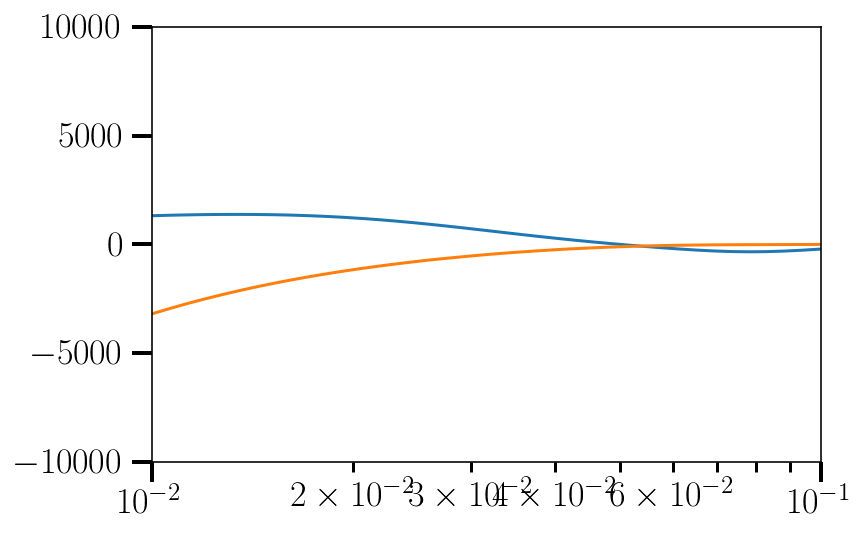

In [2076]:
#PP functions with Dfog
def pk_mono_dfog(kk,sigma):
    Pks = Pk_(kk)
    return Pks*np.exp(-kk**2*sigma**2)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 + 3*f**2) - 6*f**2*kk*sigma - 4*f*kk**3*sigma**3*(2*b1 + f))/(8*kk**5*sigma**5)  
    
def pk_mono_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(4*t**2 - 4*t - 1) + 4*b1*f*kk**3*sigma**3*(-4*kk**6*sigma**6 - 14*kk**4*sigma**4 - 33*kk**2*sigma**2 + t**2*(16*kk**6*sigma**6 + 16*kk**4*sigma**4 + 48*kk**2*sigma**2 + 72) - t*(16*kk**6*sigma**6 + 16*kk**4*sigma**4 + 48*kk**2*sigma**2 + 72) - 54) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8 - 6*b1*f*kk**2*sigma**2*(kk**2*sigma**2 + 24*t**2 - 24*t - 18) + f**2*(7*kk**4*sigma**4 - 153*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 765)) + 2*f**2*kk*sigma*(-4*kk**8*sigma**8 - 22*kk**6*sigma**6 - 109*kk**4*sigma**4 - 357*kk**2*sigma**2 + t**2*(16*kk**8*sigma**8 + 32*kk**6*sigma**6 + 128*kk**4*sigma**4 + 336*kk**2*sigma**2 + 540) - t*(16*kk**8*sigma**8 + 32*kk**6*sigma**6 + 128*kk**4*sigma**4 + 336*kk**2*sigma**2 + 540) - 765)) + kk*(Pkd*(-8*b1**2*kk**5*sigma**5*(8*kk**2*sigma**2 + 3)*(4*t**2 - 4*t - 3) + 8*b1*f*kk**3*sigma**3*(24*kk**4*sigma**4 + 76*kk**2*sigma**2 - t**2*(64*kk**4*sigma**4 + 112*kk**2*sigma**2 + 180) + t*(64*kk**4*sigma**4 + 112*kk**2*sigma**2 + 180) + 135) - np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(8*kk**4*sigma**4 - 6*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 + 4) - t*(8*kk**2*sigma**2 + 4) - 3) + 4*b1*f*kk**2*sigma**2*(8*kk**4*sigma**4 - 14*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 - 180) + t*(-8*kk**2*sigma**2 + 180) + 135) + f**2*(56*kk**4*sigma**4 - 666*kk**2*sigma**2 + t**2*(120*kk**2*sigma**2 - 1620) - t*(120*kk**2*sigma**2 - 1620) + 2295)) + 2*f**2*kk*sigma*(48*kk**6*sigma**6 + 224*kk**4*sigma**4 + 864*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 352*kk**4*sigma**4 + 960*kk**2*sigma**2 + 1620) + t*(128*kk**6*sigma**6 + 352*kk**4*sigma**4 + 960*kk**2*sigma**2 + 1620) + 2295)) + Pkdd*kk*(8*b1**2*kk**5*sigma**5*(2*kk**2*sigma**2 + 12*t**2 - 12*t - 9) + 8*b1*f*kk**3*sigma**3*(-10*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 36) - t*(16*kk**2*sigma**2 + 36) - 27) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(4*kk**4*sigma**4 - 8*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 - 12) + t*(-8*kk**2*sigma**2 + 12) + 9) - 4*b1*f*kk**2*sigma**2*(4*kk**4*sigma**4 + 8*kk**2*sigma**2 + t**2*(-8*kk**2*sigma**2 + 36) + t*(8*kk**2*sigma**2 - 36) - 27) + f**2*(28*kk**4*sigma**4 - 120*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 180) + t*(-24*kk**2*sigma**2 + 180) + 255)) + 2*f**2*kk*sigma*(-16*kk**4*sigma**4 - 50*kk**2*sigma**2 + t**2*(32*kk**4*sigma**4 + 96*kk**2*sigma**2 + 180) - t*(32*kk**4*sigma**4 + 96*kk**2*sigma**2 + 180) - 255))))/(128*d**2*kk**9*sigma**7)

def pk_quad_dfog(kk,sigma):
    Pks = Pk_(kk)
    return  5*Pks*np.exp(-kk**2*sigma**2)*(-np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(-3*b1 + 2*f) - 45*f**2 + 6*f*kk**2*sigma**2*(-6*b1 + f)) - 90*f**2*kk*sigma - 24*f*kk**3*sigma**3*(3*b1 + 2*f) - kk**5*sigma**5*(24*b1**2 + 32*b1*f + 16*f**2))/(32*kk**7*sigma**7)

def pk_quad_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 5*np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(-4*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 24) - t*(16*kk**2*sigma**2 + 24) - 15) + 4*b1*f*kk**3*sigma**3*(-16*kk**8*sigma**8 - 80*kk**6*sigma**6 - 180*kk**4*sigma**4 - 381*kk**2*sigma**2 + t**2*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - t*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - 450) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8*(-2*kk**2*sigma**2 - 8*t**2 + 8*t + 5) + 6*b1*f*kk**2*sigma**2*(2*kk**4*sigma**4 + 27*kk**2*sigma**2 + t**2*(264*kk**2*sigma**2 - 1800) - t*(264*kk**2*sigma**2 - 1800) + 150) + f**2*(-14*kk**6*sigma**6 + 297*kk**4*sigma**4 - 2385*kk**2*sigma**2 - t**2*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + t*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + 12285)) + 2*f**2*kk*sigma*(-16*kk**10*sigma**10 - 112*kk**8*sigma**8 - 484*kk**6*sigma**6 - 1983*kk**4*sigma**4 - 5805*kk**2*sigma**2 + t**2*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - t*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - 12285)) + kk*(Pkd*(8*b1**2*kk**5*sigma**5*(24*kk**4*sigma**4 + 138*kk**2*sigma**2 - t**2*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + t*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-96*kk**6*sigma**6 - 328*kk**4*sigma**4 - 858*kk**2*sigma**2 + t**2*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - t*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(16*kk**6*sigma**6 - 20*kk**4*sigma**4 + 36*kk**2*sigma**2 + t**2*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) - t*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) + 15) + 4*b1*f*kk**2*sigma**2*(16*kk**6*sigma**6 + 44*kk**4*sigma**4 - 108*kk**2*sigma**2 + t**2*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - t*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - 1125) + f**2*(112*kk**6*sigma**6 - 1548*kk**4*sigma**4 + 10620*kk**2*sigma**2 + t**2*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - t*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - 36855)) + 2*f**2*kk*sigma*(192*kk**8*sigma**8 + 896*kk**6*sigma**6 + 4296*kk**4*sigma**4 + 13950*kk**2*sigma**2 - t**2*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + t*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + 36855)) - Pkdd*kk*(8*b1**2*kk**5*sigma**5*(4*kk**4*sigma**4 + 12*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-28*kk**4*sigma**4 - 96*kk**2*sigma**2 + t**2*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - t*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(8*kk**6*sigma**6 - 4*kk**4*sigma**4 + 18*kk**2*sigma**2 + t**2*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - t*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - 45) - 4*b1*f*kk**2*sigma**2*(8*kk**6*sigma**6 + 4*kk**4*sigma**4 - 54*kk**2*sigma**2 - t**2*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + t*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + 225) + f**2*(56*kk**6*sigma**6 - 492*kk**4*sigma**4 + 1950*kk**2*sigma**2 + t**2*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - t*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - 4095)) + 2*f**2*kk*sigma*(64*kk**6*sigma**6 + 284*kk**4*sigma**4 + 780*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + t*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + 4095))))/(512*d**2*kk**11*sigma**9)

def pk_quad(kk,sigma):
    Pks = Pk_(kk)
    return (4*b1*f*Pks)/3 + (4*f**2 *Pks)/7

def pk_dipo(kk,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return-4*f*(3*Pks+ Pkd*kk)*(7*b1 + 3*f)*(2*t - 1)/(35*d*kk)

def pk_dipo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return 3*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(Pkd*kk*(-8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(3*b1 - 2*f) + 45*f**2 - 6*f*kk**2*sigma**2*(-6*b1 + f)) - 4*Pks*(4*b1**2*kk**6*sigma**6 + 45*f**2 - 3*f*kk**2*sigma**2*(-6*b1 + f))) + 2*kk*sigma*(-Pkd*kk*(45*f**2 + 12*f*kk**2*sigma**2*(3*b1 + 2*f) + kk**4*sigma**4*(12*b1**2 + 16*b1*f + 8*f**2)) + 4*Pks*(45*f**2 + 2*f*kk**4*sigma**4*(6*b1 + 5*f) + 9*f*kk**2*sigma**2*(2*b1 + 3*f) + 4*kk**6*sigma**6*(b1 + f)**2)))/(32*d*kk**8*sigma**7)
            
def pk_octo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return  7*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(Pkd*kk*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(16*b1**2*kk**8*sigma**8 + 16*b1*kk**6*sigma**6*(-4*b1 + f) + 875*f**2 + f*kk**2*sigma**2*(500*b1 - 240*f) + kk**4*sigma**4*(100*b1**2 - 192*b1*f + 12*f**2)) - 5250*f**2*kk*sigma - 20*f*kk**3*sigma**3*(150*b1 + 103*f) - kk**7*sigma**7*(16*b1**2 + 128*b1*f + 64*f**2) - kk**5*sigma**5*(600*b1**2 + 848*b1*f + 512*f**2)) + 4*Pks*(-3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-8*b1**2*kk**8*sigma**8 + 20*b1**2*kk**6*sigma**6 + 875*f**2 + 6*f*kk**4*sigma**4*(-6*b1 + f) + f*kk**2*sigma**2*(250*b1 - 165*f)) + 5250*f**2*kk*sigma + 8*f*kk**5*sigma**5*(98*b1 + 97*f) + 10*f*kk**3*sigma**3*(150*b1 + 251*f) + 32*kk**9*sigma**9*(b1 + f)**2 + kk**7*sigma**7*(120*b1**2 + 256*b1*f + 160*f**2)))/(128*d*kk**10*sigma**9)

def pk_hexa_dfog1(kk,sigma):
    Pks = Pk_(kk)
    return (8*f**2 *Pks)/35

def pk_hexa_dfog(kk,sigma):
    Pks = Pk_(kk)
    return  9*Pks*np.exp(-kk**2*sigma**2)*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(16*b1**2*kk**8*sigma**8 + 16*b1*kk**6*sigma**6*(-5*b1 + f) + 1225*f**2 + f*kk**2*sigma**2*(700*b1 - 300*f) + kk**4*sigma**4*(140*b1**2 - 240*b1*f + 12*f**2)) - 7350*f**2*kk*sigma - 100*f*kk**3*sigma**3*(42*b1 + 31*f) - kk**7*sigma**7*(80*b1**2 + 256*b1*f + 128*f**2) - kk**5*sigma**5*(840*b1**2 + 1360*b1*f + 832*f**2))/(256*kk**9*sigma**9)

#Extra wide-angle contributions...
def pk_hexa_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 9*np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(-32*kk**4*sigma**4 - 190*kk**2*sigma**2 + t**2*(128*kk**4*sigma**4 + 640*kk**2*sigma**2 + 1680) - t*(128*kk**4*sigma**4 + 640*kk**2*sigma**2 + 1680) - 735) + 4*b1*f*kk**3*sigma**3*(-128*kk**10*sigma**10 - 1088*kk**8*sigma**8 - 3456*kk**6*sigma**6 - 6898*kk**4*sigma**4 - 1325*kk**2*sigma**2 + t**2*(512*kk**10*sigma**10 + 3072*kk**8*sigma**8 + 25216*kk**6*sigma**6 + 132224*kk**4*sigma**4 + 452000*kk**2*sigma**2 + 1029000) - t*(512*kk**10*sigma**10 + 3072*kk**8*sigma**8 + 25216*kk**6*sigma**6 + 132224*kk**4*sigma**4 + 452000*kk**2*sigma**2 + 1029000) + 51450) + 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**8*sigma**8*(12*kk**4*sigma**4 - 100*kk**2*sigma**2 + t**2*(160*kk**2*sigma**2 - 560) - t*(160*kk**2*sigma**2 - 560) + 245) - 2*b1*f*kk**2*sigma**2*(12*kk**6*sigma**6 + 1044*kk**4*sigma**4 - 11875*kk**2*sigma**2 + t**2*(4608*kk**4*sigma**4 - 78000*kk**2*sigma**2 + 343000) - t*(4608*kk**4*sigma**4 - 78000*kk**2*sigma**2 + 343000) + 17150) + f**2*(28*kk**8*sigma**8 - 552*kk**6*sigma**6 + 185*kk**4*sigma**4 + 22225*kk**2*sigma**2 + t**2*(1536*kk**6*sigma**6 - 84960*kk**4*sigma**4 + 1113000*kk**2*sigma**2 - 4630500) - t*(1536*kk**6*sigma**6 - 84960*kk**4*sigma**4 + 1113000*kk**2*sigma**2 - 4630500) + 33075)) + 2*f**2*kk*sigma*(-128*kk**12*sigma**12 - 1344*kk**10*sigma**10 - 5888*kk**8*sigma**8 - 24054*kk**6*sigma**6 - 71465*kk**4*sigma**4 - 132825*kk**2*sigma**2 + t**2*(512*kk**12*sigma**12 + 3584*kk**10*sigma**10 + 45696*kk**8*sigma**8 + 333312*kk**6*sigma**6 + 1733280*kk**4*sigma**4 + 5922000*kk**2*sigma**2 + 13891500) - t*(512*kk**12*sigma**12 + 3584*kk**10*sigma**10 + 45696*kk**8*sigma**8 + 333312*kk**6*sigma**6 + 1733280*kk**4*sigma**4 + 5922000*kk**2*sigma**2 + 13891500) - 99225)) + kk*(Pkd*(8*b1**2*kk**5*sigma**5*(528*kk**6*sigma**6 + 348*kk**4*sigma**4 + 1900*kk**2*sigma**2 - t**2*(1024*kk**6*sigma**6 + 14704*kk**4*sigma**4 + 101200*kk**2*sigma**2 + 73500) + t*(1024*kk**6*sigma**6 + 14704*kk**4*sigma**4 + 101200*kk**2*sigma**2 + 73500) - 3675) - 8*b1*f*kk**3*sigma**3*(-768*kk**8*sigma**8 - 2512*kk**6*sigma**6 - 5660*kk**4*sigma**4 - 2000*kk**2*sigma**2 + t**2*(2048*kk**8*sigma**8 + 39424*kk**6*sigma**6 + 261680*kk**4*sigma**4 + 1004000*kk**2*sigma**2 + 2572500) - t*(2048*kk**8*sigma**8 + 39424*kk**6*sigma**6 + 261680*kk**4*sigma**4 + 1004000*kk**2*sigma**2 + 2572500) + 128625) - 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-4*b1**2*kk**4*sigma**4*(96*kk**8*sigma**8 - 232*kk**6*sigma**6 + 524*kk**4*sigma**4 - 1450*kk**2*sigma**2 + t**2*(2656*kk**6*sigma**6 - 13232*kk**4*sigma**4 + 17400*kk**2*sigma**2 + 24500) - t*(2656*kk**6*sigma**6 - 13232*kk**4*sigma**4 + 17400*kk**2*sigma**2 + 24500) + 1225) + 4*b1*f*kk**2*sigma**2*(32*kk**8*sigma**8 + 424*kk**6*sigma**6 - 6180*kk**4*sigma**4 + 29250*kk**2*sigma**2 + t**2*(32*kk**6*sigma**6 - 16560*kk**4*sigma**4 + 237000*kk**2*sigma**2 - 857500) - t*(32*kk**6*sigma**6 - 16560*kk**4*sigma**4 + 237000*kk**2*sigma**2 - 857500) - 42875) + f**2*(224*kk**8*sigma**8 - 4104*kk**6*sigma**6 + 14380*kk**4*sigma**4 - 8050*kk**2*sigma**2 + t**2*(8160*kk**6*sigma**6 - 364080*kk**4*sigma**4 + 3927000*kk**2*sigma**2 - 13891500) - t*(8160*kk**6*sigma**6 - 364080*kk**4*sigma**4 + 3927000*kk**2*sigma**2 - 13891500) + 99225)) + 2*f**2*kk*sigma*(1536*kk**10*sigma**10 + 7168*kk**8*sigma**8 + 32688*kk**6*sigma**6 + 106420*kk**4*sigma**4 + 174300*kk**2*sigma**2 - t**2*(4096*kk**10*sigma**10 + 82944*kk**8*sigma**8 + 737280*kk**6*sigma**6 + 4351440*kk**4*sigma**4 + 16002000*kk**2*sigma**2 + 41674500) + t*(4096*kk**10*sigma**10 + 82944*kk**8*sigma**8 + 737280*kk**6*sigma**6 + 4351440*kk**4*sigma**4 + 16002000*kk**2*sigma**2 + 41674500) + 297675)) + Pkdd*kk*(8*b1**2*kk**5*sigma**5*(24*kk**6*sigma**6 - 68*kk**4*sigma**4 - 850*kk**2*sigma**2 + t**2*(1264*kk**4*sigma**4 + 400*kk**2*sigma**2 + 73500) - t*(1264*kk**4*sigma**4 + 400*kk**2*sigma**2 + 73500) + 3675) + 8*b1*f*kk**3*sigma**3*(-280*kk**6*sigma**6 - 684*kk**4*sigma**4 + 650*kk**2*sigma**2 + t**2*(512*kk**6*sigma**6 + 17392*kk**4*sigma**4 + 100000*kk**2*sigma**2 + 514500) - t*(512*kk**6*sigma**6 + 17392*kk**4*sigma**4 + 100000*kk**2*sigma**2 + 514500) + 25725) + 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(16*kk**8*sigma**8 + 48*kk**6*sigma**6 - 384*kk**4*sigma**4 + 1100*kk**2*sigma**2 + t**2*(672*kk**6*sigma**6 - 4688*kk**4*sigma**4 + 16200*kk**2*sigma**2 - 24500) - t*(672*kk**6*sigma**6 - 4688*kk**4*sigma**4 + 16200*kk**2*sigma**2 - 24500) - 1225) - 4*b1*f*kk**2*sigma**2*(16*kk**8*sigma**8 - 48*kk**6*sigma**6 + 1152*kk**4*sigma**4 - 5500*kk**2*sigma**2 - t**2*(672*kk**6*sigma**6 - 14064*kk**4*sigma**4 + 81000*kk**2*sigma**2 - 171500) + t*(672*kk**6*sigma**6 - 14064*kk**4*sigma**4 + 81000*kk**2*sigma**2 - 171500) + 8575) + f**2*(112*kk**8*sigma**8 - 2160*kk**6*sigma**6 + 9920*kk**4*sigma**4 - 17500*kk**2*sigma**2 + t**2*(2016*kk**6*sigma**6 - 70320*kk**4*sigma**4 + 567000*kk**2*sigma**2 - 1543500) - t*(2016*kk**6*sigma**6 - 70320*kk**4*sigma**4 + 567000*kk**2*sigma**2 - 1543500) + 11025)) + 2*f**2*kk*sigma*(-512*kk**8*sigma**8 - 1880*kk**6*sigma**6 - 3580*kk**4*sigma**4 + 30450*kk**2*sigma**2 + t**2*(1024*kk**8*sigma**8 + 33792*kk**6*sigma**6 + 311760*kk**4*sigma**4 + 1386000*kk**2*sigma**2 + 4630500) - t*(1024*kk**8*sigma**8 + 33792*kk**6*sigma**6 + 311760*kk**4*sigma**4 + 1386000*kk**2*sigma**2 + 4630500) - 33075))))/(4096*d**2*kk**13*sigma**11)

def pk_6_dfog(kk,sigma):
    Pks = Pk_(kk)
    return 13*Pks*np.exp(-kk**2*sigma**2)*(-5*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(32*b1**2*kk**10*sigma**10 + 16*b1*kk**8*sigma**8*(-21*b1 + 2*f) - 43659*f**2 + 882*f*kk**2*sigma**2*(-22*b1 + 15*f) + kk**6*sigma**6*(1512*b1**2 - 1008*b1*f + 24*f**2) - kk**4*sigma**4*(2772*b1**2 - 7560*b1*f + 1260*f**2)) - 436590*f**2*kk*sigma - 17640*f*kk**3*sigma**3*(11*b1 + 9*f) - kk**9*sigma**9*(672*b1**2 + 1024*b1*f + 512*f**2) - kk**7*sigma**7*(3360*b1**2 + 11424*b1*f + 6144*f**2) - kk**5*sigma**5*(27720*b1**2 + 53760*b1*f + 40824*f**2))/(1024*kk**11*sigma**11)

#plt.plot(ks,pk_hexa_dfog(ks,10)+pk_hexa_dfog_wa(ks,10,560,0))
plt.plot(ks,pk_hexa_dfog(ks,10))
plt.plot(ks,pk_hexa_dfog_wa(ks,10,560,0))
plt.ylim(-1e+4,1e+4)
plt.xlim(1e-2,1e-1)
plt.xscale('log')


In [44]:
np.abs(pk_mono_dfog(0.01,5.3))

30833.55967141567

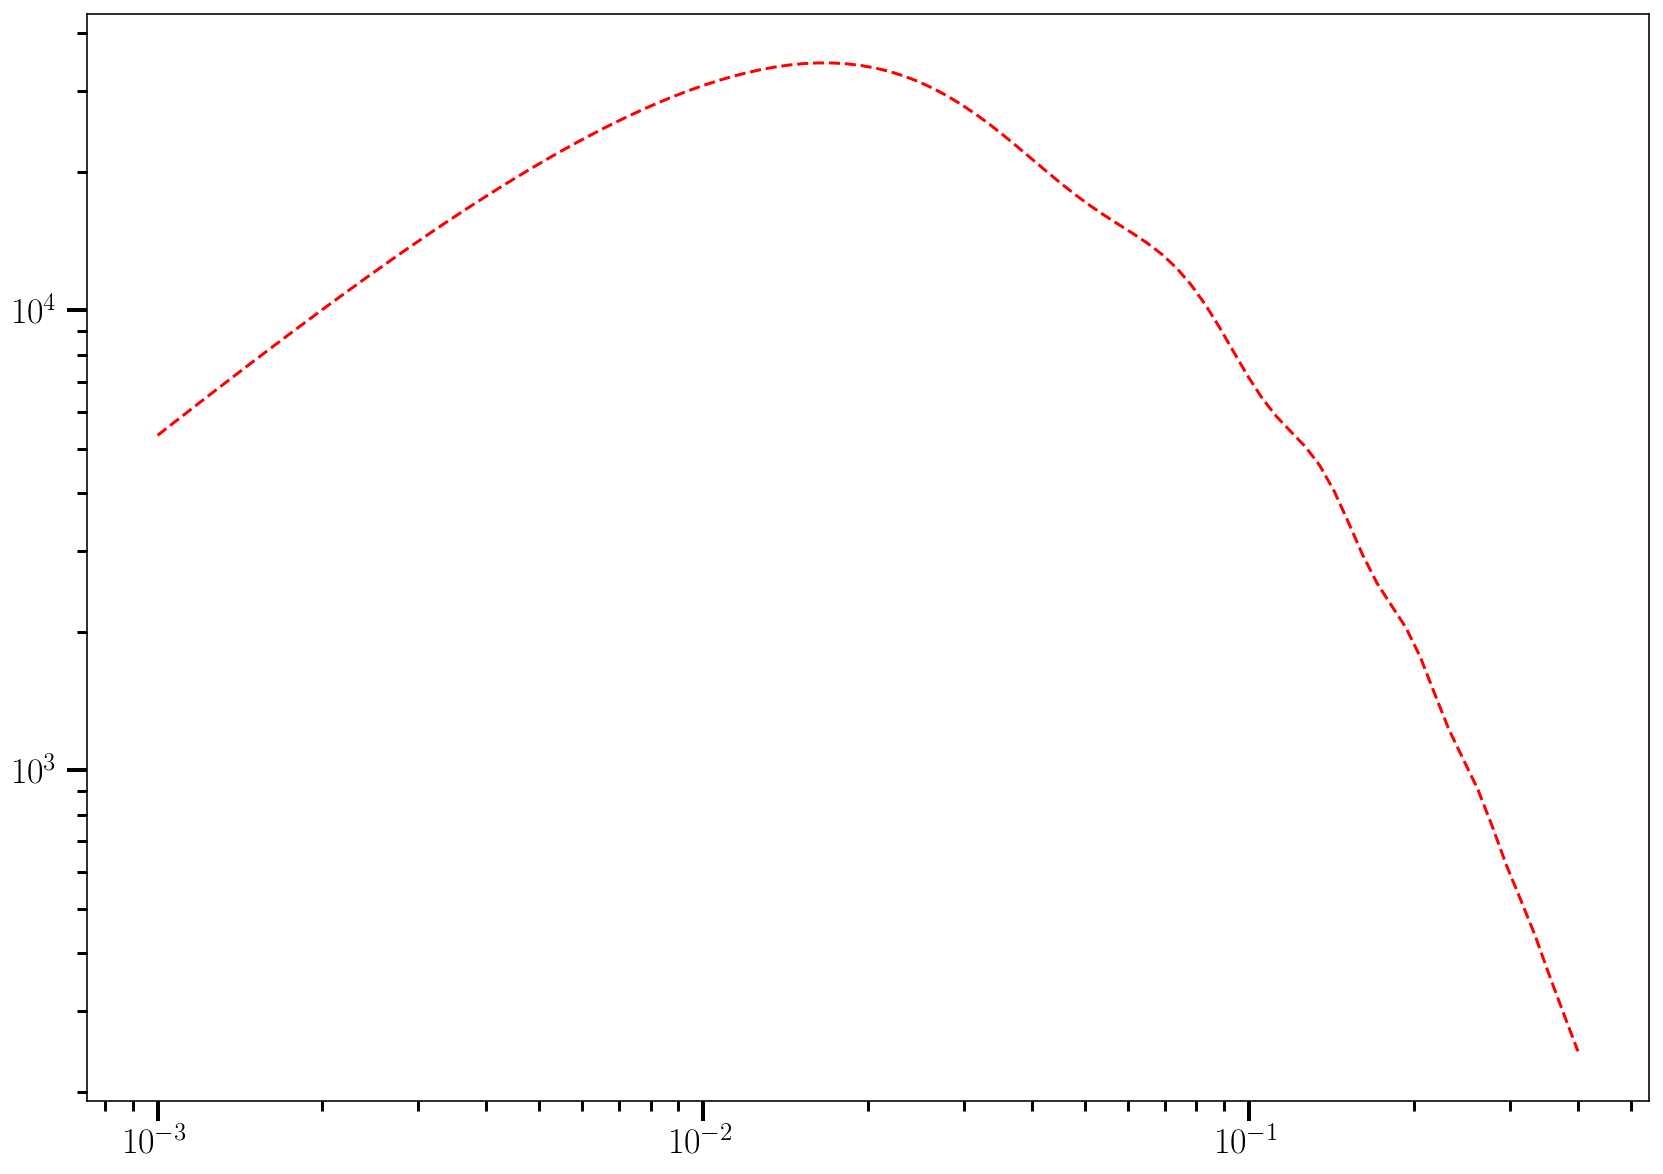

In [45]:
plt.figure(figsize=(14,10))
plt.plot(ks,np.abs(pk_mono_dfog(ks,5.3)),color='red',linestyle='--')
#plt.plot(ks,np.abs(pk_mono_dfog_wa(ks,5.3,500,0)),color='red',linestyle='--')
#plt.plot(ks,np.abs(pk_mono_dfog1_wa(ks,8,500,0)),color='blue',linestyle='--')
plt.yscale('log')
plt.xscale('log')

In [23]:
sigma =10
plt.figure(figsize=(14,10))
d=100
plt.plot(ks,np.abs(pk_dipo_dfog_wa(ks,sigma,d,t).imag),color='red',linestyle='--')
plt.plot(ks,np.abs(pk_dipo_3(ks,d,0).imag),color='green',linestyle='--')
#plt.plot(ks,np.abs(pk_octo_dfog_wa(ks,sigma,d,t)),color='blue',linestyle='--')

#plt.plot(ks,Pk_l1_wa,color='red')
#plt.plot(ks,-Pk_l3_wa.imag,color='blue')

#plt.ylim(-1e4,1e4)
plt.yscale('log')
plt.xscale('log')

NameError: name 'ks' is not defined

<Figure size 1008x720 with 0 Axes>

In [24]:
sigma = 5
plt.figure(figsize=(14,10))
d=100
plt.plot(ks,np.abs(pk_octo_dfog_wa(ks,sigma,d,t).imag),color='red',linestyle='--')
plt.plot(ks,np.abs(pk_octo_3(ks,d,0).imag),color='green',linestyle='-')
plt.plot(ks,np.abs(pk_octo_dfog_3(ks,sigma,d,0).imag),color='green',linestyle='--')

#plt.plot(ks,Pk_l1_wa,color='red')
#plt.plot(ks,-Pk_l3_wa.imag,color='blue')

#plt.ylim(1e+3,1e8)
plt.yscale('log')
plt.xscale('log')

NameError: name 'ks' is not defined

<Figure size 1008x720 with 0 Axes>

In [25]:
plt.figure(figsize=(16,12))
#plt.plot(ks,Pl2_pp,'k')
plt.plot(ks,-pk_quad_dfog_wa(ks,10,1000,0))
plt.plot(ks,-pk_quad_dfog_wa1(ks,4,1000,0))
#plt.plot(ks,np.abs(Pk_l2_wa))


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')

plt.ylim(0.8e+1,1e+4)
plt.xlim(5e-3,5e-1)
plt.yscale('log')
plt.xscale('log')

NameError: name 'ks' is not defined

<Figure size 1152x864 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(ks,pk_mono_dfog(ks,5))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)+pk_mono_dfog_wa(ks,10,0)))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)+Pk_l0_wa1))
#plt.plot(ks,np.abs(pk_quad_dfog(ks,10)+pk_quad_dfog_wa(ks,10,0)),'--')

plt.plot(ks,Pl0_pp)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
plt.plot(ks,np.abs(pk_dipo_dfog_wa(ks,10,0)))
plt.plot(ks,Pk_l1_wa)
#plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ks,np.abs(pk_mono_dfog_wa(ks,10,0)))
plt.plot(ks,np.abs(Pk_l0_wa1))

plt.xscale('log')
plt.yscale('log')
plt.grid(ls='--',lw=0.75)